Initally notebook copy from first cohort of Denali



## Mount Drive, Install Packages, and Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from datetime import datetime

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
import pandas as pd
import time
from datetime import datetime
import seaborn as sns
import os
import scipy.io
from scipy.stats import sem
import math
import shutil
import networkx as nx
import pickle
# import umap
import glob
from pathlib import Path
from collections import Counter
from scipy import stats as st

In [ ]:
#edit these lines
now = datetime.now(); print(datetime.now())
project_name='PN_AppSAA_Cohort1_Analysis_Attempt11' # Remember to make a new NOTEBOOK, don't just create a new project name, if you are running a new analysis. It's ok to use the same notebook if you are only increasing the Attempt # but keeping the VAME parameters the same.
project_date='-Oct12-2022' # Edit this
video_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt6-Feb28-2022/videos/' #update with your video path in VideosToAnalyze

# Probably don't need to edit these lines
project_folder = "".join((project_name, project_date))
path_base = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/'  # DO edit this if you are sharing colab notebooks between people.
project_path = "".join((path_base, project_folder))
VAMEdata_path = "".join((project_path, '/data/'))
config = "".join((path_base, project_name, project_date, '/config.yaml'))

untrimmed_pose_csv_path = ''
trimmed_pose_csv_path = "".join((project_path, '/videos/pose_estimation/'))
#config = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt1-Jan20-2022/config.yaml'
# project_path
# config

2024-02-06 20:44:29.813458


## DLC POST-ANALYSIS



```
# This is formatted as code
```

####Calculate Session Speeds (Allocentric)


In [ ]:
#Calculating Allocentric speed for each session
import os
import pandas as pd

conversion_val = 0.07625 #pixel to cm conversion rate, change for each camera set up
#First,create folder for speed spreadsheets to be saved in
# speed_output_dir = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/ProjectFolders/Katie Project Folders/PASCpilot-RS-Katie-2023-01-24/SpeedData2/'
# os.mkdir(speeddir)
total_sessions = 50
dlc_coord_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VideosToAnalyze/OpenField/Denali/DLC Coordinates/'

#List of body parts to acquire speed for
bodypartlist = ['nose','LFPaw','RFPaw','LBPaw','RBPaw','belly','tailbase', 'midtail', 'tailtip']
#String for the DLC coordinate headers. Can be found by loading in Deeplabcut as a pandas dataframe and printing headers
stringbs = 'DLC_resnet50_Denali-MiceMar8shuffle1_634000'
vame_timewindow = 16 #must agree with vame's timewindow, found in vame config file (mice motion, typically we're interested in ~1/2 second)
fps = 25 #video fps
column_names  = []

for part in bodypartlist:
  column_names.append(part + 'Speed')

#Loop through each session to create individual session speed datasheets
for i in range(1, total_sessions +1):
  file_name = 'Trial-' + str(i) + 'DLC_resnet50_Denali-MiceMar8shuffle1_634000.csv'
  print(file_name)
  dlcpath = dlc_coord_path + file_name
  dlc = pd.read_csv(dlcpath, header = 1) #automatically take first row as a header
  dlc = dlc[1:] #make sure this is indexing to the numerical values (skips headers)
  zero_data = np.zeros(shape=(len(dlc)-vame_timewindow,len(bodypartlist)))
  #Create empty data frame to fill in with speed data
  speeddata = pd.DataFrame(zero_data, columns = column_names)
  for part in bodypartlist:
    speed = []
    distance = []
    #Pull specific body part coordinate data
    x = dlc[part].astype(float)
    y = dlc[part + '.' + str(1)].astype(float)

    #Find difference in position between each frame
    x_diff = x.diff()
    y_diff = y.diff()

    #Find total distance traveled between each frame using Pythagorean Theorem, then convert to cm and divide by length of time of one frame to find speed in cm/s
    # print(conversion_val)
    x_diff_sq = x_diff.apply(np.square, axis=1)
    y_diff_sq = y_diff.apply(np.square, axis=1)
    total_distance = np.sqrt(x_diff_sq + y_diff_sq)
    distance_cm = total_distance*conversion_val
    speed_cms = distance_cm/(1/fps)

    columnheader = part + 'Speed'
    print(columnheader)
    speed_cms_cut = pd.DataFrame(speed_cms, columns=[columnheader]) #vector
    #Cut first x and last x frames to match km_labels output from VAME. x = VAME time window/2

    speed_cms_cut = speed_cms_cut.iloc[int((vame_timewindow/2)):] #removing front values
    speed_cms_cut = speed_cms_cut.iloc[:-int(vame_timewindow/2)]  #removing end values
    speed_cms_cut = speed_cms_cut.reset_index()
    speeddata[columnheader] = speed_cms_cut[columnheader]
    print(speeddata)

  # output_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/SpeedData/'
  # savepath = output_path + '/230310_' + file_name + '_SpeedData.csv'
  # speeddata.to_csv(savepath,index_label=None,index=False)


####Calculate Session Distance (Allocentric)

In [ ]:
#Calculating distance for each session

#First, create a folder where the distance spreadsheets can be saved
distancedir = csv_folder + 'Distance Data'
os.mkdir(distancedir)

#List of body parts to acquire speed for
bodypartlist = ['Nose','FLP','FRP','BLP','BRP','Belly','Tailbase','Midtail','Tailtip']
#String for the DLC coordinate headers. Can be found by loading in Deeplabcut as a pandas dataframe and printing headers
stringbs = 'DLC_resnet50_Therini-OF2-Attempt1Nov10shuffle1_900000'
vame_timewindow = 30

#Loop through each session to create individual session distance datasheets
for i in range(1,slen+1):
  dlcpath = original_dlcpath + 'Session-' + str(i) + '.csv'
  dlc = pd.read_csv(dlcpath)
  dlc = dlc[2:]
  zero_data = np.zeros(shape=(len(dlc)-vame_timewindow,9))
  #Create empty data frame to fill in with speed data
  distancedata = pd.DataFrame(zero_data,columns = ['Nose Distance','FLP Distance','FRP Distance','BLP Distance','BRP Distance',
                                              'Belly Distance','Tailbase Distance','Midtail Distance','Tailtip Distance',])
  counter = 0
  for part in bodypartlist:
    distance = []
    #Pull specific body part coordinate data
    if counter == 0:
      x = dlc[stringbs].astype(float)
    else:
      x = dlc[stringbs + '.' + str(counter*3)].astype(float)
    y = dlc[stringbs + '.' + str((counter*3) + 1)].astype(float)

    #Find difference in position between each frame
    x_diff = x.diff()
    y_diff = y.diff()

    #Find total distance traveled between each frame using Pythagorean Theorem, then convert to cm and divide by length of time of one frame to find speed in cm/s
    x_diff_sq = x_diff.apply(np.square, axis=1)
    y_diff_sq = y_diff.apply(np.square, axis=1)
    total_distance = np.sqrt(x_diff_sq + y_diff_sq)
    distance_cm = total_distance*0.07625

    columnheader = part + ' Distance (cm)'
    distance_cms_cut = pd.DataFrame(distance_cm, columns=[columnheader])
    distance_cms_cut = distance_cms_cut.iloc[15:]
    distance_cms_cut = distance_cms_cut.iloc[:-15]
    distance_cms_cut = distance_cms_cut.reset_index()

    distancedata[part + ' Distance'] = distance_cms_cut[columnheader]
    counter = counter + 1
  savepath = csv_folder + 'Distance Data/230113_TheriniOF2_DistanceData_Session-' + str(i) + '.csv'
  distancedata.to_csv(savepath,index_label=None,index=None)

## VAME POST-ANALYSIS



Katie To Do
Include egocentric speeds and coordinate cells
Include plot figure
functionalize these

Adjust function to adjust for egocentric coordinates vs allocentric speed

Coarse Kinematics (avg belly speed across motif)
Fine Kinematics (each bp across motif)

Adjust this cell to process all 4 data sets
have this cell write out to csv

#Preliminary VAME Analysis

#### Load and Read Metadata

In [ ]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy import stats

In [ ]:
# Define the paths
results_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/'+project_name+project_date+'/results/'
project_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/'+project_name+project_date+'/'

# Define the framerate
fps = 25

In [ ]:
from typing import Any
# Create trial key
# Make sure you have an xlsx with trial and mouse information
# Place the sheet in the project path

mouseinfo_filename = 'AppSAA Cohort 1 Metadata Full - JP Confirmed.xlsx'
mouseinfo_path = ''.join((project_path, mouseinfo_filename))

mouseinfo = pd.read_excel(mouseinfo_path,header = 0)
# mouseinfo = mouseinfo.drop(28) #unique to each cohort

# Find tg and wt trials
mouse_IDs = mouseinfo.ML_ID
all_trials = mouseinfo.SessionNumber
print(mouse_IDs)
print(all_trials)

trials_IDs = pd.concat([mouse_IDs, all_trials], axis=1)
print(trials_IDs)

wt = mouseinfo[mouseinfo.Denali_Genotype.str.contains('WT',regex=False)].reset_index(drop=True)
tg = mouseinfo[mouseinfo.Denali_Genotype.str.contains('HOM',regex=False)].reset_index(drop=True)


wt_trials = list(map(int, list(wt['SessionNumber'])))
#wt_trials = [int(x) for x in wt_trials]
tg_trials = list(map(int, list(tg['SessionNumber'])))
#tg_trials = [int(x) for x in tg_trials]


# Find M and F trials
m = mouseinfo[mouseinfo.Sex.str.contains('M',regex=False)]
f = mouseinfo[mouseinfo.Sex.str.contains('F',regex=False)]

m_trials = list(map(int, list(m['SessionNumber'])))
#m_trials = [int(x) for x in m_trials]
f_trials = list(map(int, list(f['SessionNumber'])))
#f_trials = [int(x) for x in f_trials]

# Find wt and tg trails split by M or F
wt_m = mouseinfo[mouseinfo.GroupCode.str.contains('M-WT',regex=False)]
wt_f = mouseinfo[mouseinfo.GroupCode.str.contains('F-WT',regex=False)]
tg_m = mouseinfo[mouseinfo.GroupCode.str.contains('M-HOM',regex=False)]
tg_f = mouseinfo[mouseinfo.GroupCode.str.contains('F-HOM',regex=False)]


wt_m_trials = list(map(int, list(wt_m['SessionNumber'])))
#wt_m_trials = [int(x) for x in wt_m_trials]
wt_f_trials = list(map(int, list(wt_f['SessionNumber'])))
#wt_f_trials = [int(x) for x in wt_f_trials]
tg_m_trials = list(map(int, list(tg_m['SessionNumber'])))
#tg_m_trials = [int(x) for x in tg_m_trials]
tg_f_trials = list(map(int, list(tg_f['SessionNumber'])))
#tg_f_trials = [int(x) for x in tg_f_trials]


mouseinfo

In [ ]:
#print(wt_trials)
#wt_m_trials = [1, 2, 3, 9, 10, 27, 28, 34, 35, 41, 42, 47, 49] # removed Trial 17
#tg_m_trials = [4, 11, 12, 18, 25, 26, 33, 36, 44, 48] # removed Trial 43

print(trials_IDs.columns)

print(wt_m_trials)
print(tg_m_trials)

print()
print(wt_f_trials)
print(tg_f_trials)

print(len(wt_m_trials))
print(len(wt_m_trials) + len(wt_f_trials) + len(tg_m_trials) + len(tg_f_trials)) # --- Has 49 mice instead of 50 mice because Trial 21 was removed because it was repeated

Index(['ML_ID', 'SessionNumber'], dtype='object')
[1, 2, 5, 9, 14, 18, 21, 24, 25, 31, 40, 43, 47, 50]
[6, 10, 13, 17, 22, 27, 28, 32, 35, 36, 39, 44, 48]

[4, 7, 11, 12, 15, 20, 23, 26, 30, 34, 37, 42, 46]
[3, 8, 16, 19, 29, 33, 38, 41, 45, 49]
14
50


In [ ]:
#Create variables for each unique GroupCode
#Currently not ready to be used with rest of pipeline

mouseinfo_path = os.path.join(project_path, '.xlsx') # create path to metadata file
mouseinfo = pd.read_excel(mouseinfo_path,header = 0) # read in metadata file

mouse_IDs = mouseinfo.Mouse_ID # intialize column of Mouse IDs
all_trials = mouseinfo.SessionNumber # initialize column of Session Numbers
groupcode_session_list = mouseinfo.GroupCode # initialize column of Group Codes for each session/mouse

unique_groups = np.array(mouseinfo.GroupCode.unique()) # Find unique groups among GroupCode column and create string array of these names

# print('Mouse IDs: ', mouse_IDs); print()
# print('Session #s: ', all_trials); print()
print('Unique Groups: ', unique_groups); print()
# print(trials_IDs); print()

unique_group_trials = unique_groups + '_trials'
print('Unique Group Variable Names: ', unique_group_trials); print()

for group_i, group in enumerate(unique_groups):
  group_metadata = mouseinfo[mouseinfo.GroupCode.str.fullmatch(str(group), case=True)].reset_index(drop=True) # initialize a dataframe for a specific group, with all metadata columns
  group_trials = list(map(int, list(group_metadata['SessionNumber']))) # make a list of only the session numbers for the specific group

  group_var_name = unique_group_trials[group_i] # create a name for the group variable containing sessions within that group
  print(group_var_name)

  globals()[group_var_name] = group_trials # initialize those string names as actual variables, and have them equal a list of session numbers corresponding to the specific group
  print(group_trials)
  print('Num Sessions: ', len(group_trials)); print()

# print(all_trials)
# print(C_trials)
# print(X_trials)
# print(B_trials)
# print(Z_trials)
# print(W_trials)
# print(A_trials)

# print('Total Num Sessions: ', (len(W_trials) + len(A_trials) + len(B_trials) + len(C_trials) + len(X_trials) + len(Z_trials)))



In [ ]:
#Defining group labels for plotting
C_label = 'WT F'
X_label = 'WT M'
B_label = 'TG F'
Z_label = 'TG M'

####Read in and Plot Binned Motif Usage

In [ ]:
#Defining video and binning parameters
#Also used for motif usage (no binning)

fps = 25 #fps of video data
total_time_min = 25 #length of video in minutes
timebin_width_min = 5 #bin size in minutes
num_timebins = total_time_min / timebin_width_min
total_num_points = total_time_min * fps * 60 #expected length of video in frames
# frames_per_timebin = total_num_points / num_timebins #length of video in frames
frames_per_bin = fps * timebin_width_min * 60 # number of frames per bin
# bins =  fps * timebin_width_min * 60
n_cluster = 30 # number of motifs

In [ ]:
def get_binned_motif_usage(trials, timebin_width_min, total_num_points, frames_per_bin, n_cluster):

  """
  Parameters
  ----------
  trials : list or vector pd
      session numbers to analyze
  timebin_width_min : int
      number of bins to split the timeseries motif data in minutes
  total_num_points: int
      expected length of data for each session
  frames_per_bin: int
      number of frames in each bin
  n_cluster: int
      number of motifs/ unique values in kmlabels
  Returns
  -------
  summary_motif_binned_perc : numpy array
      shape = (sessions, bins, motif) motif percentage usage for all sessions. depth dimension is the % of motif used per session per bin
  summary_motif_binned_count : numpy array
      shape = (sessiosn, bins, motif) motif usage counts across all sessions. depth dimension is the total frame count of motif usage per session per bin
  """

  summary_motif_binned_perc = [] #Motif usage percentage within each bin for each motif for each session
  summary_motif_binned_count = [] #Total motif frame count within each bin for each motif for each session

  extra_DLC_str = 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled' #change this for each cohort
  for trial in trials: #loop through each session
    print('trial',trial)
    file_name = "".join(('30_km_label_Trial-', str(int(trial)), extra_DLC_str))
    data = np.load("".join((results_path, '/Trial-'+str(int(trial))+extra_DLC_str+ '/VAME/kmeans-', str(n_cluster), '/',  file_name ,'.npy')))
    print('length of kmlabels', len(data))
    print('expected frame length', str(total_num_points))
    data = data[:total_num_points] #KL what if the kmlabels is longer than expected?
    # if len(data) > total_num_points:
    #   print('----------Warning trimming off extra frames----------')

    #Bin motif data of one session
    binned_data = np.zeros((timebin_width_min, frames_per_bin))
    bin_start = 0
    bin_stop = frames_per_bin
    for i_bin in range(0, timebin_width_min): #reshape kmlabel vector into bins
      # print('i_bin', i_bin)
      # print('bin_start', bin_start)
      # print('bin_stop', bin_stop)
      # if not bin_stop > len(data):
      if not bin_stop > len(data):
        temp = data[bin_start:bin_stop]
        binned_data[i_bin,:] = data[bin_start:bin_stop]
        bin_start += frames_per_bin
        bin_stop += frames_per_bin
      else: #only enters here when len(data) is less than total_num_points(expected length) to fill in last bin with nans
        temp = data[bin_start:len(data)]
        nan_a = np.zeros(frames_per_bin - len(temp)) #initialize array size
        nan_a[:] = np.nan
        last_bin = np.concatenate((temp,nan_a), axis = 0)
        binned_data[i_bin,:] = last_bin
        print(binned_data[i_bin, :])
        print('last bin length', str(len(last_bin)))
    #end of binning motif data loop

    #Calculate motif percentages and counts of one session
    trial_perc_usage = [] #shape = (# of bins, # of motifs)
    trial_motif_count = [] #shape = (# of bins, # of motifs)
    values = np.arange(n_cluster)
    for i_bin in binned_data: #each bin
      counts = Counter(i_bin)
      motif_count_binned = np.array([counts[value] for value in values]) # counts number of frames in each motif, returns array of length # of motifs
      perc = np.array([counts[value] / frames_per_bin * 100 for value in values]) #len = # of motifs
      trial_perc_usage.append(perc)
      trial_motif_count.append(motif_count_binned)
    #end of calculating bin percent and count loop

    trial_perc_usage = np.array(trial_perc_usage)
    trial_motif_count = np.array(trial_motif_count)
    summary_motif_binned_perc.append(trial_perc_usage)
    summary_motif_binned_count.append(trial_motif_count)
  #end of trial loop

  summary_motif_binned_perc = np.array(summary_motif_binned_perc)
  summary_motif_binned_count = np.array(summary_motif_binned_count)

  return summary_motif_binned_perc, summary_motif_binned_count


##### Generate motif usage over time for all sessions dataframe
Creates numpy dataframe, shape = (bins, motif) , averaged across sessions

Used for motif-over-time figure


In [ ]:
#get binned motif data for all trials
motif_binned_usage_perc, motif_binned_usage_count = get_binned_motif_usage(all_trials, timebin_width_min, total_num_points, frames_per_bin, n_cluster)
print()
print('motif_binned_usage_perc', motif_binned_usage_perc.shape)
print('motif_binned_usage_count', motif_binned_usage_count.shape)
print()

#Calculate mean and sem across sessions
motif_binned_usage_perc_mean = np.nanmean(motif_binned_usage_perc, axis = 0)
motif_binned_usage_perc_sem = stats.sem(motif_binned_usage_perc, axis = 0, nan_policy = 'omit')
print('motif_binned_usage_perc_mean', motif_binned_usage_perc_mean.shape)
print('motif_binned_usage_perc_sem', motif_binned_usage_perc_sem.shape)
print()


motif_binned_usage_count_mean = np.nanmean(motif_binned_usage_count, axis = 0)
motif_binned_usage_count_sem = stats.sem(motif_binned_usage_count, axis = 0, nan_policy = 'omit')
print('motif_binned_usage_count_mean', motif_binned_usage_count_mean.shape)
print('motif_binned_usage_count_sem', motif_binned_usage_count_sem.shape)



##### Generate motif usage over time by cohort groups dataframe

Creates 4 numpy dataframes for each group, shape = (bins, motif), averaged/sem across sessions

In [ ]:
#get binned motif data for each genotype group
wt_m_motif_B_usage_perc, wt_m_motif_B_usage_count = get_binned_motif_usage(wt_m_trials, timebin_width_min, total_num_points, frames_per_bin, n_cluster)
wt_f_motif_B_usage_perc, wt_f_motif_B_usage_count = get_binned_motif_usage(wt_f_trials, timebin_width_min, total_num_points, frames_per_bin, n_cluster)
tg_m_motif_B_usage_perc, tg_m_motif_B_usage_count = get_binned_motif_usage(tg_m_trials, timebin_width_min, total_num_points, frames_per_bin, n_cluster)
tg_f_motif_B_usage_perc, tg_f_motif_B_usage_count = get_binned_motif_usage(tg_f_trials, timebin_width_min, total_num_points, frames_per_bin, n_cluster)
print()
print('wt_m_motif_B_usage_perc', wt_m_motif_B_usage_perc.shape)
print('wt_m_motif_B_usage_count', wt_m_motif_B_usage_count.shape)
print()
print('wt_f_motif_B_usage_perc', wt_f_motif_B_usage_perc.shape)
print('wt_f_motif_B_usage_count', wt_f_motif_B_usage_count.shape)
print()
print('tg_m_motif_B_usage_perc', tg_m_motif_B_usage_perc.shape)
print('tg_m_motif_B_usage_count', tg_m_motif_B_usage_count.shape)
print()
print('tg_f_motif_B_usage_perc', tg_f_motif_B_usage_perc.shape)
print('tg_f_motif_B_usage_count', tg_f_motif_B_usage_count.shape)
print()

#Calculate mean and sem across sessions
#percent means/sem
wt_m_MBU_perc_mean = np.nanmean(wt_m_motif_B_usage_perc, axis=0)
wt_m_MBU_perc_sem = stats.sem(wt_m_motif_B_usage_perc, axis=0, nan_policy='omit')

wt_f_MBU_perc_mean = np.nanmean(wt_f_motif_B_usage_perc, axis=0)
wt_f_MBU_perc_sem = stats.sem(wt_f_motif_B_usage_perc, axis=0, nan_policy='omit')

tg_m_MBU_perc_mean = np.nanmean(tg_m_motif_B_usage_perc, axis=0)
tg_m_MBU_perc_sem = stats.sem(tg_m_motif_B_usage_perc, axis=0, nan_policy='omit')

tg_f_MBU_perc_mean = np.nanmean(tg_f_motif_B_usage_perc, axis=0)
tg_f_MBU_perc_sem = stats.sem(wt_m_motif_B_usage_perc, axis=0, nan_policy='omit')

print('wt_m_MBU_perc_mean', wt_m_MBU_perc_mean.shape)
print('wt_m_MBU_perc_sem', wt_m_MBU_perc_sem.shape)
print()
print('wt_f_MBU_perc_mean', wt_f_MBU_perc_mean.shape)
print('wt_f_MBU_perc_sem', wt_f_MBU_perc_sem.shape)
print()
print('tg_m_MBU_perc_mean', tg_m_MBU_perc_mean.shape)
print('tg_m_MBU_perc_sem', tg_m_MBU_perc_sem.shape)
print()
print('tg_f_MBU_perc_mean', tg_f_MBU_perc_mean.shape)
print('tg_f_MBU_perc_sem', tg_f_MBU_perc_sem.shape)
print()

#count means/sem
wt_m_MBU_perc_mean = np.nanmean(wt_m_motif_B_usage_perc, axis=0)
wt_m_MBU_perc_sem = stats.sem(wt_m_motif_B_usage_perc, axis=0, nan_policy='omit')

wt_f_MBU_perc_mean = np.nanmean(wt_f_motif_B_usage_perc, axis=0)
wt_f_MBU_perc_sem = stats.sem(wt_f_motif_B_usage_perc, axis=0, nan_policy='omit')

tg_m_MBU_perc_mean = np.nanmean(tg_m_motif_B_usage_perc, axis=0)
tg_m_MBU_perc_sem = stats.sem(tg_m_motif_B_usage_perc, axis=0, nan_policy='omit')

tg_f_MBU_perc_mean = np.nanmean(tg_f_motif_B_usage_perc, axis=0)
tg_f_MBU_perc_sem = stats.sem(wt_m_motif_B_usage_perc, axis=0, nan_policy='omit')

print('wt_m_MBU_perc_mean', wt_m_MBU_perc_mean.shape)
print('wt_m_MBU_perc_sem', wt_m_MBU_perc_sem.shape)
print()
print('wt_f_MBU_perc_mean', wt_f_MBU_perc_mean.shape)
print('wt_f_MBU_perc_sem', wt_f_MBU_perc_sem.shape)
print()
print('tg_m_MBU_perc_mean', tg_m_MBU_perc_mean.shape)
print('tg_m_MBU_perc_sem', tg_m_MBU_perc_sem.shape)
print()
print('tg_f_MBU_perc_mean', tg_f_MBU_perc_mean.shape)
print('tg_f_MBU_perc_sem', tg_f_MBU_perc_sem.shape)
print()



##### Plots Motif Usage Over Time Figure

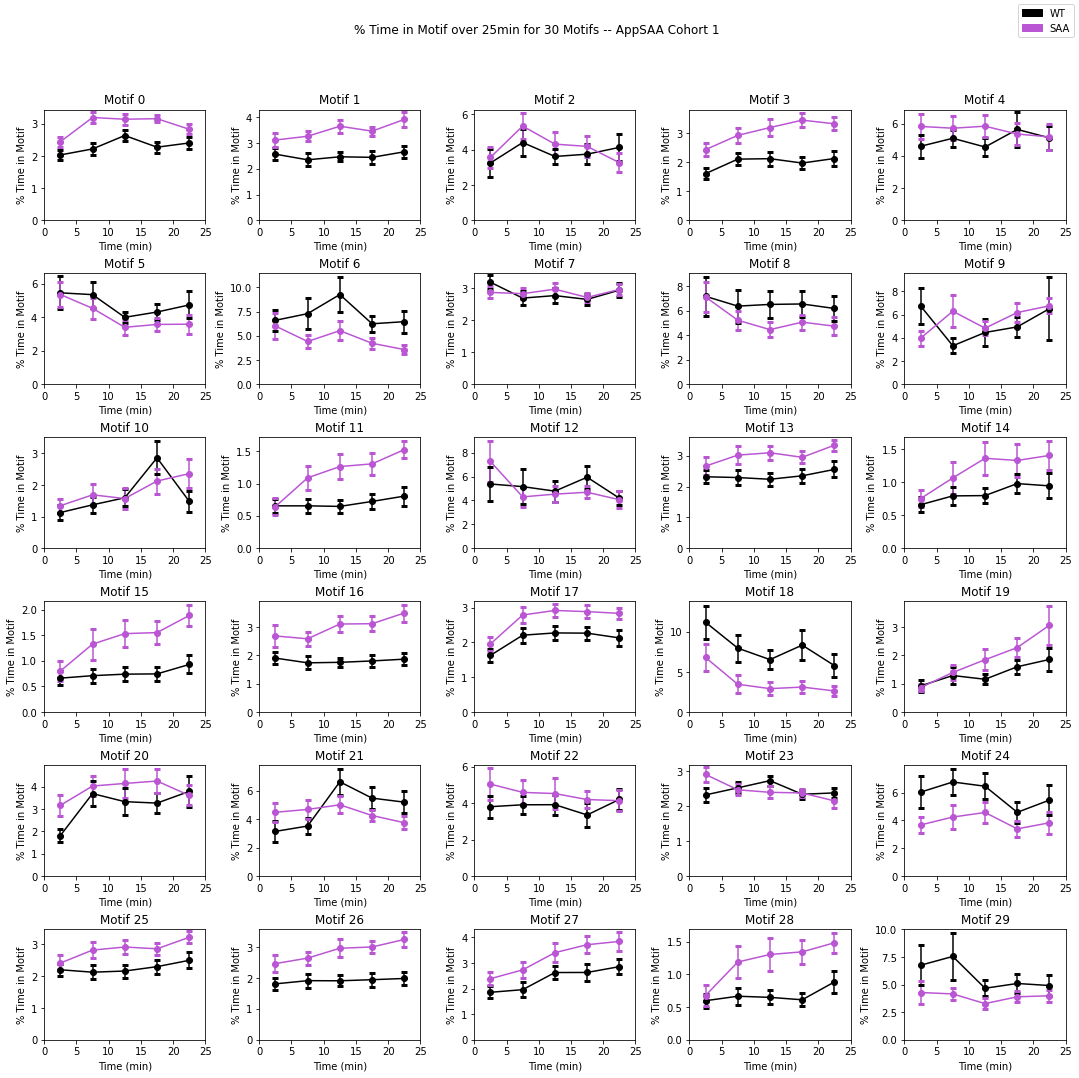

In [ ]:


# Plot motif usage as % of time in 20 or 10 min bins
import math

x = ((np.arange(5)) * 5) + 2.5

#x = np.transpose(x)

i,j=0,0
PLOTS_PER_ROW = 5
fig, axs = plt.subplots(math.ceil(len(wt_df.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15,15))
for col in wt_df.columns:

    axs[i][j].errorbar(x, wt_comb_mean[:,col],yerr=wt_comb_sem[:,col], color='black',fmt='o-', capsize=3, capthick=3)
    axs[i][j].errorbar(x, tg_comb_mean[:,col],yerr=tg_comb_sem[:,col], color='mediumorchid',fmt='o-', capsize=3, capthick=3)

    # axs[i][j].errorbar(x, wt_f_mean[:,col],yerr=wt_f_sem[:,col], color='black',fmt='--', capsize=3, capthick=3)
    # axs[i][j].errorbar(x, tg_f_mean[:,col],yerr=tg_f_sem[:,col], color='red',fmt='o-', capsize=3, capthick=3)

    # axs[i][j].errorbar(x, wt_m_mean[:,col],yerr=wt_m_sem[:,col], color='grey',fmt='--', capsize=3, capthick=3)
    # axs[i][j].errorbar(x, tg_m_mean[:,col],yerr=tg_m_sem[:,col], color='blue',fmt='o-', capsize=3, capthick=3)

    wt_patch = mpatches.Patch(color='black', label='WT')
    saa_patch = mpatches.Patch(color='mediumorchid', label='SAA')
    # black_patch = mpatches.Patch(color='black', label='WT-Female')
    # red_patch = mpatches.Patch(color='red', label='SAA-Female')
    # grey_patch = mpatches.Patch(color='grey', label='WT-Male')
    # blue_patch = mpatches.Patch(color='blue', label='SAA-Male')

    axs[i][j].set_ylabel('% Time in Motif')
    axs[i][j].set_xlabel('Time (min)')
    axs[i][j].set_title('Motif ' + str(col))
    #axs[i][j].legend()
    axs[i][j].set_xlim([0, 25])
    axs[i][j].set_ylim(bottom=0)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
# fig.suptitle('% Time in Motifs - Males', verticalalignment='top')
fig.suptitle('% Time in Motif over 25min for 30 Motifs -- AppSAA Cohort 1')
# fig.legend(handles=[black_patch,grey_patch,red_patch,blue_patch],loc='upper right')
# fig.legend(handles=[black_patch,red_patch],loc='upper right')
# fig.legend(handles=[grey_patch,blue_patch],loc='upper right')

fig.legend(handles=[wt_patch,saa_patch],loc='upper right')

fig.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.savefig('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt6-Feb28-2022/images/PercTime_inMotif_MaleTrials_25min_5minBins.pdf')
# plt.savefig('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt5-Feb16-2022/figures/PercTime_inMotif_GroupedTrials_25min_5minBins.pdf')
# plt.savefig('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt5-Feb16-2022/figures/PercTime_inMotif_AllTrials_25min_5minBins.pdf')
plt.savefig("".join((project_path, 'figures/VAME/PercTime_inMotif_SexCombined_25min_5minBins.pdf')))
# plt.savefig("".join((project_path, 'figures/VAME/PercTime_inMotif_SexGenoGroups_25min_5minBins.pdf')))
# plt.savefig("".join((project_path, 'figures/VAME/PercTime_inMotif_Females_25min_5minBins.pdf')))
# plt.savefig("".join((project_path, 'figures/VAME/PercTime_inMotif_Males_25min_5minBins.pdf')))

#plt.xticks(np.arange(30),labels)

plt.show()

####Read in and Plot Motif Usage

##### Read in Motif Usage and Calculate Mean (Functionalized - PN)

In [ ]:
#Function to create nested array of motif usage counts for all session in a given experimental group

#results_path (str) = base path to the motif_usage.npy files (for all sessions)
#sessions (list of int) = session numbers of interest, if applicable remove any sessions beforehand
#mouse_data_name (str) = 'Session' or 'Trial' (naming convention for videos and data)
#extra_DLC_str (str) = extra DLC tracked string
#cluster_method (str) = behavioral segmentation algorithm (HMM or KMEANS)
#n_cluster (int) = number of motifs
#z_fill_num (int) = number of 0s to fill in session filenames

#group_motif_usage = motif usage count (# frames) for the given experimental group -- form: (rows = sessions, cols = motifs)

def get_motif_usage_count_per_group(results_path, sessions, mouse_data_name, extra_DLC_str, cluster_method, n_cluster, z_fill_num):

    group_motif_usage = []

    for session in sessions:
        data_name = "".join(('motif_usage_', mouse_data_name, str(int(session)).zfill(int(z_fill_num)), extra_DLC_str))
        motif_usage_npy = np.load("".join((results_path, mouse_data_name + str(int(session)).zfill(int(z_fill_num)) + '/VAME/' + cluster_method + '-' + str(n_cluster) + '/', data_name + '.npy' )))
        group_motif_usage.append(motif_usage_npy)

    group_motif_usage = np.array(group_motif_usage)
    return group_motif_usage


#group_motif_usage = nested array of motif usage counts for all sessions in a given experimental group
#fps = fps


#group_[mean]
#      [std]
#      [sem] (nested array) for the given experimental group -- form: (rows = motifs, )

def get_motif_usage_meanANDsem_count_per_group(group_motif_usage, fps):

    group_mean = group_motif_usage.mean(axis=0)
    group_std = np.std(group_motif_usage, axis=0)
    group_sem = stats.sem(group_motif_usage, axis=0)
    group_mean_sec = np.divide(group_mean, fps)
    group_std_sec = np.divide(group_std, fps)
    group_sem_sec = np.divide(group_sem, fps)

    return group_mean, group_std, group_sem, group_mean_sec, group_std_sec, group_sem_sec


In [ ]:
W_motif_usage = get_motif_usage_count_per_group(results_path, W_trials, 'Session', '', 'hmm', 30, 3)
A_motif_usage = get_motif_usage_count_per_group(results_path, A_trials, 'Session', '', 'hmm', 30, 3)
B_motif_usage = get_motif_usage_count_per_group(results_path, B_trials, 'Session', '', 'hmm', 30, 3)
C_motif_usage = get_motif_usage_count_per_group(results_path, C_trials, 'Session', '', 'hmm', 30, 3)
X_motif_usage = get_motif_usage_count_per_group(results_path, X_trials, 'Session', '', 'hmm', 30, 3)
Z_motif_usage = get_motif_usage_count_per_group(results_path, Z_trials, 'Session', '', 'hmm', 30, 3)

In [ ]:
W_mean, W_std, W_sem, W_mean_sec, W_std_sec, W_sem_sec = get_motif_usage_meanANDsem_count_per_group(W_motif_usage, fps)
A_mean, A_std, A_sem, A_mean_sec, A_std_sec, A_sem_sec = get_motif_usage_meanANDsem_count_per_group(A_motif_usage, fps)
B_mean, B_std, B_sem, B_mean_sec, B_std_sec, B_sem_sec = get_motif_usage_meanANDsem_count_per_group(B_motif_usage, fps)
C_mean, C_std, C_sem, C_mean_sec, C_std_sec, C_sem_sec = get_motif_usage_meanANDsem_count_per_group(C_motif_usage, fps)
X_mean, X_std, X_sem, X_mean_sec, X_std_sec, X_sem_sec = get_motif_usage_meanANDsem_count_per_group(X_motif_usage, fps)
Z_mean, Z_std, Z_sem, Z_mean_sec, Z_std_sec, Z_sem_sec = get_motif_usage_meanANDsem_count_per_group(Z_motif_usage, fps)

##### All Sessions Motif Usage Data

Find the number of frames of given motif for each session
output: (session x motif)
saves into an excel file

remove unused variables in this section. Clean and structure similarly to binned data cell.

In [ ]:
total_time_min = 25
#total_time2 = 25*60

total_num_points = total_time_min * fps * 60 #used

timebin_width_min = 5
#timebin_width2 = 5*60

fps = 25 #used
timebin = timebin_width_min*total_time_min
#timebin2 = total_time/timebin_width

bins = fps * timebin_width_min * 60

expected_databin = total_time_min * fps * 60 #should be 1500f/min * 5min = 7500
n_cluster = 30 #used
values = np.arange(30)

In [ ]:
#make this into one function to ouptut the trials motif usage and percentage usage per session, aggregates all the session motif usage
#outputs motif usage in frames, motif usage in percentage (Assign to Pranav)
#group1_motif_usage, other return values = get_Motif_Usage_Summary(trials, percentage_usage = True) #Assigned to Pranav

mice_nonbinned_usage = [] #main df
                          #final form: number of trials x number of motifs

for trial in all_trials:
    dataname_npy = "".join(('motif_usage_Trial-', str(int(trial)), extra_DLC_str)) #vame outputs this file, katie look into this file creates for each session 1 by 30 vector
    data = np.load("".join((results_path, '/Trial-'+str(int(trial))+extra_DLC_str+ '/VAME/kmeans-', str(n_cluster), '/',  dataname_npy ,'.npy')))
    # print(data.shape)
    # total_frames.append(len(data))
    mice_nonbinned_usage.append(data)

mice_nonbinned_usage = np.array(mice_nonbinned_usage)

print(mice_nonbinned_usage)
print(mice_nonbinned_usage.shape)
print()

mice_nonbinned_perc_usage = np.array([]) #final form: number of trials x number of motifs
total_frames = [] #total readout o

#Grabs motif usages for each session and saves them
for i_trial, trial in enumerate(all_trials):
  dataname_npy = "".join(('30_km_label_Trial-', str(int(trial)), extra_DLC_str))
  data = np.load("".join((results_path, '/Trial-'+str(int(trial))+extra_DLC_str+ '/VAME/kmeans-', str(n_cluster), '/',  dataname_npy ,'.npy')))
  data = data[:total_num_points]
  total_frames.append(len(data)) #sanity check of the session's video length
  for i_motif in range(30): #calculates the percent usage using the total frames
    # print(mice_nonbinned_usage[i_trial, i_motif])
    # print(total_frames[i_trial])
    perc_val = (mice_nonbinned_usage[i_trial, i_motif] / total_frames[i_trial])*100
    mice_nonbinned_perc_usage[i_trial, i_motif] = perc_val

mice_nonbinned_perc_usage = np.array(mice_nonbinned_perc_usage)

print(total_frames)
print(mice_nonbinned_perc_usage)
# print(mice_nonbinned_perc_usage.shape)

[[1142 1475  812 ... 1444  838 1262]
 [1289  977 2640 ...  879  396 2504]
 [1273 1267 2397 ...  896  242 2544]
 ...
 [ 828  748 1004 ...  634   60 2053]
 [1010 1235 1227 ...  812  167 1982]
 [ 873  760 3338 ...  939  181 1126]]
(49, 30)

[37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 33496, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 37500, 33496]
[]


In [ ]:
# OPTIONAL
# Export dataframe to excel
df_nonbinned_usage = pd.DataFrame(mice_nonbinned_usage)

df_nonbinned_usage.to_excel(''.join((results_path,'Motif_Usage_All_220517.xlsx')))
df_nonbinned_perc_usage.to_excel(''.join((results_path, 'Motif_Percent_Usage_All_data.xlsx')))

##### Genotype Groups Motif-Usage
four genotype groups variable each size (session by motifs)

In [ ]:
# Create wt and tg motif usage arrays
n_cluster = 30

#example function
#motif_usage_mean, std, sem = perform_Motif_usage_averages(motif_usage, fps) #Assigned to Nick


wt_motif_usage = []
for trial in wt_trials:
    dataname_npy = 'motif_usage_'
    data = np.load("".join((results_path, 'Trial-' , str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '/VAME/kmeans-', str(n_cluster),
                            '/',  dataname_npy , 'Trial-', str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '.npy')))
    wt_motif_usage.append(data)
wt_motif_usage = np.array(wt_motif_usage)

tg_motif_usage = []
for trial in tg_trials:
    dataname_npy = ('motif_usage_')
    data = np.load("".join((results_path, 'Trial-' , str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '/VAME/kmeans-', str(n_cluster),
                            '/',  dataname_npy , 'Trial-', str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '.npy')))
    tg_motif_usage.append(data)
tg_motif_usage = np.array(tg_motif_usage)

# tg2_motif_usage = []
# for trial in tg2_trials:
#     dataname_npy = ('motif_usage')
#     data = np.load("".join((results_path, 'Session', str(trial), '/VAME/kmeans-', str(n_cluster), '/',  dataname_npy ,'.npy')))
#     tg2_motif_usage.append(data)
# tg2_motif_usage = np.array(tg2_motif_usage)

# wt2_motif_usage = []
# for trial in wt2_trials:
#     dataname_npy = ('motif_usage')
#     data = np.load("".join((results_path, 'Session', str(trial), '/VAME/kmeans-', str(n_cluster), '/',  dataname_npy ,'.npy')))
#     wt2_motif_usage.append(data)
# wt2_motif_usage = np.array(wt2_motif_usage)

#sample function call
#mean, mean_sec, std, std_sec, sem, sem_sec = perform_Motif_usage_averages(motif_usage, fps)

wt_mean = wt_motif_usage.mean(axis=0)
wt_mean_sec = np.divide(wt_mean, fps)
wt_std = np.std(wt_motif_usage, axis=0)
wt_std_sec = np.divide(wt_std, fps)
wt_sem = stats.sem(wt_motif_usage, axis=0)
wt_sem_sec = np.divide(wt_sem, fps)

tg_mean = tg_motif_usage.mean(axis=0)
tg_mean_sec = np.divide(tg_mean, fps)
tg_std = np.std(tg_motif_usage, axis=0)
tg_std_sec = np.divide(tg_std, fps)
tg_sem = stats.sem(tg_motif_usage, axis=0)
tg_sem_sec = np.divide(tg_sem, fps)

# tg2_mean = tg2_motif_usage.mean(axis=0)
# tg2_mean_sec = np.divide(tg2_mean, fps)
# tg2_std = np.std(tg2_motif_usage, axis=0)
# tg2_std_sec = np.divide(tg2_std, fps)
# tg2_sem = stats.sem(tg2_motif_usage, axis=0)
# tg2_sem_sec = np.divide(tg2_sem, fps)

# wt2_mean = wt2_motif_usage.mean(axis=0)
# wt2_mean_sec = np.divide(wt2_mean, fps)
# wt2_std = np.std(wt2_motif_usage, axis=0)
# wt2_std_sec = np.divide(wt2_std, fps)
# wt2_sem = stats.sem(wt2_motif_usage, axis=0)
# wt2_sem_sec = np.divide(wt2_sem, fps)




norm_wt_motif_usage = wt_motif_usage/wt_motif_usage.mean(axis=0)

norm_wt_mean = norm_wt_motif_usage.mean(axis=0)
norm_wt_mean_sec = np.divide(norm_wt_mean, fps)
norm_wt_std = np.std(norm_wt_motif_usage, axis=0)
norm_wt_std_sec = np.divide(norm_wt_std, fps)
norm_wt_sem = stats.sem(norm_wt_motif_usage, axis=0)
norm_wt_sem_sec = np.divide(norm_wt_sem, fps)



# norm_wt2_motif_usage = wt2_motif_usage/wt_motif_usage.mean(axis=0)

# norm_wt2_mean = norm_wt2_motif_usage.mean(axis=0)
# norm_wt2_mean_sec = np.divide(norm_wt2_mean, fps)
# norm_wt2_std = np.std(norm_wt2_motif_usage, axis=0)
# norm_wt2_std_sec = np.divide(norm_wt2_std, fps)
# norm_wt2_sem = stats.sem(norm_wt2_motif_usage, axis=0)
# norm_wt2_sem_sec = np.divide(norm_wt2_sem, fps)




norm_tg_motif_usage = tg_motif_usage/wt_motif_usage.mean(axis=0)

norm_tg_mean = norm_tg_motif_usage.mean(axis=0)
norm_tg_mean_sec = np.divide(norm_tg_mean, fps)
norm_tg_std = np.std(norm_tg_motif_usage, axis=0)
norm_tg_std_sec = np.divide(norm_tg_std, fps)
norm_tg_sem = stats.sem(norm_tg_motif_usage, axis=0)
norm_tg_sem_sec = np.divide(norm_tg_sem, fps)

# norm_tg2_motif_usage = tg2_motif_usage/wt_motif_usage.mean(axis=0)

# norm_tg2_mean = norm_tg2_motif_usage.mean(axis=0)
# norm_tg2_mean_sec = np.divide(norm_tg2_mean, fps)
# norm_tg2_std = np.std(norm_tg2_motif_usage, axis=0)
# norm_tg2_std_sec = np.divide(norm_tg2_std, fps)
# norm_tg2_sem = stats.sem(norm_tg2_motif_usage, axis=0)
# norm_tg2_sem_sec = np.divide(norm_tg2_sem, fps)

In [ ]:
#Nick: write normalization function to automate normalizing across multiple genotypes
#prompt user for how many genotype groups
#list of genotype groups to normalize to


In [ ]:
# Find M and F motif Usages for each genotype
# Create wt and tg motif usage arrays
n_cluster = 30

wt_m_usage = []
for trial in wt_m_trials:
    dataname_npy = ('motif_usage_')
    data = np.load("".join((results_path, 'Trial-' , str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '/VAME/kmeans-', str(n_cluster),
                            '/',  dataname_npy , 'Trial-', str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '.npy')))
    wt_m_usage.append(data)
wt_m_usage = np.array(wt_m_usage)

wt_f_usage = []
for trial in wt_f_trials:
    dataname_npy = ('motif_usage_')
    data = np.load("".join((results_path, 'Trial-' , str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '/VAME/kmeans-', str(n_cluster),
                            '/',  dataname_npy , 'Trial-', str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '.npy')))
    wt_f_usage.append(data)
wt_f_usage = np.array(wt_f_usage)

tg_m_usage = []
for trial in tg_m_trials:
    dataname_npy = ('motif_usage_')
    data = np.load("".join((results_path, 'Trial-' , str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '/VAME/kmeans-', str(n_cluster),
                            '/',  dataname_npy , 'Trial-', str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '.npy')))
    tg_m_usage.append(data)
tg_m_usage = np.array(tg_m_usage)

tg_f_usage = []
for trial in tg_f_trials:
    dataname_npy = ('motif_usage_')
    data = np.load("".join((results_path, 'Trial-' , str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '/VAME/kmeans-', str(n_cluster),
                            '/',  dataname_npy , 'Trial-', str(trial), 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled', '.npy')))
    tg_f_usage.append(data)
tg_f_usage = np.array(tg_f_usage)

# tg2_f_usage = []
# for trial in tg2_f_trials:
#     dataname_npy = ('motif_usage')
#     data = np.load("".join((results_path, 'Session', str(trial), '/VAME/kmeans-', str(n_cluster), '/',  dataname_npy ,'.npy')))
#     tg2_f_usage.append(data)
# tg2_f_usage = np.array(tg2_f_usage)

# tg2_m_usage = []
# for trial in tg2_m_trials:
#     dataname_npy = ('motif_usage')
#     data = np.load("".join((results_path, 'Session', str(trial), '/VAME/kmeans-', str(n_cluster), '/',  dataname_npy ,'.npy')))
#     tg2_m_usage.append(data)
# tg2_m_usage = np.array(tg2_m_usage)

# wt2_f_usage = []
# for trial in wt2_f_trials:
#     dataname_npy = ('motif_usage')
#     data = np.load("".join((results_path, 'Session', str(trial), '/VAME/kmeans-', str(n_cluster), '/',  dataname_npy ,'.npy')))
#     wt2_f_usage.append(data)
# wt2_f_usage = np.array(wt2_f_usage)

# wt2_m_usage = []
# for trial in wt2_m_trials:
#     dataname_npy = ('motif_usage')
#     data = np.load("".join((results_path, 'Session', str(trial), '/VAME/kmeans-', str(n_cluster), '/',  dataname_npy ,'.npy')))
#     wt2_m_usage.append(data)
# wt2_m_usage = np.array(wt2_m_usage)

wt_m_mean = wt_m_usage.mean(axis=0)
wt_m_mean_sec = np.divide(wt_m_mean, fps)
wt_m_std = np.std(wt_m_usage, axis=0)
wt_m_std_sec = np.divide(wt_m_std, fps)
wt_m_sem = stats.sem(wt_m_usage, axis=0)
wt_m_sem_sec = np.divide(wt_m_sem, fps)

wt_f_mean = wt_f_usage.mean(axis=0)
wt_f_mean_sec = np.divide(wt_f_mean, fps)
wt_f_std = np.std(wt_f_usage, axis=0)
wt_f_std_sec = np.divide(wt_f_std, fps)
wt_f_sem = stats.sem(wt_f_usage, axis=0)
wt_f_sem_sec = np.divide(wt_f_sem, fps)

tg_m_mean = tg_m_usage.mean(axis=0)
tg_m_mean_sec = np.divide(tg_m_mean, fps)
tg_m_std = np.std(tg_m_usage, axis=0)
tg_m_std_sec = np.divide(tg_m_std, fps)
tg_m_sem = stats.sem(tg_m_usage, axis=0)
tg_m_sem_sec = np.divide(tg_m_sem, fps)

tg_f_mean = tg_f_usage.mean(axis=0)
tg_f_mean_sec = np.divide(tg_f_mean, fps)
tg_f_std = np.std(tg_f_usage, axis=0)
tg_f_std_sec = np.divide(tg_f_std, fps)
tg_f_sem = stats.sem(tg_f_usage, axis=0)
tg_f_sem_sec = np.divide(tg_f_sem, fps)


# wt2_m_mean = wt2_m_usage.mean(axis=0)
# wt2_m_mean_sec = np.divide(wt2_m_mean, fps)
# wt2_m_std = np.std(wt2_m_usage, axis=0)
# wt2_m_std_sec = np.divide(wt2_m_std, fps)
# wt2_m_sem = stats.sem(wt2_m_usage, axis=0)
# wt2_m_sem_sec = np.divide(wt2_m_sem, fps)

# wt2_f_mean = wt2_f_usage.mean(axis=0)
# wt2_f_mean_sec = np.divide(wt2_f_mean, fps)
# wt2_f_std = np.std(wt2_f_usage, axis=0)
# wt2_f_std_sec = np.divide(wt2_f_std, fps)
# wt2_f_sem = stats.sem(wt2_f_usage, axis=0)
# wt2_f_sem_sec = np.divide(wt2_f_sem, fps)

# tg2_m_mean = tg2_m_usage.mean(axis=0)
# tg2_m_mean_sec = np.divide(tg2_m_mean, fps)
# tg2_m_std = np.std(tg2_m_usage, axis=0)
# tg2_m_std_sec = np.divide(tg2_m_std, fps)
# tg2_m_sem = stats.sem(tg2_m_usage, axis=0)
# tg2_m_sem_sec = np.divide(tg2_m_sem, fps)

# tg2_f_mean = tg2_f_usage.mean(axis=0)
# tg2_f_mean_sec = np.divide(tg2_f_mean, fps)
# tg2_f_std = np.std(tg2_f_usage, axis=0)
# tg2_f_std_sec = np.divide(tg2_f_std, fps)
# tg2_f_sem = stats.sem(tg2_f_usage, axis=0)
# tg2_f_sem_sec = np.divide(tg2_f_sem, fps)



norm_wt_usage = wt_motif_usage/wt_motif_usage.mean(axis=0)

norm_wt_mean = norm_wt_usage.mean(axis=0)
norm_wt_mean_sec = np.divide(norm_wt_mean, fps)
norm_wt_std = np.std(norm_wt_usage, axis=0)
norm_wt_std_sec = np.divide(norm_wt_std, fps)
norm_wt_sem = stats.sem(norm_wt_usage, axis=0)
norm_wt_sem_sec = np.divide(norm_wt_sem, fps)



# norm_wt2_usage = wt2_motif_usage/wt_motif_usage.mean(axis=0)

# norm_wt2_mean = norm_wt2_usage.mean(axis=0)
# norm_wt2_mean_sec = np.divide(norm_wt2_mean, fps)
# norm_wt2_std = np.std(norm_wt2_usage, axis=0)
# norm_wt2_std_sec = np.divide(norm_wt2_std, fps)
# norm_wt2_sem = stats.sem(norm_wt2_usage, axis=0)
# norm_wt2_sem_sec = np.divide(norm_wt2_sem, fps)



norm_tg_usage = tg_motif_usage/wt_motif_usage.mean(axis=0)

norm_tg_mean = norm_tg_usage.mean(axis=0)
norm_tg_mean_sec = np.divide(norm_tg_mean, fps)
norm_tg_std = np.std(norm_tg_usage, axis=0)
norm_tg_std_sec = np.divide(norm_tg_std, fps)
norm_tg_sem = stats.sem(norm_tg_usage, axis=0)
norm_tg_sem_sec = np.divide(norm_tg_sem, fps)


sexnorm_wt_usage = wt_motif_usage/wt_motif_usage.mean(axis=0)

sexnorm_wt_mean = norm_wt_usage.mean(axis=0)
sexnorm_wt_mean_sec = np.divide(norm_wt_mean, fps)
sexnorm_wt_std = np.std(norm_wt_usage, axis=0)
sexnorm_wt_std_sec = np.divide(norm_wt_std, fps)
sexnorm_wt_sem = stats.sem(norm_wt_usage, axis=0)
sexnorm_wt_sem_sec = np.divide(norm_wt_sem, fps)

norm_tg_usage = tg_motif_usage/wt_motif_usage.mean(axis=0)

norm_tg_mean = norm_tg_usage.mean(axis=0)
norm_tg_mean_sec = np.divide(norm_tg_mean, fps)
norm_tg_std = np.std(norm_tg_usage, axis=0)
norm_tg_std_sec = np.divide(norm_tg_std, fps)
norm_tg_sem = stats.sem(norm_tg_usage, axis=0)
norm_tg_sem_sec = np.divide(norm_tg_sem, fps)


In [ ]:
norm_wt_f_usage = wt_f_usage/wt_f_usage.mean(axis=0)
print(len(norm_wt_f_usage))
norm_wt_f_mean = norm_wt_f_usage.mean(axis=0)
norm_wt_f_mean_sec = np.divide(norm_wt_f_mean, fps)
norm_wt_f_std = np.std(norm_wt_f_usage, axis=0)
norm_wt_f_std_sec = np.divide(norm_wt_f_std, fps)
norm_wt_f_sem = stats.sem(norm_wt_f_usage, axis=0)
norm_wt_f_sem_sec = np.divide(norm_wt_f_sem, fps)

norm_wt_m_usage = wt_m_usage/wt_m_usage.mean(axis=0)
print(len(norm_wt_m_usage))
norm_wt_m_mean = norm_wt_m_usage.mean(axis=0)
norm_wt_m_mean_sec = np.divide(norm_wt_m_mean, fps)
norm_wt_m_std = np.std(norm_wt_m_usage, axis=0)
norm_wt_m_std_sec = np.divide(norm_wt_m_std, fps)
norm_wt_m_sem = stats.sem(norm_wt_m_usage, axis=0)
norm_wt_m_sem_sec = np.divide(norm_wt_m_sem, fps)

norm_WT_usage = np.append(norm_wt_m_usage, norm_wt_f_usage, axis=0)
#print(norm_WT_usage)
print(len(norm_WT_usage))
print(norm_WT_usage[12])

norm_WT_mean = norm_WT_usage.mean(axis=0)
norm_WT_mean_sec = np.divide(norm_WT_mean, fps)
norm_WT_std = np.std(norm_WT_usage, axis=0)
norm_WT_std_sec = np.divide(norm_WT_std, fps)
norm_WT_sem = stats.sem(norm_WT_usage, axis=0)
norm_WT_sem_sec = np.divide(norm_WT_sem, fps)



In [ ]:
norm_tg_f_usage = tg_f_usage/wt_f_usage.mean(axis=0)

norm_tg_f_mean = norm_tg_f_usage.mean(axis=0)
norm_tg_f_mean_sec = np.divide(norm_tg_f_mean, fps)
norm_tg_f_std = np.std(norm_tg_f_usage, axis=0)
norm_tg_f_std_sec = np.divide(norm_tg_f_std, fps)
norm_tg_f_sem = stats.sem(norm_tg_f_usage, axis=0)
norm_tg_f_sem_sec = np.divide(norm_tg_f_sem, fps)

norm_tg_m_usage = tg_m_usage/wt_m_usage.mean(axis=0)

norm_tg_m_mean = norm_tg_m_usage.mean(axis=0)
norm_tg_m_mean_sec = np.divide(norm_tg_m_mean, fps)
norm_tg_m_std = np.std(norm_tg_m_usage, axis=0)
norm_tg_m_std_sec = np.divide(norm_tg_m_std, fps)
norm_tg_m_sem = stats.sem(norm_tg_m_usage, axis=0)
norm_tg_m_sem_sec = np.divide(norm_tg_m_sem, fps)

print(tg_f_usage[6])
print()
print(tg_m_usage[6])
print()
print(wt_f_usage)
norm_TG_usage = np.append(norm_tg_m_usage, norm_tg_f_usage, axis=0)
print()
print(norm_TG_usage[6][11])
norm_TG_mean = norm_TG_usage.mean(axis=0)
norm_TG_mean_sec = np.divide(norm_TG_mean, fps)
norm_TG_std = np.std(norm_TG_usage, axis=0)
norm_TG_std_sec = np.divide(norm_TG_std, fps)
norm_TG_sem = stats.sem(norm_TG_usage, axis=0)
norm_TG_sem_sec = np.divide(norm_TG_sem, fps)



In [ ]:
print(norm_TG_mean)
print(norm_WT_mean)

##### Raw Motif Usage Figures

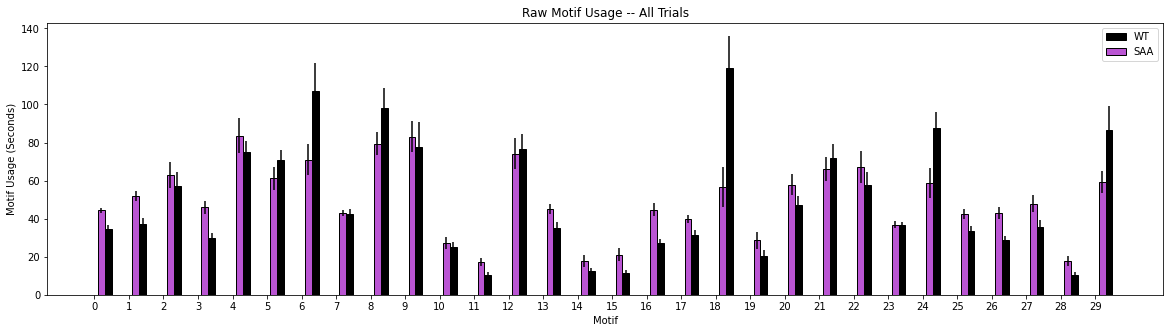

In [ ]:
# Plot the motif usage as grouped bar graph

y_max = 2.5

X_axis = np.arange(len(wt_mean))

width=0.2

# plt.bar(X_axis-width*2, wt_f_mean_sec, width, edgecolor='black', yerr=wt_f_sem_sec, label="WT-Females", color='black')
# plt.bar(X_axis, wt_m_mean_sec, width, edgecolor='black', yerr=wt_m_sem_sec, label="WT-Males", color='grey')
# plt.bar(X_axis-width, tg_f_mean_sec, width, edgecolor='black', yerr=tg_f_sem_sec, label="SAA-Females", color='red')
# plt.bar(X_axis+width, tg_f_mean_sec, width, edgecolor='black', yerr=tg_m_sem_sec, label="SAA-Males", color='blue')

#labels are defined in the 'Load and Read Metadata' section
plt.bar(X_axis+width*2, wt_mean_sec, width, edgecolor='black', yerr=wt_sem_sec, label=wt_label, color='black')
plt.bar(X_axis+width, tg_mean_sec, width, edgecolor='black', yerr=tg_sem_sec, label=tg_label, color='mediumorchid')

plt.xticks(X_axis)
#plt.ylim(0,400)
plt.legend()

plt.xlabel('Motif')
plt.ylabel('Motif Usage (Seconds)')
plt.title('Raw Motif Usage -- All Trials')


plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['svg.fonttype'] = 'none'

# TOGGLE ON OR OFF
from google.colab import files
# plt.savefig('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt6-Feb28-2022/images/RawMotifUsage_AllTrials_bar.pdf')

plt.savefig("".join((project_path, 'figures/VAME/RawMotifUsage_SexCombined_bar.pdf')))
# plt.savefig("".join((project_path, 'figures/VAME/RawMotifUsage_SexGenoGroups_bar.pdf')))

plt.show()

#files.download('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Nick Project Folders/NDK_5xFAD_Analysis_nFeat14_nClust30_timewindow16_Attempt3-Nov5-2021/Images/MotifUsage.PDF')

##### Normalized Motif Usage Figures

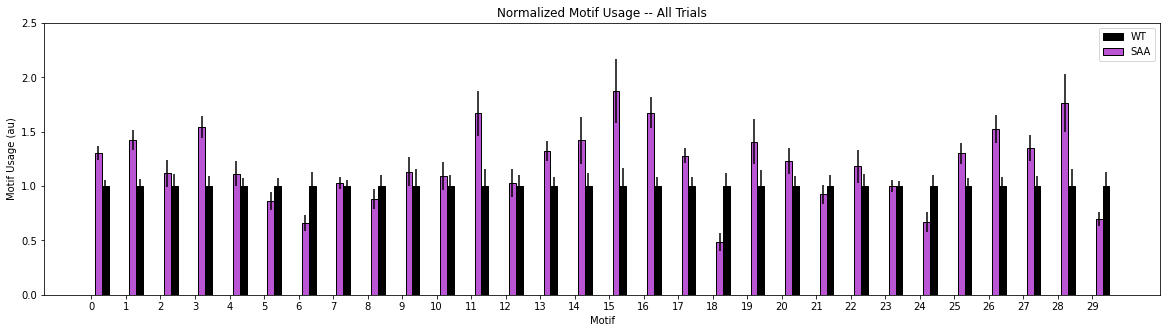

In [ ]:
# Plot the motif usage as grouped bar graph
X_axis = np.arange(len(wt_mean))

width=0.2

# plt.bar(X_axis-width/4, wt_mean_sec, width, edgecolor='black', yerr=wt_sem_sec, label="WT", color='black')
# plt.bar(X_axis+width/4, wt2_mean_sec, width, edgecolor='black', yerr=wt2_sem_sec, label="WT2", color='grey')
# plt.bar(X_axis-width/4, tg_mean_sec, width, edgecolor='black', yerr=tg_sem_sec, label="TG", color='red')
# plt.bar(X_axis+width/4, tg2_mean_sec, width, edgecolor='black', yerr=tg2_sem_sec, label="TG2", color='blue')

plt.bar(X_axis+width*2, norm_WT_mean, width, edgecolor='black', yerr=norm_WT_sem, label=wt_label, color='black')
#plt.bar(X_axis+width, norm_wt2_mean, width, edgecolor='black', yerr=norm_wt2_sem, label=wt2_label, color='grey')
plt.bar(X_axis+width, norm_TG_mean, width, edgecolor='black', yerr=norm_TG_sem, label=tg_label, color='mediumorchid')
#plt.bar(X_axis+width*3, norm_tg2_mean, width, edgecolor='black', yerr=norm_tg2_sem, label=tg2_label, color='blue')

plt.xticks(X_axis)
plt.ylim(0,y_max)
plt.legend()

plt.xlabel('Motif')
plt.ylabel('Motif Usage (au)')
plt.title('Normalized Motif Usage -- All Trials')


plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['svg.fonttype'] = 'none'

# TOGGLE ON OR OFF
from google.colab import files
# plt.savefig("".join((project_path, 'figures/NormMotifUsage_AllTrials_bar.pdf')))
plt.savefig("".join((project_path, 'figures/VAME/NormMotifUsage_SexCombined_bar.pdf')))
plt.show()
#files.download('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Nick Project Folders/NDK_5xFAD_Analysis_nFeat14_nClust30_timewindow16_Attempt3-Nov5-2021/Images/MotifUsage.PDF')

[[1.31495692e+01 2.87585354e-04]
 [1.31482274e+01 2.87791371e-04]
 [4.63946488e-01 4.95785329e-01]
 [1.13273579e+01 7.63734901e-04]
 [6.78260870e-02 7.94528696e-01]
 [2.13872910e+00 1.43620830e-01]
 [3.32364783e+00 6.82901477e-02]
 [2.71345880e-01 6.02430370e-01]
 [6.74648829e-01 4.11435493e-01]
 [2.63317726e+00 1.04652104e-01]
 [2.56856187e-02 8.72670489e-01]
 [6.83662698e+00 8.93073133e-03]
 [2.56856187e-02 8.72670489e-01]
 [5.97381649e+00 1.45198226e-02]
 [2.25775547e+00 1.32946628e-01]
 [7.92291259e+00 4.88126285e-03]
 [1.28605765e+01 3.35577193e-04]
 [5.77955909e+00 1.62136081e-02]
 [9.76695652e+00 1.77676333e-03]
 [4.25779264e+00 3.90706587e-02]
 [2.25764027e+00 1.32956519e-01]
 [3.14648829e-01 5.74841390e-01]
 [9.63661207e-01 3.26266160e-01]
 [1.15992540e-01 7.33422216e-01]
 [5.87598662e+00 1.53487692e-02]
 [4.90093488e+00 2.68421602e-02]
 [9.39491639e+00 2.17587926e-03]
 [5.21578595e+00 2.23827276e-02]
 [5.92525345e+00 1.49253914e-02]
 [1.54274247e+00 2.14210054e-01]]


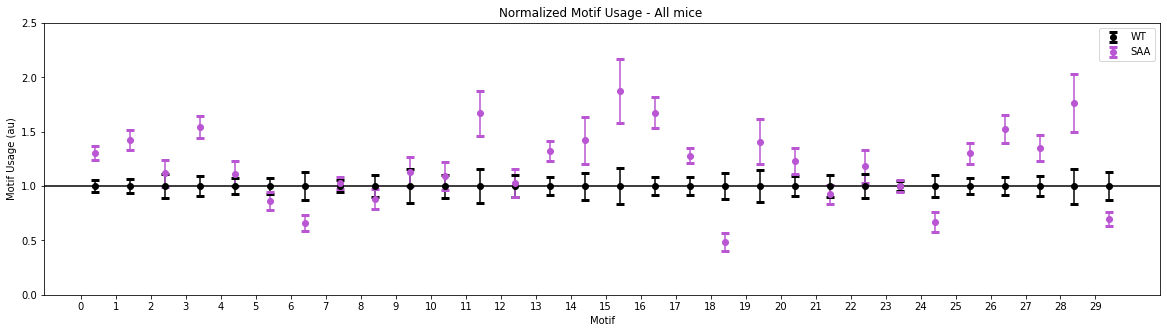

In [ ]:
# Plot the motif usage as grouped bar graph
X_axis = np.arange(len(wt_mean))

width=0.2
#plt.bar(X_axis, wt_f_mean_sec, width, edgecolor='black', yerr=wt_f_sem_sec, label="WT", color='black')
#plt.bar(X_axis+width, wt2_f_mean_sec, width, edgecolor='black', yerr=wt2_f_sem_sec, label="WT2", color='grey')
plt.errorbar(X_axis+width*2, norm_WT_mean, yerr=norm_WT_sem, label=wt_label, color='black',fmt='o', capsize=4, capthick=3)
#plt.errorbar(X_axis+width*2, norm_wt2_mean, yerr=norm_wt2_sem, label=wt2_label, color='grey',fmt='o-', capsize=3, capthick=3)
plt.errorbar(X_axis+width*2, norm_TG_mean, yerr=norm_TG_sem, label=tg_label, color='mediumorchid',fmt='o', capsize=4, capthick=3)
#plt.errorbar(X_axis+width*2, norm_tg2_mean, yerr=norm_tg2_sem, label=tg2_label, color='blue',fmt='o-', capsize=3, capthick=3)

plt.axhline(y=1, c="black")
#plt.plot(X_axis+width*3, norm_tg2_f_mean_sec, width, edgecolor='black', yerr=norm_tg2_f_mean_sec, label="TG2", color='blue')

plt.xticks(X_axis)
plt.ylim(0,y_max)
plt.legend()

plt.xlabel('Motif')
plt.ylabel('Motif Usage (au)')
plt.title('Normalized Motif Usage - All mice ')


plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['svg.fonttype'] = 'none'


from scipy.stats import kruskal
idx = np.arange(len(wt_motif_usage[0]))
def step(i):
    return [*kruskal(norm_tg_usage[:,i], norm_wt_usage[:,i])]

kruskal = np.array(list(map(step, idx)))
print(kruskal)
# print(kruskal[:,1])

# TOGGLE ON OR OFF
from google.colab import files
plt.savefig("".join((project_path, 'figures/VAME/NormMotifUsage_SexCombined.pdf')))

# plt.savefig("".join((project_path, 'figures/NormMotifUsage_AllTrials_withoutLine.pdf')))

plt.show()


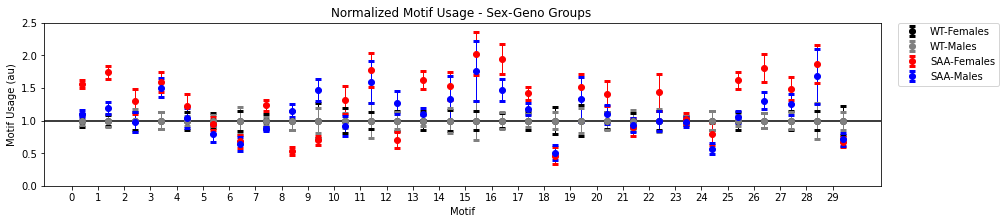

In [ ]:
# Plot the motif usage as grouped bar graph
X_axis = np.arange(len(wt_mean))

width=0.2
#plt.bar(X_axis, wt_f_mean_sec, width, edgecolor='black', yerr=wt_f_sem_sec, label="WT", color='black')
#plt.bar(X_axis+width, wt2_f_mean_sec, width, edgecolor='black', yerr=wt2_f_sem_sec, label="WT2", color='grey')
plt.errorbar(X_axis+width*2, norm_wt_f_mean, yerr=norm_wt_f_sem, label='WT-Females', color='black',fmt='o', capsize=3, capthick=3, linewidth=1)
plt.errorbar(X_axis+width*2, norm_wt_m_mean, yerr=norm_wt_m_sem, label='WT-Males', color='grey',fmt='o', capsize=3, capthick=3, linewidth=1)
#plt.errorbar(X_axis+width*2, norm_wt2_f_mean, yerr=norm_wt2_f_sem, label=wt2_label, color='grey',fmt='o-', capsize=3, capthick=3)
plt.errorbar(X_axis+width*2, norm_tg_f_mean, yerr=norm_tg_f_sem, label='SAA-Females', color='red',fmt='o', capsize=3, capthick=3, linewidth=1)
plt.errorbar(X_axis+width*2, norm_tg_m_mean, yerr=norm_tg_m_sem, label='SAA-Males', color='blue',fmt='o', capsize=3, capthick=3, linewidth=1)
#plt.errorbar(X_axis+width*2, norm_tg2_f_mean, yerr=norm_tg2_f_sem, label=tg2_label, color='blue',fmt='o-', capsize=3, capthick=3)

plt.axhline(y=1, c="black")
#plt.plot(X_axis+width*3, norm_tg2_f_mean_sec, width, edgecolor='black', yerr=norm_tg2_f_mean_sec, label="TG2", color='blue')

plt.xticks(X_axis)
plt.ylim(0,y_max)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend()

plt.xlabel('Motif')
plt.ylabel('Motif Usage (au)')
plt.title('Normalized Motif Usage - Sex-Geno Groups ')

plt.rcParams["figure.figsize"] = (15,3)
plt.rcParams['svg.fonttype'] = 'none'

from scipy.stats import kruskal
idx = np.arange(len(wt_motif_usage[0]))
def step(i):
    return [*kruskal(norm_tg_f_usage[:,i], norm_wt_f_usage[:,i])]

kruskal = np.array(list(map(step, idx)))
# print(kruskal)
# print(kruskal[:,1])

# TOGGLE ON OR OFF
from google.colab import files
# plt.savefig('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt6-Feb28-2022/images/NormMotifUsage_FemaleTrials.pdf')
plt.savefig("".join((project_path, 'figures/VAME/NormMotifUsage_SexGenoGroups.pdf')))
# plt.savefig("".join((project_path, 'figures/NormMotifUsage_FemaleTrials_withoutLine.pdf')))
plt.show()


[[1.37142857e+00 2.41566587e-01]
 [1.05000000e+00 3.05507087e-01]
 [0.00000000e+00 1.00000000e+00]
 [2.75238095e+00 9.71097223e-02]
 [6.88095238e-01 4.06813017e-01]
 [1.60952381e+00 2.04558753e-01]
 [1.05000000e+00 3.05507087e-01]
 [3.08571429e+00 7.89825793e-02]
 [7.71428571e-01 3.79775475e-01]
 [3.80952381e+00 5.09619370e-02]
 [3.80952381e-02 8.45252024e-01]
 [4.66951741e-01 4.94392863e-01]
 [1.16666667e-01 7.32678261e-01]
 [8.57142857e-02 7.69697944e-01]
 [8.59786260e-01 3.53798512e-01]
 [4.34061069e-01 5.10002942e-01]
 [3.08665649e+00 7.89368508e-02]
 [3.42857143e-01 5.58184649e-01]
 [7.46666667e+00 6.28518164e-03]
 [1.60952381e+00 2.04558753e-01]
 [5.35877863e-01 4.64146113e-01]
 [5.95238095e-02 8.07250168e-01]
 [0.00000000e+00 1.00000000e+00]
 [6.09709924e-01 4.34897050e-01]
 [2.59285714e+00 1.07346537e-01]
 [2.14416616e-02 8.83582171e-01]
 [1.73571429e+00 1.87682773e-01]
 [2.38095238e-01 6.25585232e-01]
 [1.52427481e-01 6.96226281e-01]
 [3.80952381e-02 8.45252024e-01]]
[0.241566

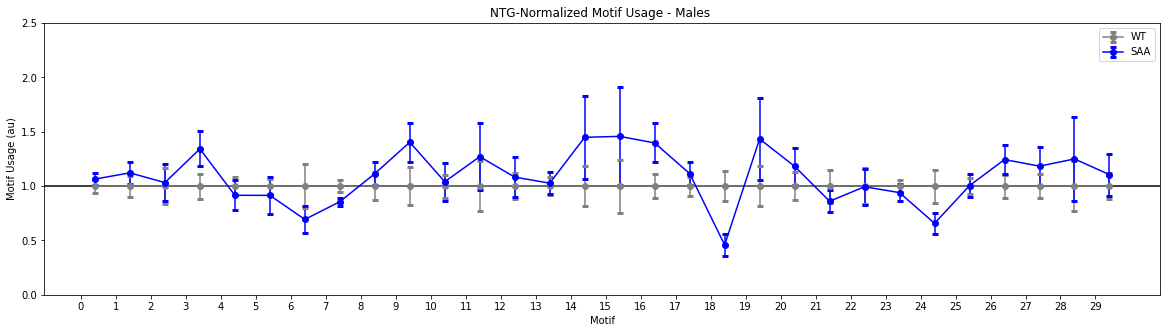

In [ ]:
# Plot the motif usage as grouped bar graph
X_axis = np.arange(len(wt_mean))

width=0.2
#plt.bar(X_axis, wt_f_mean_sec, width, edgecolor='black', yerr=wt_f_sem_sec, label="WT", color='black')
#plt.bar(X_axis+width, wt2_f_mean_sec, width, edgecolor='black', yerr=wt2_f_sem_sec, label="WT2", color='grey')
plt.errorbar(X_axis+width*2, norm_wt_m_mean, yerr=norm_wt_m_sem, label=wt_label, color='grey',fmt='o-', capsize=3, capthick=3)
#plt.errorbar(X_axis+width*2, norm_wt2_m_mean, yerr=norm_wt2_m_sem, label=wt2_label, color='grey',fmt='o-', capsize=3, capthick=3)
plt.errorbar(X_axis+width*2, norm_tg_m_mean, yerr=norm_tg_m_sem, label=tg_label, color='blue',fmt='o-', capsize=3, capthick=3)
#plt.errorbar(X_axis+width*2, norm_tg2_m_mean, yerr=norm_tg2_m_sem, label=tg2_label, color='blue',fmt='o-', capsize=3, capthick=3)

plt.axhline(y=1, c="black")
#plt.plot(X_axis+width*3, norm_tg2_f_mean_sec, width, edgecolor='black', yerr=norm_tg2_f_mean_sec, label="TG2", color='blue')

plt.xticks(X_axis)
plt.ylim(0,y_max)
plt.legend()

plt.xlabel('Motif')
plt.ylabel('Motif Usage (au)')
plt.title('NTG-Normalized Motif Usage - Males ')


plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['svg.fonttype'] = 'none'


from scipy.stats import kruskal
idx = np.arange(len(wt_motif_usage[0]))
def step(i):
    return [*kruskal(norm_tg_m_usage[:,i], norm_wt_m_usage[:,i])]

kruskal = np.array(list(map(step, idx)))
print(kruskal)
print(kruskal[:,1])

# TOGGLE ON OR OFF
from google.colab import files
# plt.savefig('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt6-Feb28-2022/images/NormMotifUsage_MaleTrials.pdf')
plt.savefig("".join((project_path, 'figures/NormMotifUsage_MaleTrials.pdf')))

# plt.savefig("".join((project_path, 'figures/NormMotifUsage_MaleTrials_withoutLine.pdf')))

plt.show()


[[1.04894091e+01 1.20060760e-03]
 [1.09264214e+01 9.48024394e-04]
 [1.52619844e+00 2.16683889e-01]
 [5.30769231e+00 2.12314615e-02]
 [4.02452620e-01 5.25825333e-01]
 [9.03010033e-02 7.63794840e-01]
 [1.36643488e+00 2.42425366e-01]
 [2.06131550e+00 1.51079694e-01]
 [4.42474916e+00 3.54213191e-02]
 [1.11482720e-03 9.73364359e-01]
 [1.07134894e+00 3.00640951e-01]
 [2.67821237e+00 1.01729867e-01]
 [3.13154961e+00 7.67907161e-02]
 [4.42474916e+00 3.54213191e-02]
 [3.13154961e+00 7.67907161e-02]
 [3.62207358e+00 5.70177656e-02]
 [8.05462653e+00 4.53875983e-03]
 [5.00728669e+00 2.52408382e-02]
 [2.06131550e+00 1.51079694e-01]
 [3.37235229e+00 6.62990296e-02]
 [1.07134894e+00 3.00640951e-01]
 [2.67670011e+00 1.01826533e-01]
 [9.37569677e-01 3.32903643e-01]
 [9.37569677e-01 3.32903643e-01]
 [2.78706800e-02 8.67413214e-01]
 [5.30769231e+00 2.12314615e-02]
 [6.60981048e+00 1.01418455e-02]
 [3.88071349e+00 4.88437961e-02]
 [1.87402453e+00 1.71014856e-01]
 [2.78706800e-02 8.67413214e-01]]


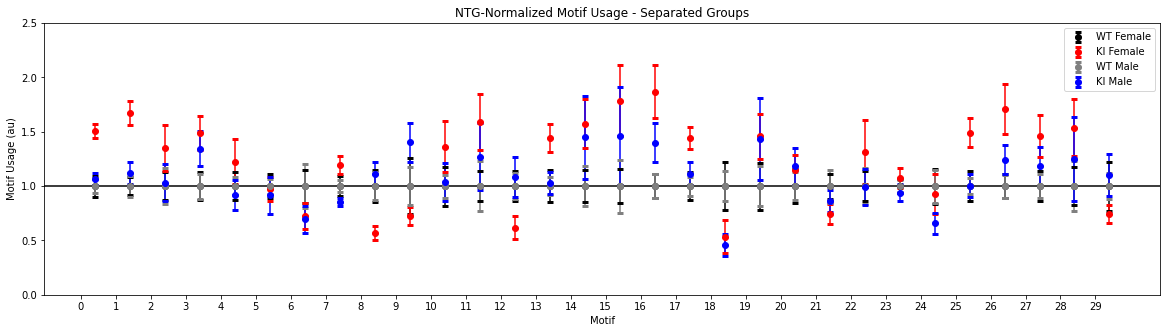

In [ ]:
X_axis = np.arange(len(wt_mean))

width=0.2
#plt.bar(X_axis, wt_f_mean_sec, width, edgecolor='black', yerr=wt_f_sem_sec, label="WT", color='black')
#plt.bar(X_axis+width, wt2_f_mean_sec, width, edgecolor='black', yerr=wt2_f_sem_sec, label="WT2", color='grey')
plt.errorbar(X_axis+width*2, norm_wt_f_mean, yerr=norm_wt_f_sem, label='WT Female', color='black',fmt='o', capsize=3, capthick=3)
plt.errorbar(X_axis+width*2, norm_tg_f_mean, yerr=norm_tg_f_sem, label='KI Female', color='red',fmt='o', capsize=3, capthick=3)

plt.errorbar(X_axis+width*2, norm_wt_m_mean, yerr=norm_wt_m_sem, label='WT Male', color='grey',fmt='o', capsize=3, capthick=3)
plt.errorbar(X_axis+width*2, norm_tg_m_mean, yerr=norm_tg_m_sem, label='KI Male', color='blue',fmt='o', capsize=3, capthick=3)

plt.axhline(y=1, c="black")

plt.xticks(X_axis)
plt.ylim(0,y_max)
plt.legend()

plt.xlabel('Motif')
plt.ylabel('Motif Usage (au)')
plt.title('NTG-Normalized Motif Usage - Separated Groups')


plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['svg.fonttype'] = 'none'


from scipy.stats import kruskal
idx = np.arange(len(wt_motif_usage[0]))
def step(i):
    return [*kruskal(norm_tg_f_usage[:,i], norm_wt_f_usage[:,i])]

kruskal = np.array(list(map(step, idx)))
print(kruskal)

# plt.savefig('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt6-Feb28-2022/images/NormMotifUsage_GroupedTrials.pdf')
# plt.savefig("".join((project_path, 'figures/NormMotifUsage_GroupedTrials.pdf')))

plt.savefig("".join((project_path, 'figures/NormMotifUsage_GroupedTrials_withoutLine.pdf')))

plt.show()

##### Motif Usage plots in D-Order (hard coded)

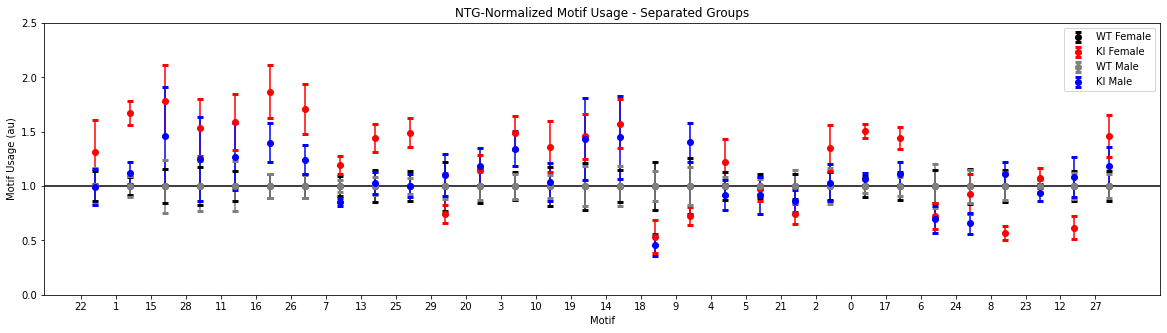

In [ ]:
X_axis = np.arange(len(wt_mean))

dendrogram_order = [22,1,15,28,11,16,26,7,13,25,29,20,3,10,19,14,18,9,4,5,21,2,0,17,6,24,8,23,12,27]
# X_axis = np.array(dendrogram_order)

# fig = plt.figure()
# ax = fig.add_subplot(111)
width=0.2


norm_wt_f_mean_Dorder = norm_wt_f_mean[dendrogram_order]
norm_wt_m_mean_Dorder = norm_wt_m_mean[dendrogram_order]
norm_wt_f_sem_Dorder = norm_wt_f_sem[dendrogram_order]
norm_wt_m_sem_Dorder = norm_wt_m_sem[dendrogram_order]

norm_tg_f_mean_Dorder = norm_tg_f_mean[dendrogram_order]
norm_tg_m_mean_Dorder = norm_tg_m_mean[dendrogram_order]
norm_tg_f_sem_Dorder = norm_tg_f_sem[dendrogram_order]
norm_tg_m_sem_Dorder = norm_tg_m_sem[dendrogram_order]

# X = dendrogram_order
# ax.errorbar(X+width*2, norm_wt_f_mean_Dorder, yerr=norm_wt_f_sem_Dorder, label='WT Female', color='black',fmt='o', capsize=3, capthick=3)
# ax.errorbar(X+width*2, norm_tg_f_mean_Dorder, yerr=norm_tg_f_sem_Dorder, label='KI Female', color='red',fmt='o', capsize=3, capthick=3)
# ax.set_xtick_labels(X)
# plt.errorbar(X_axis+width*2, norm_wt_m_mean_Dorder, yerr=norm_wt_m_sem_Dorder, label='WT Male', color='grey',fmt='o', capsize=3, capthick=3)
# plt.errorbar(X_axis+width*2, norm_tg_m_mean_Dorder, yerr=norm_tg_m_sem_Dorder, label='KI Male', color='blue',fmt='o', capsize=3, capthick=3)




#plt.bar(X_axis, wt_f_mean_sec, width, edgecolor='black', yerr=wt_f_sem_sec, label="WT", color='black')
#plt.bar(X_axis+width, wt2_f_mean_sec, width, edgecolor='black', yerr=wt2_f_sem_sec, label="WT2", color='grey')
plt.errorbar(X_axis+width*2, norm_wt_f_mean_Dorder, yerr=norm_wt_f_sem_Dorder, label='WT Female', color='black',fmt='o', capsize=3, capthick=3)
plt.errorbar(X_axis+width*2, norm_tg_f_mean_Dorder, yerr=norm_tg_f_sem_Dorder, label='KI Female', color='red',fmt='o', capsize=3, capthick=3)

plt.errorbar(X_axis+width*2, norm_wt_m_mean_Dorder, yerr=norm_wt_m_sem_Dorder, label='WT Male', color='grey',fmt='o', capsize=3, capthick=3)
plt.errorbar(X_axis+width*2, norm_tg_m_mean_Dorder, yerr=norm_tg_m_sem_Dorder, label='KI Male', color='blue',fmt='o', capsize=3, capthick=3)
plt.xticks(X_axis, dendrogram_order)

plt.axhline(y=1, c="black")

# plt.xticks(dendrogram_order, X_axis)
plt.ylim(0,y_max)
plt.legend()

# plt.xti

plt.xlabel('Motif')
plt.ylabel('Motif Usage (au)')
plt.title('NTG-Normalized Motif Usage - Separated Groups')
# plt.title('NTG-Normalized Motif Usage - Females ')
# plt.title('NTG-Normalized Motif Usage - Males ')


plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['svg.fonttype'] = 'none'


# from scipy.stats import kruskal
# idx = np.arange(len(wt_motif_usage[0]))
# def step(i):
#     return [*kruskal(norm_tg_f_usage[:,i], norm_wt_f_usage[:,i])]

# kruskal = np.array(list(map(step, idx)))
# print(kruskal)

# plt.savefig('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt6-Feb28-2022/images/NormMotifUsage_GroupedTrials.pdf')
plt.savefig("".join((project_path, 'figures/NormMotifUsage_GroupedTrials_withoutLine_DendrogramOrder.pdf')))
# plt.savefig("".join((project_path, 'figures/NormMotifUsage_MaleTrials_withoutLine_DendrogramOrder.pdf')))
# plt.savefig("".join((project_path, 'figures/NormMotifUsage_FemalesTrials_withoutLine_DendrogramOrder.pdf')))

plt.show()

In [ ]:
print(dendrogram_order)
print(norm_tg_m_mean_Dorder)
print()
print()
print(X_axis)
print(norm_tg_m_mean)

[22, 1, 15, 28, 11, 16, 26, 7, 13, 25, 29, 20, 3, 10, 19, 14, 18, 9, 4, 5, 21, 2, 0, 17, 6, 24, 8, 23, 12, 27]
[0.99394936 1.1215379  1.4573311  1.24970477 1.27079916 1.39669421
 1.24406569 0.85604735 1.02686731 1.00435632 1.1055137  1.18168082
 1.34215805 1.04008214 1.43357641 1.4487557  0.45867522 1.40367217
 0.91517374 0.91474333 0.86062867 1.03176209 1.06443351 1.1149971
 0.69347394 0.65730394 1.11460199 0.9395581  1.08226852 1.18326505]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[1.06443351 1.1215379  1.03176209 1.34215805 0.91517374 0.91474333
 0.69347394 0.85604735 1.11460199 1.40367217 1.04008214 1.27079916
 1.08226852 1.02686731 1.4487557  1.4573311  1.39669421 1.1149971
 0.45867522 1.43357641 1.18168082 0.86062867 0.99394936 0.9395581
 0.65730394 1.00435632 1.24406569 1.18326505 1.24970477 1.1055137 ]


####Coarse Kinematics: Plotting average allocentric speed for each motif, separated by group

In [ ]:
#Saving spreadsheet of average speed of each motif for each session
#NO MOUSEINFO DATA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from scipy.stats import sem

# Sessions = [17,18,19,20,21,22,23,24,25,26,31]
Sessions = [i for i in range(1, 32 + 1)]

SessionsToDrop = []

rows = len(Sessions) * 30 #number of motifs

#Create empty dataframe to fill in with average speed values for each motif, per session
zero_data = np.zeros(shape=(len(Sessions),31))
# zero_data = np.zeros(shape = (rows,len(column_names))
# print(zero_data.shape)
#First number in zero_data refers to total session numbers, second number should be kept at 31
motifspeeds = pd.DataFrame(zero_data,columns = ['Session Number','Motif 0 Speed','Motif 1 Speed',
                                                  'Motif 2 Speed','Motif 3 Speed','Motif 4 Speed','Motif 5 Speed','Motif 6 Speed','Motif 7 Speed','Motif 8 Speed',
                                                    'Motif 9 Speed','Motif 10 Speed','Motif 11 Speed','Motif 12 Speed','Motif 13 Speed',
                                                'Motif 14 Speed','Motif 15 Speed','Motif 16 Speed','Motif 17 Speed',
                                                    'Motif 18 Speed','Motif 19 Speed','Motif 20 Speed','Motif 21 Speed','Motif 22 Speed','Motif 23 Speed','Motif 24 Speed',
                                                  'Motif 25 Speed','Motif 26 Speed','Motif 27 Speed','Motif 28 Speed','Motif 29 Speed'])
# motifspeeds = pd.DataFrame(zero_data, columns = column_names)
#Loop through all trials to load in km_labels and speed data
counter = 0
# print(motifspeeds)
print(motifspeeds.shape)
# for i in Sessions:
for i in range(1, len(Sessions) + 1):
    Session_val = Sessions[i-1]
    print('i = ' + str(i))
    print('counter = '+ str(counter))
  # if i not in SessionsToDrop:
    #Fill in column for session number
    motifspeeds.iloc[i-1,0] = i
    # print(motifspeeds.iloc[i-1,0])
    # motifspeeds.iloc[counter,0] = i

    #Load in speed data for session. Edit path to match where your speed data is saved
    basespeedpath = #path to allocentric speed data from DLC post-analysis
    speedpath = basespeedpath + 'session#_allocentric_speed_data.csv'
    speeddf = pd.read_csv(speedpath)
    #Load in km labels for each sessions. Edit path to match where km labels csvs are saved
    # kmlabels_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/CSVs/kmlabel_csvs/'
    kmpath = project_path + 'results/Trial-' + str(i) + '/VAME/kmeans-30/30_km_label_Trial-' + str(i) + '.npy'
    # kmpath = project_path + 'results/Trial-' + str(i) + '/VAME/hmm-30/30_km_label_Trial-' + str(i) + '.npy'
    print(kmpath)
    # kmdf = pd.read_csv(kmpath,header=None)
    km_npy = np.load(kmpath)
    kmdf =  pd.DataFrame(km_npy, columns = ['Motif']) #convert npy to pandas df and assign column name to km labels dataframe

    #assign column name to km labels dataframe
    # kmdf.columns = ['Motif']
    #Loop through each motif
    for k in range(0,30):
      #Find indices where motif is being performed
      idx = kmdf[(kmdf['Motif']) == k].index.values
      #Extract speed values for mice at these indices
      speedseries = speeddf.loc[idx,'belly Speed']
      #separate average for each body part
      #Convert this data series to a list to take the mean
      speedlist = speedseries.tolist()
      #Take mean of speed values for that motif and assign this mean value to corresponding spot in the spreadsheet
      if speedlist == []:
        speedlist = [0]

      # # Analyze Median Speed per Motif
      # speedlist_round = [round(num, 1) for num in speedlist]
      # speedlist_median = statistics.median(speedlist_round)
      # motifspeeds.iloc[counter,k+1] = speedlist_median

      # Analyze Mean Speed per Motif
      motifspeeds.iloc[counter,k+1] = statistics.mean(speedlist)

      print('speedlist')
      print(speedlist)
      print(speedlist_mean)
      print(motifspeeds)
  else:
    motifspeeds.iloc[i-1,:] = 'NA'
    counter = counter + 1

#EDIT PATH FOR SAVING SPREADSHEET

csv_folder = project_path + '/csvs/'
# csv_file = csv_folder + '240104_clustercomparison_SpeedByMotif_Median_Kmeans.csv'
csv_file = csv_folder + '240104_clustercomparison_SpeedByMotif_Mean_Hmm.csv'
# csv_file = csv_folder + '240104_clustercomparison_SpeedByMotif_Median_Hmm.csv'
motifspeeds.to_csv(csv_file,index_label=None,index=False)

In [ ]:
#Graphing average speed of motif, separated by group
#Also plots each session avg. speed
import time
import statistics as s
metadatapath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/'\
  '/Yuechen Project Folders/AppNLGF_Cohort1_cluster-comparison_Analysis_KL_Attempt1-Nov30-2023/Copy of METADATA_200827_APPKI3_Rerun_SRMedits_v3_updated20231122xlsx.xlsx'
metadata = pd.read_excel(metadatapath)
#Load in spreadsheet created in the cell above
# motifspeed_csv = project_path + '/Egocentric-Speeds/240104_clustercomparison_SpeedByMotif_Mean_Hmm.csv'
# motifspeed_csv = project_path + '/Egocentric-Speeds/240104_clustercomparison_SpeedByMotif_Median_Hmm.csv'
# motifspeed_csv = project_path + '/Egocentric-Speeds/240103_clustercomparison_SpeedByMotif_Mean_Kmeans.csv'
motifspeed_csv = project_path + '/Egocentric-Speeds/240104_clustercomparison_SpeedByMotif_Median_Kmeans.csv'
mainsheet = pd.read_csv(motifspeed_csv) #shape = (sessions x motif)
#Create empty lists to add group indices too

# M_WT_idx = []
# F_WT_idx = []
# M_KI_idx = []
# F_KI_idx = []

WT_idx = []
KI_idx = []

sessionColor = []

#Create x values (array 1-30)
x = np.arange(30)
#Loop through sessions and separate out session indices by genotype
total_sessions = 32
# for i in Sessions:
for i in range(0, total_sessions):
  # group = metadata.loc[counter, 'GroupCode']
  # session_num = i + 1
  group = metadata.loc[i, 'GroupCode']
  if group == 'M-KI':
    KI_idx.append(i)
    sessionColor.append('red')
  elif group == 'F-KI':
    KI_idx.append(i)
    sessionColor.append('red')
  elif group == 'M-WT':
    WT_idx.append(i)
    sessionColor.append('black')
  elif group == 'F-WT':
    WT_idx.append(i)
    sessionColor.append('black')
  else:
    print('Error')


# highlight session 9 (outlier mouse)
sessionColor[8] = 'blue'

#Create empty lists to take averages for each motif across genotype groups
WT_vals = []
WT_sem = []
WT_std = []

KI_vals = []
KI_sem = []
KI_std = []

#These lists should end up having lengths of 30 (# of motifs)

(row, col) = mainsheet.shape #(22,31) (session, motif)
for k in range(0, col - 1):
  # Take speed values from sheet created in cell above based on genotype
  WT_speeds = mainsheet.iloc[WT_idx, k+1]
  WT_list = WT_speeds.tolist()
  WT_vals.append(statistics.mean(WT_list))
  WT_sem.append(sem(WT_list))
  WT_std.append(s.stdev(WT_list))

  KI_speeds = mainsheet.iloc[KI_idx, k+1]
  KI_list = KI_speeds.tolist()
  KI_vals.append(statistics.mean(KI_list))
  KI_sem.append(sem(KI_list))
  KI_std.append(s.stdev(KI_list))

#Create patches to be used for the legend later
black_patch = mpatches.Patch(color='black', label='WT (n=' + str(len(WT_idx)) + ')')
red_patch = mpatches.Patch(color='red',label='KI (n=' + str(len(KI_idx)) + ')')

#Graph data
for j in range(0, row): #plots speeds of each session
  print(j)
  if j == 8:
    linewidth_val = 1.5
  else:
    linewidth_val = 0.3
  temp = mainsheet.iloc[j] #all motif speeds for one session
  temp2 = temp[1:len(temp)] #remove first value (motif #)
  speeds = temp2.tolist() #change type
  plt.plot(x,speeds,color=sessionColor[j],linewidth=linewidth_val)
  #for debugging, see each line individually
  # plt.rcParams["figure.figsize"] = (20,8)
  # plt.show()
  # time.sleep(1)

linewidth_val = 1.5
# plt.errorbar(x,dpiZeroMock_vals,yerr=dpiZeroMock_std,color='grey',linewidth=linewidth_val)
# plt.errorbar(x,dpiZeroBA_vals,yerr=dpiZeroBA_std,color='blue',linewidth=linewidth_val)
# plt.errorbar(x,WT_vals,yerr=WT_sem,color='black',linewidth=linewidth_val)
# plt.errorbar(x,KI_vals,yerr=KI_sem,color='red',linewidth=linewidth_val)

#Plot with standard deviation
plt.errorbar(x,WT_vals,yerr=WT_std,color='black',linewidth=linewidth_val)
plt.errorbar(x,KI_vals,yerr=KI_std,color='red',linewidth=linewidth_val)

plt.xticks(x)

plt.xlabel('Motif')
plt.ylabel('Belly Speed (cm/s)')
# plt.title('AppNLGF Hmm Avg Speed per Motif (STD)')
plt.title('AppNLGF Hmm Median Speed per Motif (STD)')
# plt.title('AppNLGF Kmeans Avg Speed per Motif (STD)')
plt.rcParams["figure.figsize"] = (20,8)

plt.legend(handles=[black_patch,red_patch],loc='upper right')

figures_folder = project_path + '/Figures/'
# savepath = figures_folder + '240104_Hmm_SpeedperMotif_Avg.png'
savepath = figures_folder + '240104_Hmm_SpeedperMotif_Median.png'
# savepath = figures_folder + '240104_Kmeans_SpeedperMotif_Avg.png'
plt.savefig(savepath)

plt.show()


####Transition Alteration Index

In [ ]:
# Displayed for two genotype divisions-- WT and KI, can be extended to multiple genotypes of a cohort by reproducing the same parts of code

import pandas as pd
import numpy as np
import seaborn as sn
from scipy.stats import ttest_ind

#Pre-requisites #INSERT

#1. Intitialize KI and WT session numbers, also with sex division

ki_sess_num=[] #all KI's session numbers
ki_fem_sess_num=[] #subset of ki_sess_num that are only the female sessions
ki_mal_sess_num=[] #only male KI's
wt_sess_num=[]
wt_fem_sess_num=[]
wt_mal_sess_num=[]

#2.
coh_motif_order=[] #specify the order of motifs to be displayed in the transition matrix for that cohort

#3. Path for the km_labels
folder_path = '' #INSERT folder path
file_name=''


#STEPS:-
#1. Create Transition Prob Matrices for the controls groups  (in this case only WT)

def trans_prob_matrix(sess_num):
  li=[]
  for i in sess_num:
      file = ''.path.join(path ,file_name+str(i)+ ".npy")
      df=pd.DataFrame()
      df['motif_i']=np.load(file)
      df['motif_j'] = df['motif_i'].shift(-1)
      df.drop(df.tail(1).index,inplace=True)
      df['motif_j'] =df['motif_j'].apply(int)
      df=df.value_counts().to_frame('counts').reset_index()
      df = df.drop_duplicates(keep='first')
      li.append(df)

  tp_df=pd.concat(li, ignore_index=True).groupby(['motif1','motif2']).agg({'counts':sum}).reset_index()  #tp_df=transition probability dataframe
  tp_df['counts'] = tp_df['counts']/tp_df['counts'].sum()

  tp_matrix = pd.pivot_table(tp_df,index="motif1", columns="motif2", values="counts",fill_value=0) #tp_matrix=transition probability matrix --> utilized for creating the seaborn heatmaps
  tp_matrix = tp_matrix.reindex(coh_motif_order, axis=1)
  tp_matrix = tp_matrix.reindex(coh_motif_order, axis=0)
  tp_matrix=tp_matrix.div(tp_matrix.sum(1), 0)
  return tp_matrix


#2. (Optional Visualization) Seaborn heatmap depicting the transition prob matrix
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(tp_matrix, annot = False,cmap='viridis',xticklabels=True, yticklabels=True,ax=ax)
#plt.title('Transition Probability Matrix- WT_FEM, n='+str(len(wt_fem_sess_num)), fontsize = 12)


#3. (Optional Visualization) Seaborn Difference Matrix
diff_mat=trans_prob_matrix(wt_sess_num)-trans_prob_matrix(ki_sess_num) #trans_prob_matrix(for WT)-trans_prob_matrix(for KI)
sn.heatmap(diff_mat, annot = False,cmap='bwr',xticklabels=True, yticklabels=True) # extra arguments:- center=0,vmax=0.04,vmin=-0.04
plt.xlabel("motif j",fontsize=12)
plt.ylabel("motif i",fontsize=12)
plt.title("Difference Matrix: KI-WT")


#4. Transition Alteration Index

def TAI(sess_num,baseline_sess_num): #baseline_sess_num= sex specific baseline control group
  TAI_indi=[]

  for i in sess_num:
      file_indi = os.path.join(path, file+str(i)+ ".npy")
      kmLabel_i_j=pd.DataFrame()
      kmLabel_i_j['motif_i']=np.load(file_indi)
      kmLabel_i_j['motif_j'] = kmLabel_i_j['motif_i'].shift(-1)
      kmLabel_i_j.drop(kmLabel_i_j.tail(1).index,inplace=True)
      kmLabel_i_j['motif_j'] =kmLabel_i_j['motif_j'].apply(int)
      kmLabel_i_j_counts=kmLabel_i_j.value_counts().to_frame('counts').reset_index()
      kmLabel_i_j_counts = kmLabel_i_j_counts.drop_duplicates(keep='first')
      kmLabel_i_j_counts=kmLabel_i_j_counts.groupby(['motif_i','motif_j']).agg({'counts':sum}).reset_index()
      kmLabel_i_j_counts['counts'] = kmLabel_i_j_counts['counts']/kmLabel_i_j_counts['counts'].sum()
      prob_mat_indi = pd.pivot_table(kmLabel_i_j_counts,index="motif_i", columns="motif_j", values="counts",fill_value=0)
      prob_mat_indi = prob_mat_indi.reindex(coh_motif_order, axis=1)
      prob_mat_indi = prob_mat_indi.reindex(coh_motif_order, axis=0)
      prob_mat_indi=prob_mat_indi.div(prob_mat_indi.sum(1), 0)
      abs_diff_mat=(abs(prob_mat_indi-trans_prob_matrix(baseline_sess_num)))/(len(coh_motif_order)^2)
      TAI_indi.append(abs_diff_mat.values.sum())

  return TAI_indi #returns a list of TAI for all the sessions of a particular genotype
                  #the mean of the list is the TAI for the particular gentoype


#5. Creating the graph for TAI--sex division

#5.1 Initializations for the graph
tai_wt_fem= TAI(wt_fem_sess_num,wt_fem_sess_num)
tai_wt_mal= TAI(wt_mal_sess_num,wt_mal_sess_num)
tai_ki_fem=TAI(ki_fem_sess_num,wt_fem_sess_num)
tai_ki_mal= TAI(ki_mal_sess_num,wt_mal_sess_num)


#5.2. TAI graph
z= {'WT1': [x for x in tai_wt_fem], 'KI1': [x for x in tai_ki_fem],'WT2': [x for x in tai_wt_mal], 'KI2': [x for x in tai_ki_mal]}

df=pd.DataFrame(
    [(k, i) for k, v in z.items() for i in v],
    columns=['Group', 'Quant_index']
)

plt.figure(figsize=(3.5,5)) #Fig. size
sn.color_palette("husl", 7)

ax=sn.barplot(x='Group',y='Quant_index',data=df,errorbar='se', width=0.7,
    errcolor="black", capsize=0.17,edgecolor='black',lw=3.5,errwidth=3.5,palette=['lightgrey','lightblue','grey','blue']) #TAI barplots

ax=sn.stripplot(x='Group',y='Quant_index',data=df, dodge=True,color='black',size=4.1) #Displaying individual observations on the barplots

for bar in ax.patches:
    bar.set_zorder(3)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(width=2.5,color='black')

#5.3. Display sample sizes on each bar
ax.text(-0.1, 0.0001, str(len(wt_fem_sess_num)), fontdict={'weight': 'bold'},fontsize=13)
ax.text(0.9, 0.0001, str(len(ki_fem_sess_num)), fontdict={'weight': 'bold'},fontsize=13)
ax.text(1.9, 0.0001, str(len(wt_mal_sess_num)), fontdict={'weight': 'bold'},fontsize=13)
ax.text(2.8, 0.0001, str(len(ki_mal_sess_num)), fontdict={'weight': 'bold'},fontsize=13)


ax.set_xticklabels(['WT','KI','WT','KI']) #Set x-tick labels

#5.4. Set x-labels displaying Sex
ax.text(-0.1, -0.00088,"Female", fontdict={'weight': 'bold'},fontsize=18)
ax.text(2.0, -0.00088, "Male", fontdict={'weight': 'bold'},fontsize=18)


ax.set_xlabel('Genotype', fontdict={'weight': 'bold'},fontsize=10)
ax.set_ylabel('Transition Alteration Index', fontdict={'weight': 'bold'},fontsize=15)
ax.set(xlabel=None) #Removing the outer x-label that writes 'Genotype' (optional)

ax.xaxis.labelpad = 20

ax.set(ylim=(0, 0.007)) #Set y_lims on graph

plt.xticks(size=15,weight='bold',color='black')
plt.yticks(size=15,weight='bold',color='black')

#5.5. T test of independence among groups

T_test_fem=ttest_ind(ki_fem_sess_num,wt_fem_sess_num)
p_value_fem=round(T_test_fem[1],5)

T_test_mal=ttest_ind(ki_mal_sess_num,wt_mal_sess_num)
p_value_mal=round(T_test_mal[1],5)

#5.6. Add p-value annotations on graph

x1, x2 = 0,1
y, h, col = 0.006, 0.0005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
plt.text((x1+x2)*.5, y+h+0.00001, "p = "+str(p_value_fem), ha='center', va='bottom', color=col,weight='bold')

x1, x2 = 2,3
y, h, col = 0.006, 0.0005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
plt.text((x1+x2)*.5, y+h+0.00001, "p = "+str(p_value_mal), ha='center', va='bottom', color=col,weight='bold')


####Motif Use Alteration Index

In [ ]:

def UsageAlterationIndex(UAI_empty_array, group_trials, group_motif_usage, Ntg_mean_motif_usage, n_cluster):

  for ind_m, wt_mouse in enumerate(group_trials):

    indiv_mouse_usage = group_motif_usage[ind_m,:]

    indiv_mouse_abs_diff = np.abs(indiv_mouse_usage - Ntg_mean_motif_usage)
    indiv_mouse_diff_sum = np.sum(indiv_mouse_abs_diff)
    UAI_indiv_mouse = indiv_mouse_diff_sum/n_cluster

    print('Usage Alteration Index: ', UAI_indiv_mouse)
    UAI_empty_array.append(UAI_indiv_mouse)

  UAI_group_mice = np.array(UAI_empty_array)
  print('Number of Mice in the Group: ', UAI_group_mice.shape)
  print()
  print()

  return UAI_group_mice


UAI_W_empty = []
UAI_A_empty = []
UAI_B_empty = []
UAI_C_empty = []
UAI_X_empty = []
UAI_Z_empty = []

UAI_W = UsageAlterationIndex(UAI_W_empty, W_trials, W_motif_usage, W_mean, n_cluster)
UAI_A = UsageAlterationIndex(UAI_A_empty, A_trials, A_motif_usage, W_mean, n_cluster)
UAI_B = UsageAlterationIndex(UAI_B_empty, B_trials, B_usage, W_mean, n_cluster)
UAI_C = UsageAlterationIndex(UAI_C_empty, C_trials, C_usage, W_mean, n_cluster)
UAI_X = UsageAlterationIndex(UAI_X_empty, X_trials, X_usage, W_mean, n_cluster)
UAI_Z = UsageAlterationIndex(UAI_Z_empty, Z_trials, Z_usage, W_mean, n_cluster)

In [ ]:
save_toggle = 0

if save_toggle == 1:

  pd.DataFrame(UAI_W).to_csv(project_path + '5xNtg_MaptWT_UAI.csv')
  pd.DataFrame(UAI_A).to_csv(project_path + '5xTg_MaptWT_UAI.csv')

  pd.DataFrame(UAI_B).to_csv(project_path + '5xNtg_MaptHET_UAI.csv')
  pd.DataFrame(UAI_C).to_csv(project_path + '5xTg_MaptHET_UAI.csv')

  pd.DataFrame(UAI_X).to_csv(project_path + '5xNtg_MaptKO_UAI.csv')
  pd.DataFrame(UAI_Z).to_csv(project_path + '5xTg_MaptKO_UAI.csv')

In [ ]:
UAI_W_mean = UAI_W.mean()
print('Ntg-MaptWT UAI Mean: ', UAI_W_mean); print()
UAI_W_sem = stats.sem(UAI_W)

UAI_A_mean = UAI_A.mean()
print('5xFAD-MaptWT UAI Mean: ', UAI_A_mean); print()
UAI_A_sem = stats.sem(UAI_A)

UAI_B_mean = UAI_B.mean()
print('Ntg-MaptHET UAI Mean: ', UAI_B_mean); print()
UAI_B_sem = stats.sem(UAI_B)

UAI_C_mean = UAI_C.mean()
print('5xFAD-MaptHET UAI Mean: ', UAI_C_mean); print()
UAI_C_sem = stats.sem(UAI_C)

UAI_X_mean = UAI_X.mean()
print('Ntg-MaptHOM UAI Mean: ', UAI_X_mean); print()
UAI_X_sem = stats.sem(UAI_X)

UAI_Z_mean = UAI_Z.mean()
print('5xFAD-MaptHOM UAI Mean: ', UAI_Z_mean); print()
UAI_Z_sem = stats.sem(UAI_Z)


In [ ]:
UAI_Mean_Values = [UAI_W_mean, UAI_A_mean, UAI_B_mean, UAI_C_mean, UAI_X_mean, UAI_Z_mean]
UAI_SEM_Values = [UAI_W_sem, UAI_A_sem, UAI_B_sem, UAI_C_sem, UAI_X_sem, UAI_Z_sem]

groups = ['Ntg-Mapt+/+', '5xFAD-Mapt+/+', 'Ntg-Mapt+/-', '5xFAD-Mapt+/-', 'Ntg-Mapt-/-', '5xFAD-Mapt-/-']
colors = ['black', 'blue', 'lightgreen', 'green', 'mediumpurple', 'purple']
width = 0.7

for group in range(len(groups)):
  plt.bar(groups[group], UAI_Mean_Values[group], width, yerr = UAI_SEM_Values[group], edgecolor = 'black', color = colors[group], capsize=4)


# plt.bar(X_axis, UAI_Mean_Values, width, edgecolor='black', yerr=UAI_SEM_Values)

plt.ylim([0, 900])
plt.ylabel('Usage Alteration Index')

plt.rcParams["figure.figsize"] = (4,10)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("".join((project_path, 'figures/vame2_forIllustrator/UAI_AllGroups.pdf')))

plt.show()

####Motif Use Difference Matrices

In [ ]:

def perc_usage(group_sessions, group_usage):
  group_perc_usage = []
  for ind_sess, sess in enumerate(group_sessions):
    sess_tot_frames = group_usage[ind_sess, :].sum()
    # print(sess_tot_frames)
    group_perc_usage.append(group_usage[ind_sess,:]/sess_tot_frames)

  return np.array(group_perc_usage)

W_perc_usage = perc_usage(W_trials, W_motif_usage)
print(W_perc_usage.shape)
W_mean_perc_usage = W_perc_usage.mean(axis=0)

A_perc_usage = perc_usage(A_trials, A_motif_usage)
print(A_perc_usage.shape)
A_mean_perc_usage = A_perc_usage.mean(axis=0)

B_perc_usage = perc_usage(B_trials, B_usage)
print(B_perc_usage.shape)
B_mean_perc_usage = B_perc_usage.mean(axis=0)

C_perc_usage = perc_usage(C_trials, C_usage)
print(C_perc_usage.shape)
C_mean_perc_usage = C_perc_usage.mean(axis=0)

X_perc_usage = perc_usage(X_trials, X_usage)
print(X_perc_usage.shape)
X_mean_perc_usage = X_perc_usage.mean(axis=0)

Z_perc_usage = perc_usage(Z_trials, Z_usage)
print(Z_perc_usage.shape)
Z_mean_perc_usage = Z_perc_usage.mean(axis=0)



print()
print(W_mean_perc_usage.shape)

##### Experimental Group Difference Matrix

In [ ]:
def usage_diff_mat(num_motifs, group_mean_perc_usage, ntg_control_perc_usage):

  usage_diff_matrix_df = []

  for ntg_motif in num_motifs:

    one_ntg_motif_diff_with_group = []

    for group_motif in num_motifs:

      motif_group_mean_diff = group_mean_perc_usage[group_motif] - ntg_control_perc_usage[ntg_motif]
      print(motif_group_mean_diff)
      one_ntg_motif_diff_with_group.append(motif_group_mean_diff)

    print();print()
    print(one_ntg_motif_diff_with_group)
    usage_diff_matrix_df.append(one_ntg_motif_diff_with_group)
    # usage_diff_matrix.append(one_ntg_motif_diff_with_group)

  print();print()
  print(usage_diff_matrix_df)
  # usage_diff_matrix.reindex(coh_motif_order, axis=1)
  # usage_diff_matrix.reindex(coh_motif_order, axis=0)
  return usage_diff_matrix_df

In [ ]:
# print(W_trials)
# print(A_trials)
# print(B_trials)
# print(C_trials)
# print(X_trials)
# print(Z_trials)



#2.
coh_motif_order=[29, 12, 22, 20, 23, 4, 18, 28, 8, 10, 6, 21, 5, 17, 25, 0, 2, 9, 16, 15, 19 ,3, 26, 11, 13, 1, 7, 14, 2, 27] #specify the order of motifs to be displayed in the transition matrix for that cohort
# coh_motif_order=np.arange(30) #specify the order of motifs to be displayed in the transition matrix for that cohort

#3. Path for the km_labels
folder_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/5xFADMAPT-KO_LM_Analysis_PN_Attempt1-Oct12-2023/results/' #INSERT folder path
file_name='Session'
diff_mat=usage_diff_mat(coh_motif_order, W_mean_perc_usage, W_mean_perc_usage) #usage_diff_mat(for WT)-usage_diff_mat(for KI)
sn.heatmap(diff_mat, annot = False,vmin=-0.15, vmax=0.15, cmap='bwr',xticklabels=coh_motif_order, yticklabels=coh_motif_order) # extra arguments:- center=0,vmax=0.04,vmin=-0.04
plt.xlabel("Ntg Controls",fontsize=12)
plt.ylabel("Ntg Controls",fontsize=12)
plt.title("Motif Use Difference Matrix: Ntg Controls - Ntg Controls")

##### Individual Difference Matrix

####Motif Speed Alteration Index

In [ ]:

W_speed_df = np.array(W_speed_df)
A_speed_df = np.array(A_speed_df)
B_speed_df = np.array(B_speed_df)
C_speed_df = np.array(C_speed_df)
X_speed_df = np.array(X_speed_df)
Z_speed_df = np.array(Z_speed_df)



def SpeedAlterationIndex(SAI_empty_array, group_trials, group_motif_speed, Ntg_mean_motif_speed, n_cluster):

  for ind_m, wt_mouse in enumerate(group_trials):

    indiv_mouse_speed = group_motif_speed[:, ind_m]

    indiv_mouse_abs_diff = np.abs(indiv_mouse_speed - Ntg_mean_motif_speed)
    indiv_mouse_diff_sum = np.sum(indiv_mouse_abs_diff)
    SAI_indiv_mouse = indiv_mouse_diff_sum/n_cluster

    print('Speed Alteration Index: ', SAI_indiv_mouse)
    SAI_empty_array.append(SAI_indiv_mouse)

  SAI_group_mice = np.array(SAI_empty_array)
  print('Number of Mice in the Group: ', SAI_group_mice.shape)
  print()
  print()

  return SAI_group_mice


SAI_W_empty = []
SAI_A_empty = []
SAI_B_empty = []
SAI_C_empty = []
SAI_X_empty = []
SAI_Z_empty = []

SAI_W = SpeedAlterationIndex(SAI_W_empty, W_trials, W_speed_df, W_speed_mean, n_cluster)
SAI_A = SpeedAlterationIndex(SAI_A_empty, A_trials, A_speed_df, W_speed_mean, n_cluster)
SAI_B = SpeedAlterationIndex(SAI_B_empty, B_trials, B_speed_df, W_speed_mean, n_cluster)
SAI_C = SpeedAlterationIndex(SAI_C_empty, C_trials, C_speed_df, W_speed_mean, n_cluster)
SAI_X = SpeedAlterationIndex(SAI_X_empty, X_trials, X_speed_df, W_speed_mean, n_cluster)
SAI_Z = SpeedAlterationIndex(SAI_Z_empty, Z_trials, Z_speed_df, W_speed_mean, n_cluster)



In [ ]:
save_toggle = 0
if save_toggle == 1:
  pd.DataFrame(SAI_W).to_csv(project_path + '5xNtg_MaptWT_SAI.csv')
  pd.DataFrame(SAI_A).to_csv(project_path + '5xTg_MaptWT_SAI.csv')

  pd.DataFrame(SAI_B).to_csv(project_path + '5xNtg_MaptHET_SAI.csv')
  pd.DataFrame(SAI_C).to_csv(project_path + '5xTg_MaptHET_SAI.csv')

  pd.DataFrame(SAI_X).to_csv(project_path + '5xNtg_MaptKO_SAI.csv')
  pd.DataFrame(SAI_Z).to_csv(project_path + '5xTg_MaptKO_SAI.csv')

In [ ]:
SAI_W_mean = np.nanmean(SAI_W)
print('Ntg-MaptWT SAI Mean: ', SAI_W_mean); print()
SAI_W_sem = stats.sem(SAI_W, nan_policy='omit')

SAI_A_mean = np.nanmean(SAI_A)
print('5xFAD-MaptWT SAI Mean: ', SAI_A_mean); print()
SAI_A_sem = stats.sem(SAI_A, nan_policy='omit')

SAI_B_mean = np.nanmean(SAI_B)
print('Ntg-MaptHET SAI Mean: ', SAI_B_mean); print()
SAI_B_sem = stats.sem(SAI_B, nan_policy='omit')

SAI_C_mean = np.nanmean(SAI_C)
print('5xFAD-MaptHET SAI Mean: ', SAI_C_mean); print()
SAI_C_sem = stats.sem(SAI_C, nan_policy='omit')

SAI_X_mean = np.nanmean(SAI_X)
print('Ntg-MaptHOM SAI Mean: ', SAI_X_mean); print()
SAI_X_sem = stats.sem(SAI_X, nan_policy='omit')

SAI_Z_mean = np.nanmean(SAI_Z)
print('5xFAD-MaptHOM SAI Mean: ', SAI_Z_mean); print()
SAI_Z_sem = stats.sem(SAI_Z, nan_policy='omit')


In [ ]:
SAI_Mean_Values = [SAI_W_mean, SAI_A_mean, SAI_B_mean, SAI_C_mean, SAI_X_mean, SAI_Z_mean]
SAI_SEM_Values = [SAI_W_sem, SAI_A_sem, SAI_B_sem, SAI_C_sem, SAI_X_sem, SAI_Z_sem]

groups = ['Ntg-Mapt+/+', '5xFAD-Mapt+/+', 'Ntg-Mapt+/-', '5xFAD-Mapt+/-', 'Ntg-Mapt-/-', '5xFAD-Mapt-/-']
colors = ['black', 'blue', 'lightgreen', 'green', 'mediumpurple', 'purple']
width = 0.7

for group in range(len(groups)):
  plt.bar(groups[group], SAI_Mean_Values[group], width, yerr = SAI_SEM_Values[group], edgecolor = 'black', color = colors[group], capsize=4)


# plt.bar(X_axis, SAI_Mean_Values, width, edgecolor='black', yerr=SAI_SEM_Values)

plt.ylim([0, 1.5])
plt.ylabel('Speed Alteration Index')
plt.rcParams["figure.figsize"] = (15,10)

# plt.rcParams["figure.figsize"] = (4,10)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("".join((project_path, 'figures/vame2_forIllustrator/SAI_AllGroups.pdf')))

plt.show()

#Advanced VAME Analysis

####Center Egocentric Coordinates (Optional, use for the Fine Kinematics)

In [ ]:
#Note for Katie: apply belly shift to pe-seq-clean.npy and then save them as separate csv

#####Generate Egocentric Speeds

In [ ]:
#Calculating Egocentric Speeds for each Sessions
#Reference point: Belly

import os
import pandas as pd

px_cm_conversion_dpi0 = 0.02045 #pixel to cm conversion rate, change for each camera set up
px_cm_conversion_dpi21 = 0.02246
#First,create folder for speed spreadsheets to be saved in
output_speeddir = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/Egocentric-Speeds/'
# os.mkdir(speeddir)
# slen = 31
egocentric_coord_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/ego-coordinates/'

#List of body parts to acquire speed for
bodypartlist = ['nose','FLpaw','FRpaw','BLpaw','BRpaw','belly','tail-base']
#String for the DLC coordinate headers. Can be found by loading in Deeplabcut as a pandas dataframe and printing headers
# stringbs = 'DLC_resnet50_PASCpilot-RSJan24shuffle1_460000'
vame_timewindow = 30
sessions = [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 31]
# sessions = [31]
#Loop through each session to create individual session speed datasheets
# for i in range(1,slen+1):
for i in sessions:
  file_name = ''
  if i < 10:
    file_name = 'Session0000' + str(i) + '-PE-seq-clean.npy'
  else:
    file_name = 'Session000' + str(i) + '-PE-seq-clean.npy'
  print(file_name)
  coord_path = egocentric_coord_path + file_name
  # coordinates = pd.read_csv(coord_path, header = 1) #forallocentric coordinates
  # coordinates = coordinates[1:]

  coordinates = np.load(coord_path) #For egocentric coordinates
  coordinates = coordinates.transpose() #columns are bodyparts

  belly_x = coordinates[:,10]
  belly_y = coordinates[:,11]

  zero_data = np.zeros(shape=(len(coordinates)-vame_timewindow,len(bodypartlist)))
  #Create empty data frame to fill in with speed data
  speeddata = pd.DataFrame(zero_data,columns = ['nose Speed','FLpaw Speed','FRpaw Speed','BLpaw Speed','BRpaw Speed','belly Speed','tail-base Speed'])
  counter = 0
  for part in bodypartlist:
    speed = []
    distance = []
    #Pull specific body part coordinate data

    # x = coordinates[part].astype(float) #For allocentric coordinates
    # y = coordinates[part + '.' + str(1)].astype(float)

    #for egocentric coordinates
    x = coordinates[:,bodypartlist.index(part) * 2] - belly_x #shift belly to (0,0) #apply belly shift to set belly at (0,0)
    y = coordinates[:,bodypartlist.index(part) * 2 + 1] - belly_y
    # x = coordinates[:,bodypartlist.index(part) * 2]  #no belly shift
    # y = coordinates[:,bodypartlist.index(part) * 2 + 1]

    #Find difference in position between each frame
    # x_diff = x.diff() #for allocentric coordinate data
    # y_diff = y.diff()
    x_diff = np.diff(x) #egocentric coordinate data
    y_diff = np.diff(y)

    #Find total distance traveled between each frame using Pythagorean Theorem, then convert to cm and divide by length of time of one frame to find speed in cm/s
    if i < 17:
      conversion_val = px_cm_conversion_dpi0
    else:
      conversion_val = px_cm_conversion_dpi21
    # print(conversion_val)
    # x_diff_sq = x_diff.apply(np.square, axis=1) #allocentric
    # y_diff_sq = y_diff.apply(np.square, axis=1)
    x_diff_sq = np.square(x_diff) #egocentric
    y_diff_sq = np.square(y_diff)

    total_distance = np.sqrt(x_diff_sq + y_diff_sq)
    distance_cm = total_distance * conversion_val
    speed_cms = distance_cm/(1/30)

    columnheader = part + ' Speed'
    print(columnheader)
    speed_cms_cut = pd.DataFrame(speed_cms, columns=[columnheader])
    #Cut first x and last x frames to match km_labels output from VAME. x = VAME time window/2

    speed_cms_cut = speed_cms_cut.iloc[int((vame_timewindow/2)):]
    speed_cms_cut = speed_cms_cut.iloc[:-int((vame_timewindow/2)-1)]
    speed_cms_cut = speed_cms_cut.reset_index()
    speeddata[part + ' Speed'] = speed_cms_cut[columnheader]
    print(speeddata)

  # savepath = output_test + '230417_EgoSpeedData_Session000' + str(i) + '.csv'
  # speeddata.to_csv(savepath,index_label=None,index=False)


In [ ]:
#Saving spreadsheet of average speed of each motif for each session
#NO MOUSEINFO DATA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from scipy.stats import sem

# Sessions = [17,18,19,20,21,22,23,24,25,26,31]
Sessions = [i for i in range(1, 32 + 1)]

SessionsToDrop = []

rows = len(Sessions) * 30 #number of motifs

#Create empty dataframe to fill in with average speed values for each motif, per session
zero_data = np.zeros(shape=(len(Sessions),31))
# zero_data = np.zeros(shape = (rows,len(column_names))
# print(zero_data.shape)
#First number in zero_data refers to total session numbers, second number should be kept at 31
motifspeeds = pd.DataFrame(zero_data,columns = ['Session Number','Motif 0 Speed','Motif 1 Speed',
                                                  'Motif 2 Speed','Motif 3 Speed','Motif 4 Speed','Motif 5 Speed','Motif 6 Speed','Motif 7 Speed','Motif 8 Speed',
                                                    'Motif 9 Speed','Motif 10 Speed','Motif 11 Speed','Motif 12 Speed','Motif 13 Speed',
                                                'Motif 14 Speed','Motif 15 Speed','Motif 16 Speed','Motif 17 Speed',
                                                    'Motif 18 Speed','Motif 19 Speed','Motif 20 Speed','Motif 21 Speed','Motif 22 Speed','Motif 23 Speed','Motif 24 Speed',
                                                  'Motif 25 Speed','Motif 26 Speed','Motif 27 Speed','Motif 28 Speed','Motif 29 Speed'])
# motifspeeds = pd.DataFrame(zero_data, columns = column_names)
#Loop through all trials to load in km_labels and speed data
counter = 0
# print(motifspeeds)
print(motifspeeds.shape)
# for i in Sessions:
for i in range(1, len(Sessions) + 1):
    Session_val = Sessions[i-1]
    print('i = ' + str(i))
    print('counter = '+ str(counter))
  # if i not in SessionsToDrop:
    #Fill in column for session number
    motifspeeds.iloc[i-1,0] = i
    # print(motifspeeds.iloc[i-1,0])
    # motifspeeds.iloc[counter,0] = i

    #Load in speed data for session. Edit path to match where your speed data is saved
    basespeedpath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Yuechen Project Folders/AppNLGF_Cohort1_cluster-comparison_Analysis_KL_Attempt1-Nov30-2023/Egocentric-Speeds/'
    speedpath = basespeedpath + '240103_EgoSpeedData_Trial-' + str(Session_val) + '.csv'
    speeddf = pd.read_csv(speedpath)
    #Load in km labels for each sessions. Edit path to match where km labels csvs are saved
    # kmlabels_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/CSVs/kmlabel_csvs/'
    # kmpath_kmeans = project_path + 'results/Trial-' + str(i) + '/VAME/kmeans-30/30_km_label_Trial-' + str(i) + '.npy'
    kmpath_hmm = project_path + 'results/Trial-' + str(i) + '/VAME/hmm-30/30_km_label_Trial-' + str(i) + '.npy'
    # kmpath = project_path + 'kmlabels_Session0000' + str(Session_val) + '.csv'
    print(kmpath_hmm)
    # kmdf = pd.read_csv(kmpath,header=None)
    km_npy = np.load(kmpath_hmm)
    kmdf =  pd.DataFrame(km_npy, columns = ['Motif']) #convert npy to pandas df and assign column name to km labels dataframe

    #assign column name to km labels dataframe
    # kmdf.columns = ['Motif']
    #Loop through each motif
    for k in range(0,30):
      #Find indices where motif is being performed
      idx = kmdf[(kmdf['Motif']) == k].index.values
      #Extract speed values for mice at these indices
      speedseries = speeddf.loc[idx,'belly Speed']
      #separate average for each body part
      #Convert this data series to a list to take the mean
      speedlist = speedseries.tolist()
      #Take mean of speed values for that motif and assign this mean value to corresponding spot in the spreadsheet
      if speedlist == []:
        speedlist = [0]

      # # Analyze Median Speed per Motif
      # speedlist_round = [round(num, 1) for num in speedlist]
      # speedlist_median = statistics.median(speedlist_round)
      # motifspeeds.iloc[counter,k+1] = speedlist_median

      #Analyze Mean Speed per Motif
      motifspeeds.iloc[counter,k+1] = statistics.mean(speedlist)

      # print('speedlist')
      # print(speedlist)
      # print(speedlist_mean)
      # print(motifspeeds)
  # else:
  #   motifspeeds.iloc[i-1,:] = 'NA'
    counter = counter + 1

#EDIT PATH FOR SAVING SPREADSHEET

csv_folder = project_path + '/Egocentric-Speeds/'
# csv_file = csv_folder + '/230208_PASCPilotDPI21_SpeedByMotif_Median.csv'
csv_file = csv_folder + '240103_clustercomparison_SpeedByMotif_Mean_Hmm.csv'
motifspeeds.to_csv(csv_file,index_label=None,index=False)

####Generate and Plot Fine Kinematics

####Katie: output results to csv draft
####https://docs.google.com/spreadsheets/d/1meeNdGihVaISPiIabDt3iLsllJtCgLWZLLRuVk7vH6E/edit#gid=0

In [ ]:
allocentric_speed_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/ProjectFolders/Katie Project Folders/PASCpilot-RS-Katie-2023-01-24/SpeedData2/'
egocentric_speed_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/Egocentric-Speeds/'
egocentric_coordinates_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/ego-coordinates/'
kmlabels_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/CSVs/kmlabel_csvs/'

motif_den_order = [29, 21, 26, 16, 4, 6, 28, 20, 22, 3, 14, 7, 2, 24, 11, 10, 9, 0, 18, 12, 23, 27, 17, 5, 1, 13, 15, 8, 25, 19]
# motif_den_order = [29, 21] #for testing
body_parts = ['nose','LFPaw','RFPaw','LBPaw','RBPaw','belly','tailbase', 'midtail', 'tailtip']
# body_parts = ['Nose','FLP','FRP','BLP','BRP','Belly','Tailbase', 'Midtail', 'Tailtip']
m_frames = 10 #value for getting first 10 frames of motif x

sessions = list(range(1, 32 + 1))
# remove_sessions = [37]
# for i in remove_sessions:
#   sessions.remove(i)
# sessions

In [ ]:
#Prep Speed data
#This is used to apply to allocentric and egocentric speed data
#rename coordinate variable to speed
#make folders for the trimmed speed data
#Trim to same length as kmlabels
#example: kmlabels length 53963
output_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/videos/pose_estimation_trimmed/'

def trim_data(data_path, kmlabels_path, data_str, kmlabels_str, sessions, output_path):

  for s in sessions:
    datapath = data_path + data_str[0] + str(s) + data_str[1]
    coordinates = pd.read_csv(datapath,header = None)
    kmpath = kmlabels_path + kmlabels_str[0] + str(s) + kmlabels_str[1]
    kmdf = pd.read_csv(kmpath, header = None)
    # print('initial shape ' + str(coordinates.shape))
    coordinates_cut = coordinates[16:-17]
    coordinates_reset = coordinates_cut.reset_index()
    # print('trimmed shape ' + str(coordinates_cut.shape))
    # print('kmlabels shape ' + str(kmdf.shape))
    print(len(kmdf) == len(coordinates_cut))
    coordinates_cut.to_csv(output_path + data_str[0] + 'trimmed' + str(s) + data_str[1], index=False)


trim_data(egocentric_coord_path, kmlabels_path, ['Session000','.csv'], ['kmlabels_Session000','.csv'], sessions, output_path)
trim_data(allogcentric_coord_path, kmlabels_path,[],[],sessions, output_path )

In [ ]:
#Prep Egocentric coordinate data
#Moves all egocentric coordinate data into one folder
#Prepares data (trimming to kmlabels length, adding 0 columns for mid-tail and tail-tip)
input_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/data/'
prep_ego_coord_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/ego-coordinates-test/'
if not os.path.exists(output_path):
  os.makedirs(output_path)
if os.path.exists(output_path):
  for session in sessions:
    input_data = input_path + 'Session000' + str(session) +'/Session000' + str(session) + '-PE-seq-clean.npy'
    m = np.load(input_data)
    m_t = m.transpose()
    rows, cols = m_t.shape
    print(session)
    zero_col = np.zeros(shape=(rows, 4))
    con = np.concatenate((m_t,zero_col), axis = 1)
    con_trim = con[16:-14]
    np.save(output_path + '230420_Prep_Session000' + str(session) + '-PE-seq-clean.npy', con_trim)
    print(m_t.shape)
    print(con_trim.shape)


In [ ]:
def create_FrameKinByMotif_df(ego_speed_path: str,prep_ego_coord_path:str, kmlabels_path: str, motif_num: int, sessions: list, body_parts: list, m_frames):
  #(row, col, depth) (bodypart, motif #, first m_frames frames of motif)
  # matrix_allo_speed_avg = np.zeros(shape = (len(body_parts), len(motif_den_order), m_frames))
  # matrix_allo_speed_sem = np.zeros(shape = (len(body_parts), len(motif_den_order), m_frames))
  matrix_ego_speed_avg = np.zeros(shape = (len(body_parts), 1, m_frames))
  matrix_ego_speed_sem = np.zeros(shape = (len(body_parts), 1, m_frames))
  matrix_ego_x_avg = np.zeros(shape = (len(body_parts),1, m_frames))
  matrix_ego_x_sem = np.zeros(shape = (len(body_parts), 1, m_frames))
  matrix_ego_y_avg = np.zeros(shape = (len(body_parts), 1, m_frames))
  matrix_ego_y_sem = np.zeros(shape = (len(body_parts), 1, m_frames))

  total_frame_counts = [0] * m_frames #a list of 0's of length m_frames

  # for m in motif_num: #loop through columns
  print('-------------------------------------------------------------------')
  print('Motif ' + str(motif_num))
  for bp in body_parts:#loop through rows
    print(bp)
    # allo_speed_list = [[] for i in range(m_frames)] #2D list of varying lengths
    ego_speed_list = [[] for i in range(m_frames)]
    ego_x_coord_list = [[] for i in range(m_frames)]
    ego_y_coord_list = [[] for i in range(m_frames)]
    temp_list = [0] * m_frames #list to keep track of speed_list's length for debugging
    counter = 0 #consecutive motif counter, also used to populate frame_list at index counter

    for s_idx, session in enumerate(sessions):
      print('Session ' + str(session))
      frame_list = [[] for i in range(m_frames)] #reset frame_list so other session's frames won't throw out of index error when grabbing speeds from speeddf

      #Load in data for each session.
      # allo_speed_file_path = allo_speed_path + '230208_PASCpilot_SpeedData_Session000' + str(session) + '.csv'
      # allo_speed_df = pd.read_csv(allo_speed_file_path,header = 0) #Load in data for each session.

      ego_speed_file_path = ego_speed_path + 'EgoSpeedData_Session' + str(session) + 'trimmed.csv'
      ego_speed_df = pd.read_csv(ego_speed_file_path, header = 0)

      ego_coord_file_path = prep_ego_coord_path + 'Ego_BellyStabilized_Session' + str(session) + '-PE-seq-clean.npy'
      ego_coord_df = np.load(ego_coord_file_path)

      kmlabels_file_path = kmlabels_path + '30_km_label_Session' + str(session) + '.csv'
      kmdf = pd.read_csv(kmlabels_file_path,header=None) # #Load in km labels for each session.

      #Extract Frame data
      if not len(kmdf) ==  len(kmdf) == len(ego_speed_df) or not len(kmdf) == len(ego_coord_df):
      # if not len(kmdf) == len(allo_speed_df) or not len(kmdf) == len(ego_speed_df) or not len(kmdf) == len(ego_coord_df):
        print("---------------------------------------------------------------")
        print("ERROR: INPUT DATA ARE NOT THE SAME LENGTH. TRIM SPEED/COORD DF TO KMLABEL'S LENGTH")
        print('kmlabels length ' + str(len(kmdf)))
        print('egocentric speed length ' + str(len(ego_speed_df)))
        print('egocentric coord length ', str(len(ego_coord_df)))
        print("---------------------------------------------------------------")
        break

      #Loop to find consecutive motif instances, up to m_frames instances
      for f_idx in range(0, len(kmdf)): #loop through all the motif frames
        if kmdf.iloc[f_idx,0] == motif_num:
          if counter < m_frames:
            frame_list[counter].append(f_idx) #add the frame of the motif to the corresponding consecutive frame
          counter += 1
        else:
          counter = 0

      #Totaling frame instances and extracting data
      for f_idx in range(0, len(frame_list)):
        total_frame_counts[f_idx] = total_frame_counts[f_idx] + len(frame_list[f_idx]) #Sum of frame instances


        #Get data at motif instances
        m_idx = frame_list[f_idx]
        # allo_speed_inst = allo_speed_df.loc[m_idx, bp + ' Speed'] #get speeds at the list of frames
        # ego_speed_inst = ego_speed_df.loc[m_idx, bp + 'Speed']  #comment out at 3:50pm
        ego_index = body_parts.index(bp)
        ego_speed_inst = ego_speed_df.loc[m_idx, body_parts[ego_index] + 'Speed']
        x_coord_inst = ego_coord_df[m_idx, body_parts.index(bp) * 2]
        y_coord_inst = ego_coord_df[m_idx, body_parts.index(bp) * 2 + 1]
        # allo_speed_l = allo_speed_inst.tolist()
        ego_speed_l = ego_speed_inst.tolist()
        for data_idx in range(0, len(ego_speed_inst)): #allo_speed_inst, x_coord_inst, and y_coord_inst should all be the same length
          # allo_speed_list[f_idx].append(allo_speed_inst.iloc[data_idx])
          ego_speed_list[f_idx].append(ego_speed_inst.iloc[data_idx])
          ego_x_coord_list[f_idx].append(x_coord_inst[data_idx])
          ego_y_coord_list[f_idx].append(y_coord_inst[data_idx])

      print('total_frame_counts',total_frame_counts)

      for i in range(0, len(frame_list)):
          temp_list[i] = temp_list[i] + len(frame_list[i])
    #end of session for loop

    #For debugging to make sure data_list is the same size as length of frame_list of all sessions
    for i in range(0,len(ego_speed_list)):
      # if not len(allo_speed_list[i]) == temp_list[i] or not len(ego_x_coord_list[i]) == temp_list[i] or not len(ego_y_coord_list[i]) == temp_list[i] or not len(ego_speed_list[i]) == temp_list[i]:
      if not len(ego_x_coord_list[i]) == temp_list[i] or not len(ego_y_coord_list[i]) == temp_list[i] or not len(ego_speed_list[i]) == temp_list[i]:
        # print('allo speed list frame ' + str(i) + ' ' + str(len(allo_speed_list[i])))
        print('ego speed list frame ' + str(i) + ' ' + str(len(ego_speed_list[i])))
        print('ego x coord list frame ' + str(i) + ' ' + str(len(ego_x_coord_list[i])))
        print('ego y coord list frame ' + str(i) + ' ' + str(len(ego_y_coord_list[i])))
        print('temp_list ' + str(temp_list[i]))

    #Perform stats & populate 3D matrix
    # allo_speed_avg = np.zeros(len(allo_speed_list)) #1D array to collapse the 2D list #possibly initialize with np.nans instead
    # allo_speed_sem = np.zeros(len(allo_speed_list))
    ego_speed_avg = np.zeros(len(ego_speed_list))
    ego_speed_sem = np.zeros(len(ego_speed_list))
    ego_x_coord_avg = np.zeros(len(ego_x_coord_list))
    ego_x_coord_sem = np.zeros(len(ego_x_coord_list))
    ego_y_coord_avg = np.zeros(len(ego_y_coord_list))
    ego_y_coord_sem = np.zeros(len(ego_y_coord_list))
    for l_idx in range(0, len(ego_speed_list)):
      # if allo_speed_list[l_idx] == []:
      #   allo_speed_list[l_idx] = [0]
      if ego_speed_list[l_idx] == []:
        ego_speed_list[l_idx] = [0]
      if ego_x_coord_list[l_idx] == 0:
        ego_x_coord_list[l_idx] = [0]
      if ego_y_coord_list[l_idx] == 0:
        ego_y_coord_list[l_idx] = [0]
      # allo_speed_array = np.array(allo_speed_list[l_idx])
      ego_speed_array = np.array(ego_speed_list[l_idx])
      ego_x_coord_array = np.array(ego_x_coord_list[l_idx])
      ego_y_coord_array = np.array(ego_y_coord_list[l_idx])
      # print(len(data_array))
      # allo_speed_avg[l_idx] = np.nanmean(allo_speed_array)
      # allo_speed_sem[l_idx] = st.sem(allo_speed_array, nan_policy='omit')
      ego_speed_avg[l_idx] = np.nanmean(ego_speed_array)
      ego_speed_sem[l_idx] = st.sem(ego_speed_array, nan_policy='omit')
      ego_x_coord_avg[l_idx] = np.nanmean(ego_x_coord_array)
      ego_x_coord_sem[l_idx] = st.sem(ego_x_coord_array, nan_policy='omit')
      ego_y_coord_avg[l_idx] = np.nanmean(ego_y_coord_array)
      ego_y_coord_sem[l_idx] = st.sem(ego_y_coord_array, nan_policy='omit')

    # print(data_avg)
    # print(data_sem)

    # matrix_allo_speed_avg[body_parts.index(bp), motif_den_order.index(m)] = allo_speed_avg
    # matrix_allo_speed_sem[body_parts.index(bp), motif_den_order.index(m)] = allo_speed_sem
    matrix_ego_speed_avg[body_parts.index(bp), :] = ego_speed_avg
    matrix_ego_speed_sem[body_parts.index(bp), :] = ego_speed_sem
    matrix_ego_x_avg[body_parts.index(bp), :] = ego_x_coord_avg
    matrix_ego_x_sem[body_parts.index(bp), :] = ego_x_coord_sem
    matrix_ego_y_avg[body_parts.index(bp), :] = ego_y_coord_avg
    matrix_ego_y_sem[body_parts.index(bp), :] = ego_y_coord_sem
  #end of bp for loop

  return matrix_ego_speed_avg, matrix_ego_speed_sem, matrix_ego_x_avg, matrix_ego_x_sem, matrix_ego_y_avg, matrix_ego_y_sem #these are individ motif data now (row, col, depth) (bodypart, 1, first m_frames frames of motif)

In [ ]:
#make a folder called 'Kinematics_Files' in your main VAME Project folder
#make another folder called "Individ_Motif_npys" in the Kinematics_Files folder
fine_kin_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Steph Project Folders/SM_5xFibmac_Analysis_Attempt1-Jul1-2023/Kinematics_Files/Individ_Motif_npys/'

motif_den_order =  [17,7,24,4,29,19,16,1,11,0,21,6,28,9,13,2,3,20,18,5,23,14,15,12,10,26,8,22,25,27] #modify here if code fails partway through and rerun cell till all motifs are processed

#Calculate fine kinematics for each motif and save .npy file
for motif_num_loop in motif_den_order: #loop through motifs
  now = datetime.now(); print(datetime.now())
  print('motif_num to pass ',motif_num_loop)
  e_speed_avg, e_speed_sem, e_x_avg, e_x_sem, e_y_avg, e_y_sem = create_FrameKinByMotif_df(egocentric_speed_path, prep_ego_coord_path, kmlabels_path, motif_num_loop, sessions, body_parts, m_frames) #returns 2D matrix for each motif (2nd dimension is 1)

  #SAVE OUTPUTS HERE
  # careful because npy files have no headers, so writing and appending must be done carefully
  output_file_e_speed_avg = fine_kin_path + '230704_motif' + str(motif_num_loop) + '_fineKin_egocentric_speed_avg.npy'
  output_file_e_speed_sem = fine_kin_path + '230704_motif' + str(motif_num_loop) + '_fineKin_egocentric_speed_sem.npy'
  np.save(output_file_e_speed_avg, e_speed_avg)
  np.save(output_file_e_speed_sem, e_speed_sem)
  output_file_e_x_avg = fine_kin_path + '230704_motif' + str(motif_num_loop) + '_fineKin_egocentric_e_x_avg.npy'
  output_file_e_x_sem = fine_kin_path + '230704_motif' + str(motif_num_loop) + '_fineKin_egocentric_e_x_sem.npy'
  np.save(output_file_e_x_avg, e_x_avg)
  np.save(output_file_e_x_sem, e_x_sem)
  output_file_e_y_avg = fine_kin_path + '230704_motif' + str(motif_num_loop) + '_fineKin_egocentric_e_y_avg.npy'
  output_file_e_y_sem = fine_kin_path + '230704_motif' + str(motif_num_loop) + '_fineKin_egocentric_e_y_sem.npy'
  np.save(output_file_e_y_avg, e_y_avg)
  np.save(output_file_e_y_sem, e_y_sem)

  now = datetime.now(); print(datetime.now())

In [ ]:
now = datetime.now(); print(datetime.now())
#initialize 3D matrix
matrix_ego_speed_avg_full = np.zeros(shape = (len(body_parts), len(motif_den_order), m_frames))
matrix_ego_speed_sem_full = np.zeros(shape = (len(body_parts), len(motif_den_order), m_frames))
matrix_ego_x_avg_full = np.zeros(shape = (len(body_parts), len(motif_den_order), m_frames))
matrix_ego_x_sem_full = np.zeros(shape = (len(body_parts), len(motif_den_order), m_frames))
matrix_ego_y_avg_full = np.zeros(shape = (len(body_parts), len(motif_den_order), m_frames))
matrix_ego_y_sem_full = np.zeros(shape = (len(body_parts), len(motif_den_order), m_frames))

output_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Steph Project Folders/SM_5xFibmac_Analysis_Attempt1-Jul1-2023/Kinematics_Files/'

#Group 2D matrices into 1 3D matrix
for motif_column in range(0,len(motif_den_order)):
  motif_num = motif_den_order[motif_column]
  print('motif', motif_num)
  motif_indiv_ego_speed_avg = np.load(fine_kin_path + '230704_motif' + str(motif_num) + '_fineKin_egocentric_speed_avg.npy')
  motif_indiv_ego_speed_sem = np.load(fine_kin_path + '230704_motif' + str(motif_num) + '_fineKin_egocentric_speed_sem.npy')
  motif_indiv_ego_x_avg = np.load(fine_kin_path + '230704_motif' + str(motif_num) + '_fineKin_egocentric_e_x_avg.npy')
  motif_indiv_ego_x_sem = np.load(fine_kin_path + '230704_motif' + str(motif_num) + '_fineKin_egocentric_e_x_sem.npy')
  motif_indiv_ego_y_avg = np.load(fine_kin_path + '230704_motif' + str(motif_num) + '_fineKin_egocentric_e_y_avg.npy')
  motif_indiv_ego_y_sem = np.load(fine_kin_path + '230704_motif' + str(motif_num) + '_fineKin_egocentric_e_y_sem.npy')

  #remove trivial 3rd dimension, and store in main df
  matrix_ego_speed_avg_full[:,motif_column,:] = np.squeeze(motif_indiv_ego_speed_avg)
  matrix_ego_speed_sem_full[:,motif_column,:] = np.squeeze(motif_indiv_ego_speed_sem)
  matrix_ego_x_avg_full[:,motif_column,:] = np.squeeze(motif_indiv_ego_x_avg)
  matrix_ego_x_sem_full[:,motif_column,:] = np.squeeze(motif_indiv_ego_x_sem)
  matrix_ego_y_avg_full[:,motif_column,:] = np.squeeze(motif_indiv_ego_y_avg)
  matrix_ego_y_sem_full[:,motif_column,:] = np.squeeze(motif_indiv_ego_y_sem)

#Save 3D matrix output
e_speed_file_path_avg = output_path + '230705_fineKin_egocentric_speed_avg_full_denorderV2.npy'
e_speed_file_path_sem = output_path + '230705_fineKin_egocentric_speed_sem_full_denorderV2.npy'
np.save(e_speed_file_path_avg, matrix_ego_speed_avg_full)
np.save(e_speed_file_path_sem, matrix_ego_speed_sem_full)
e_x_file_path_avg = output_path + '230705_fineKin_egocentric_e_x_avg_full_denorderV2.npy'
e_x_file_path_sem = output_path + '230705_fineKin_egocentric_e_x_sem_full_denorderV2.npy'
np.save(e_x_file_path_avg, matrix_ego_x_avg_full)
np.save(e_x_file_path_sem, matrix_ego_x_sem_full)
e_y_file_path_avg = output_path + '230705_fineKin_egocentric_e_y_avg_full_denorderV2.npy'
e_y_file_path_sem = output_path + '230705_fineKin_egocentric_e_y_sem_full_denorderV2.npy'
np.save(e_y_file_path_avg, matrix_ego_y_avg_full)
np.save(e_y_file_path_sem, matrix_ego_y_sem_full)

In [ ]:
#Plotting fine kinematics
#Load 3D matrix for plotting
main_project_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/'
# bodypart_colors = ['black', 'green', 'blue', 'limegreen', 'darkturquoise','gold', 'darkorange', 'red', 'maroon']
bodypart_colors = ['black', 'green', 'blue', 'limegreen', 'darkturquoise','gold', 'darkorange']

motif_den_bp_speeds_avg = np.load(main_project_path + '230410_Egocentric_Y_Avg.npy')
motif_den_bp_speeds_sem = np.load(main_project_path + '230410_Egocentric_Y_SEM.npy')

# motif_ego_y_avg = np.load(main_project_path + '230426_Egocentric_Y_Avg_BellyShift_20frames.npy')
# motif_ego_y_sem = np.load(main_project_path + '230426_Egocentric_Y_SEM_BellyShift_20frames.npy')
# motif_ego_x_avg = np.load(main_project_path + '230426_Egocentric_X_Avg_BellyShift_20frames.npy')
# motif_ego_x_sem = np.load(main_project_path + '230426_Egocentric_X_SEM_BellyShift_20frames.npy')

(bp_num, m_num, m_frames) = motif_den_bp_speeds_avg.shape
x = list(range(0, m_frames))
print(motif_den_bp_speeds_avg.shape)
fig, axs = plt.subplots(1,m_num, figsize=(50,3))
plt.setp(axs, xlim=[0,m_frames], ylim=[-2,1.5])

#Plot first 10 frames of each motif and bodypart
for m_idx in range(0, m_num): #loop through columns
  # print(m_idx)
  axs[m_idx].set_title('Motif ' + str(motif_den_order[m_idx]))
  for bp_idx in range(0, bp_num): #loop through rows
    # print(bodypart_colors[bp_idx])
    format_str = bodypart_colors[bp_idx]
    if len(format_str) == 1: #adjust line styles
      format_str = '-' +  format_str
    # print(format_str)
    axs[m_idx].errorbar(x,motif_den_bp_speeds_avg[bp_idx,m_idx,:], fmt = format_str, yerr = motif_den_bp_speeds_sem[bp_idx,m_idx,:] ) #plot speed data

    #plot motif pose data
    axs[m_idx].errorbar(motif_ego_y_avg[bp_idx,m_idx,1:m_frames-1],motif_ego_x_avg[bp_idx,m_idx,1:m_frames-1],xerr = motif_ego_x_sem[bp_idx,m_idx,1:m_frames-1] , yerr = motif_ego_y_sem[bp_idx,m_idx,1:m_frames-1], fmt = format_str, marker = '+')
    axs[m_idx].errorbar(motif_ego_y_avg[bp_idx,m_idx,0],motif_ego_x_avg[bp_idx,m_idx,0],xerr = motif_ego_x_sem[bp_idx,m_idx,0] , yerr = motif_ego_y_sem[bp_idx,m_idx,0], color = 'k', marker = '+', linewidth = 0.1)


#Define color patches
patches = []
for idx in range(0, len(bodypart_colors)):
  patch = mpatches.Patch(color = bodypart_colors[idx], label = body_parts[idx])
  patches.append(patch)

fig.legend(handles = patches, loc = 'upper left')

# fig.text(0.1, 0.5, 'Allocentric Speed (cm/s)', va='center', rotation='vertical')
# fig.suptitle('Average Allocentric Speed of each Motif (first 10 frames, dendrogram order)')

# figure_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/'
# plt.savefig(figure_path + 'Egocentric_Y_DenOrder_Avg.pdf')
plt.show()

In [ ]:
#Note for Katie
#Include 5 cells (function, egocentric x/y, egocentric speeds, allocentric speeds)
#Fine Kinematics data, arranged by motif dendrogram order

#generate fine kinematics twice, once with motif numerical order (pause point) then dendrogram order (communities take awhile to generate)
#use fine kinematics(numerical order) to validate motif videos

####Average and Median Speed CSV with mouse info data

In [ ]:
#STEP 1

#create the column array for the csv
body_parts = ['Nose','FrontLeftPaw','FrontRightPaw','BackLeftPaw','BackRightPaw','Belly','Tailbase','Midtail','Tailtip']
column_names = []
suffix = 'Speedcms'
stat = ['Average','Median']
for i in stat:
  for j in body_parts:
    column_names.append('Allo' + i + j + suffix )
# column_names
# print(len(column_names))

In [ ]:
# from zmq.backend import Frame
#STEP 2

#shape = [330 x 21]
#rows = 30 x 11 (# of motifs x # of sessions)
#cols = 9 * 2 + 3 (# of bodyparts * # of stats analysis + (Session# + ID + Group))

#Saving spreadsheet of average speed of each motif for each session
#NO MOUSEINFO DATA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from scipy.stats import sem
import time

basespeedpath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/ProjectFolders/Katie Project Folders/PASCpilot-RS-Katie-2023-01-24/SpeedData2/'
kmlabels_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/CSVs/kmlabel_csvs/'
Sessions = [17,18,19,20,21,22,23,24,25,26,31]
rows = len(Sessions) * 30 #number of motifs

#Create empty dataframe to fill in with average speed values for each motif, per session
zero_data = np.zeros(shape = (rows, len(body_parts) * 2 ))
print(zero_data.shape)
zero_motif_usage = np.zeros(shape = (rows, 1))

motif_usage = pd.DataFrame(zero_motif_usage, columns = ['MotifUsage'])
T_motif_usage = []
motifspeeds = pd.DataFrame(zero_data,columns = column_names)
#Loop through all trials to load in km_labels and speed data
r = 0 #row index to fill in matrix
bp_idx = 0 #body part index
# print(motifspeeds)
# print(motifspeeds.shape)
# for i in Sessions:
for col in range(0, (len(body_parts * 2))): #loop to fill in columns
  for i in range(1, len(Sessions) + 1):#loop to grab session files
    Session_val = Sessions[i-1]
    print('Session = ' + str(i))
    print('column = '+ str(col))

    if Session_val <10:
      speedpath = basespeedpath + '230208_PASCpilot_SpeedData_Session0000' + str(Session_val) + '.csv'
      kmpath = kmlabels_path + 'kmlabels_Session0000' + str(Session_val) + '.csv'
    else:
      speedpath = basespeedpath + '230208_PASCpilot_SpeedData_Session000' + str(Session_val) + '.csv'
      kmpath = kmlabels_path + 'kmlabels_Session000' + str(Session_val) + '.csv'
    speeddf = pd.read_csv(speedpath) #Load in speed data for session.
    kmdf = pd.read_csv(kmpath,header=None) # #Load in km labels for each sessions.
    kmdf.columns = ['Motif'] #assign column name to km labels dataframe

    print('Speed csv shape' + str(speeddf.shape))
    print('motif csv shape' + str(kmdf.shape))
    # print('motifspeeds shape ' + str(motifspeeds.shape) )
    # print('Row ' + str(r))

    #Loop through each motif
    for k in range(0,30): #loop to fill in rows
      #Find indices where motif is being performed
      idx = kmdf[(kmdf['Motif']) == k].index.values #length varies
      # print('Motif ' +str(k))
      # print(idx.shape)
      motif_usage.iloc[r] = len(idx) # total number of frames of motif k
      # frame = len(idx)
      # T_motif_usage.append = frame
      #Extract speed values for mice at these indices with corresponding bodypart
      bp = body_parts[bp_idx]
      bp_str = bp + ' Speed'
      # print(bp_str)
      speedseries = speeddf.loc[idx, bp_str] #list of rows of body part speed
      # print(speedseries)
      speedseries = speedseries.dropna() #remove nan values
      speedlist = speedseries.tolist() #Convert this pddf to a list to perform statistics

      if speedlist == []:
        speedlist = [0]

      #For debugging
      # print('Row ' + str(r))
      # if r > 325:
      #   print(motifspeeds.iloc[0:2,0:2])
      # time.sleep(5)

      #Take mean/median of speed values for that motif and assign this value to corresponding spot in the spreadsheet
      if col < len(body_parts):
        #Analyze Mean Speed per Motif
        motifspeeds.iloc[r, col] = statistics.mean(speedlist)
      else:
        #Analyze Median Speed per Motif
        speedlist_median = statistics.median(speedlist)
        motifspeeds.iloc[r, col] = speedlist_median

      #For debugging
      print('Row ' + str(r))
      # if r > 325:
      # print(motifspeeds.iloc[0:12,0:2])
      # # print(motifspeeds.iloc[0:2,0:2])
      # time.sleep(0.5)


      r += 1

  bp_idx += 1
  if bp_idx == len(body_parts):
    bp_idx = 0
  if r == rows:
    r = 0

In [ ]:
#STEP 3

#Create sub-table for meta data (330 rows, 3 cols)
meta_data_header = ['SessionNumber' , 'MouseID', 'GroupCode']
mouseinfo_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/Jan312023 Copy of 2022 Pilot ML OF Metadata - JP_NR_MO Collab.xlsx'
mouseinfo = pd.read_excel(mouseinfo_path,header = 0)
table = mouseinfo[meta_data_header]
(sessions, y) = table.shape

#Create sub-table
zero_meta_data = np.zeros(shape = (rows, len(meta_data_header)))
meta_data = pd.DataFrame(zero_meta_data,columns = meta_data_header)
zero_motifs = np.zeros(shape = (rows, 1))
motif_data = pd.DataFrame(zero_motifs, columns = ['MotifNumber'])
r2 = 0 #row indexing value
#Populate sub-table
for col2 in range(0, len(meta_data_header)): #loop through columns
  # print("Column number " + str(col2))
  for s_num in range(0, sessions): #loop through sessions
    # if r2 == rows:
    #   r2 = 0
    for m in range(0, 30): # number of motifs
      # print(table.iloc[s_num, col2])
      # print(("Row number " + str(r2)))
      motif_data.iloc[r2] = m
      meta_data.iloc[r2,col2] = table.iloc[s_num, col2]

      r2 += 1
    if r2 == rows:
      r2 = 0

#Join tables vertically
meta_speed_data = pd.concat([meta_data, motif_data, motif_usage, motifspeeds], axis = 1)
meta_speed_data

#Save meta data table
csv_folder = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/CSVs'
csv_file = csv_folder + '/230208_PASCPilotDPI21_meta_motif_speed.csv'
meta_speed_data.to_csv(csv_file,index_label=None,index=False)

## Create BIC, Speed by Frame, and Full VAME Data File (Dakota and Katie)

Shape of the BIC csv
row = time(frame)
col = meta data and motifs
for the motifs each frame will have 0 or 1

#### Initializing Paths and Packages

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install xlrd==1.2.0

# Imports
import pandas
pandas.__version__
import time
from datetime import datetime
from psutil import virtual_memory
from itertools import repeat

%reload_ext mpl_toolkits
# %tensorflow_version 1.x

import os
# import deeplabcut
# os.environ["DLClight"]="True"

import tensorflow as tf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# IMPORTING ALL THE NECESSARY MODULES
import pandas as pd
import numpy as np
# import pynapple as nap
from pathlib import Path
import os
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from collections import namedtuple
import shutil
import json
import seaborn as sns
from pylab import *

# INITIALIZE THE DIRECTORY WHERE ALL COHORT LEVEL NUMPYS ARE LOCATED
cohort_npy_dir = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/'

# INITIALIZE THE DIRECTORY WHERE ALL INDIVIDUAL SESSION LEVEL NUMPYS ARE LOCATED
session_npy_dir = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/results/'

# INTIALIZE WHERE TO SAVE COHORT LEVEL CSVS
csv_dir = cohort_npy_dir + 'cohort_csvs/'

# INITIALIZE WHERE TO SAVE INIDIVIDUAL SESSION LEVEL CSVS
csv_sessions_dir = cohort_npy_dir + 'session_km_label_csvs/'

DLC_suffix = 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled'
km_prefix = '30_km_label_'

In [ ]:
#Assign paths for files
#path_to_cohort_km = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt10-Jul26-2022/CSVS/cohort_km_label.csv'

path_to_VAME_results = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/results'

path_to_project_folder = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/'

path_to_metadata = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/AppSAA Cohort 1 Metadata Full - JP Confirmed.xlsx'

DLC_coordinates_dir = path_to_project_folder + 'videos/pose_estimation/'

csv_tag = '.csv'
#Enter the number of motifs in your VAME project (km value)
km_value = 30

number_of_sessions = 50

SessionsToDrop = [] #array of session numbers

#This should be the length (in number of frames) of all sessions. To ensure they are the same length, we cut each km label to this length
session_length = 37529

In [ ]:
# CONVERT THE INDIVIDUAL SESSION NUMPY FILES TO CSVS
import os
import pathlib

dir = cohort_npy_dir + 'videos/pose_estimation/'
csv_files = np.sort(os.listdir(dir))

print(csv_files)

npy_files = [os.path.splitext(x)[0] for x in csv_files]
print(npy_files)

for session in npy_files:
  print()
  print(session)
  file = np.load(session_npy_dir + session + '/VAME/kmeans-30/' + km_prefix + session + '.npy')

  np.savetxt(csv_sessions_dir + session + '.csv', file, delimiter=',')
  print(session + '.csv')

  # if session[20] == '.':
  #   np.savetxt(csv_sessions_dir + session[:20] + '.csv', file, delimiter=',')
  #   print(session[:20] + '.csv')
  # else:
  #   np.savetxt(csv_sessions_dir + session[:21] + '.csv', file, delimiter=',')
  #   print(session[:21] + '.csv')



In [ ]:
# LOAD IN COHORT LEVEL
cohort_km_label = np.load(cohort_npy_dir + 'cohort_km_label.npy')
community_label = np.load(cohort_npy_dir + 'cohort_community_label.npy')
community_label = community_label[0]
transition_matrix = np.load(cohort_npy_dir + 'cohort_transition_matrix.npy')

print(type(cohort_km_label))
print(type(community_label))
print(type(transition_matrix))

# SAVE THE COHORT LEVEL NUMPY FILES AS A CSVS

# np.savetxt(csv_dir + 'cohort_km_label.csv', cohort_km_label, delimiter=',')

# np.savetxt(csv_dir + 'cohort_km_label_1.csv', cohort_km_label[:500000], delimiter=',')
# np.savetxt(csv_dir + 'cohort_km_label_2.csv', cohort_km_label[500001:1000000], delimiter=',')
# np.savetxt(csv_dir + 'cohort_km_label_3.csv', cohort_km_label[1000001:1500000], delimiter=',')
# np.savetxt(csv_dir + 'cohort_km_label_4.csv', cohort_km_label[1500001:2000000], delimiter=',')
# np.savetxt(csv_dir + 'cohort_km_label_5.csv', cohort_km_label[2000001:2500000], delimiter=',') # use if you want to split the file for readability in excel
# np.savetxt(csv_dir + 'cohort_km_label_6.csv', cohort_km_label[2500000:3000000], delimiter=',')
# np.savetxt(csv_dir + 'cohort_km_label_7.csv', cohort_km_label[3000001:3500000], delimiter=',')
# np.savetxt(csv_dir + 'cohort_km_label_8.csv', cohort_km_label[3500001:4000000], delimiter=',')
# np.savetxt(csv_dir + 'cohort_km_label_9.csv', cohort_km_label[400001:], delimiter=',')


# np.savetxt(csv_dir + 'cohort_community_label.csv', community_label, delimiter=',')

# np.savetxt(csv_dir + 'community_label_1.csv', community_label[:500000], delimiter=',')
# np.savetxt(csv_dir + 'community_label_2.csv', community_label[500001:1000000], delimiter=',')
# np.savetxt(csv_dir + 'community_label_3.csv', community_label[1000001:1500000], delimiter=',')
# np.savetxt(csv_dir + 'community_label_4.csv', community_label[1500001:2000000], delimiter=',')
# np.savetxt(csv_dir + 'community_label_5.csv', community_label[2000001:2500000], delimiter=',') # use if you want to split the file for readability in excel
# np.savetxt(csv_dir + 'community_label_6.csv', community_label[2500000:3000000], delimiter=',')
# np.savetxt(csv_dir + 'community_label_7.csv', community_label[3000001:3500000], delimiter=',')
# np.savetxt(csv_dir + 'community_label_8.csv', community_label[3500001:4000000], delimiter=',')
# np.savetxt(csv_dir + 'community_label_9.csv', community_label[400001:], delimiter=',')


# np.savetxt(csv_dir + 'cohort_transition_matrix.csv', transition_matrix, delimiter=',')

In [ ]:
print(cohort_km_label)
print(len(cohort_km_label))
print(community_label[0])
print(len(community_label))
# print(transition_matrix)
print(len(transition_matrix))

In [ ]:
os.listdir(path_to_VAME_results)

In [ ]:
#Assign values based on the metadata sheet

wildtype_code = 'WT'

disease_code = 'SAA'

#Ensuring all of the data is the same size (cut if needed)
for i in range(1,51):
  if i not in SessionsToDrop:
    path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/session_km_label_csvs/Trial-' + str(i) + DLC_suffix + '.csv'
    df = pd.read_csv(path)
    print('Session ' + str(i))
    print(df.shape)

#### Create BIC Binary Motif Usage Spreadsheet

In [ ]:
# @title BIC Binary Motif Usafe Spreadsheet (updated)
#update 230726: updated and optimized cell to be ~40% faster, results in the same df created as the old cell
#UPDATE 221020: Realized now this cell only works if the Sessions are in order in the config and you want them to be in order for the BIC sheet. Otherwise, will need to loop through a session list and change the code a bit

## edit variables
DLC_label = 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled'
num_motifs = 30

metadata_df = pd.read_excel(path_to_metadata)

all_groupcodes = metadata_df.Denali_Genotype.unique()

DLC_suff = DLC_label[:43] #removes '_labled' from DLC_label

# motif_arr = ['Motif ' + str(i) for i in range(1, num_motifs + 1 )]

#intialize tetmplate dataframe colomns
template_df = pd.DataFrame(columns = ['Frame','SessionNumber', 'MouseID', 'Sex', 'GroupCode', *all_groupcodes,
       'Seconds', 'Belly_Speed_(cm/s)', 'Motif_Label', *['Motif ' + str(i) for i in range(0, num_motifs)]])
df_list = list()
BIC_full_df = template_df.copy()
ss = time.time()
print("start section:", ss - s)
for i in range(1,(number_of_sessions + 1)):
  if i not in SessionsToDrop:
    speed = []
    print(str(i) + "-------------------------------------------------------")
    #Initializes a temporary dataframe for each session in the loop which is appended to a list at the end of each loop
    temp_df = template_df.copy()
    # #Read in the individual km label file
    km_path = csv_sessions_dir + 'Trial-' + str(i) + DLC_label + '.csv'
    km_df = pd.read_csv(km_path,header=None)
    km_df['Frame'] = km_df.index + 8
    temp_df['Frame'] = km_df['Frame']
    temp_df['Motif_Label'] = km_df[0]


    #Assigning session number value
    temp_df['SessionNumber'] = i
    #Take Mouse ID and add to corresponding column
    temp_df['MouseID'] = metadata_df.Denali_ID[i-1]

    '''Binary sex assignemnt'''
    sex = metadata_df.Sex[i-1]
    #sets binary values for sex using where function
    se = time.time()
    temp_df['Sex1'] = np.where(temp_df['Sex'] == 'M', 1, 0)

    '''Binary groupcode assignemnt, fills in each groupcode column with its binary value'''
    groupcode = metadata_df.Denali_Genotype[i-1]
    temp_df['GroupCode'] = groupcode
    #Uses a mask to fill in groupcode information for the whole session
    # creates a boolean mask for each groupcode
    mask = temp_df.columns.isin(all_groupcodes)
    # sets the corresponding columns to 1 where groupcode is true
    temp_df.iloc[:, mask] = (temp_df.columns[mask] == groupcode).astype(int)

    '''Binary motif assignment'''
    #Uses mask to fill in Binary motif values with 1s when that motif is present
    for j in range(0,num_motifs):
      #creates boolean series populated with the location of the current motif
      mask = (temp_df['Motif_Label'] == double(j))
      motifstring = 'Motif ' + str(j)
      #converts boolean mask into int and assigns the column to the mask data
      temp_df[motifstring] = mask.astype(int)

    #Fill in seconds columns
    temp_df['Seconds'] = ((temp_df['Frame'] + 1) * 0.04)

    #Load in DLC coordinate data for the speed calculations (The string values will be different for different DLC projects)
    session_DLC_path = DLC_coordinates_dir + 'Trial-' + str(i) + DLC_label + '.csv'
    # print(session_DLC_path)
    session_DLC_df = pd.read_csv(session_DLC_path)
    #Cut the top two header columns in the DLC sheet
    session_DLC_df = session_DLC_df[2:].reset_index()

    #Cut DLC coordinates so that they are all the same expected maximum size.
    belly_x = session_DLC_df[DLC_suff + '.15'].astype(float)
    belly_y = session_DLC_df[DLC_suff + '.16'].astype(float)

    #Cut DLC coordinates so that they are all the same expected maximum size. This number will change depending on the length of the sessions
    belly_x = belly_x.iloc[:session_length] if len(belly_x) > session_length
    belly_y = belly_y.iloc[:session_length] if len(belly_y) > session_length


    #Find the total distance traveled in a frame based on x and y coordinates, then multiply by pixel to cm conversion and divide by the length of a frame
    #May need to change conversion based on specific videos, make sure to check this!
    belly_x_diff = belly_x.diff()
    belly_y_diff = belly_y.diff()
    belly_x_diff_sq = belly_x_diff.apply(np.square, axis=1)
    belly_y_diff_sq = belly_y_diff.apply(np.square, axis=1)
    belly_total_distance = np.sqrt(belly_x_diff_sq + belly_y_diff_sq)
    belly_distance_cm = belly_total_distance*0.07625
    belly_speed_cms = belly_distance_cm/0.04

    #Cut the first and last 8 frames of the speed data, just as was done for the VAME analysis.
    belly_speed_cms_cut = pd.DataFrame(belly_speed_cms, columns=['Belly_Speed_(cm/s)'])
    belly_speed_cms_cut = belly_speed_cms_cut.iloc[8:-8].reset_index()

    temp_df['Belly_Speed_(cm/s)'] = belly_speed_cms_cut['Belly_Speed_(cm/s)']
    # appending to a list is faster than appending to a df; it minimizes the use of resize()
    df_list.append(temp_df)


BIC_full_df = pd.concat(df_list).dropna()                    ##keep or remove ignore_index, old cell did not have index in sequence
#Save Bioinformatics Sheet dataframe to csv in the CSV folder within the projet folder. Will need to change the save location.
# savepath = (path_to_project_folder + '230222_Denali_Bioinformatics_Sheet.csv')
# BIC_full_df.to_csv(savepath,index_label=None,index=False)

#####old BIC sheet cells


In [ ]:
#Create empty dataframe with all of the necessarry columns and load in the metadata sheet

BIC_full_df  = pd.DataFrame(columns = ['SessionNumber', 'MouseID', 'Sex', 'GroupCode','HOM',
       'Seconds', 'Frame', 'Belly_Speed_(cm/s)', 'Motif_Label', 'Motif 0', 'Motif 1', 'Motif 2',
       'Motif 3', 'Motif 4', 'Motif 5', 'Motif 6', 'Motif 7', 'Motif 8',
       'Motif 9', 'Motif 10', 'Motif 11', 'Motif 12', 'Motif 13', 'Motif 14',
       'Motif 15', 'Motif 16', 'Motif 17', 'Motif 18', 'Motif 19', 'Motif 20',
       'Motif 21', 'Motif 22', 'Motif 23', 'Motif 24', 'Motif 25', 'Motif 26',
       'Motif 27', 'Motif 28', 'Motif 29'])

metadata_df = pd.read_excel(path_to_metadata)

In [ ]:
print(metadata_df)

In [ ]:
print(sex.any(axis=0))
print(metadata_df.GroupCode[2])
print(metadata_df.Sex[2])

In [ ]:
#UPDATE 221020: Realized now this cell only works if the Sessions are in order in the config and you want them to be in order for the BIC sheet. Otherwise, will need to loop through a session list and change the code a bit
DLC_suffix = 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled'

for i in range(1,(number_of_sessions + 1)):
  if i not in SessionsToDrop:
    #Create a temporary dataframe for each session in the loop which is appended to the larger dataframe at the end of each loop
    temp_df = pd.DataFrame(columns = ['Frame', 'SessionNumber', 'MouseID', 'Sex', 'GroupCode','HOM',
       'Seconds', 'Belly_Speed_(cm/s)', 'Motif_Label', 'Motif 0', 'Motif 1', 'Motif 2',
       'Motif 3', 'Motif 4', 'Motif 5', 'Motif 6', 'Motif 7', 'Motif 8',
       'Motif 9', 'Motif 10', 'Motif 11', 'Motif 12', 'Motif 13', 'Motif 14',
       'Motif 15', 'Motif 16', 'Motif 17', 'Motif 18', 'Motif 19', 'Motif 20',
       'Motif 21', 'Motif 22', 'Motif 23', 'Motif 24', 'Motif 25', 'Motif 26',
       'Motif 27', 'Motif 28', 'Motif 29']) # change to have Frame next to Seconds, and rename for Binary Motifs to be BI_Motif
    #Read in the individual km label file
    km_path = csv_sessions_dir + 'Trial-' + str(i) + DLC_suffix + '.csv'
    km_df = pd.read_csv(km_path,header=None)
    km_df['Frame'] = km_df.index + 8
    temp_df['Frame'] = km_df['Frame']
    temp_df['Motif_Label'] = km_df[0]
    #Fill NAs in sheet with 0's for the binary motif columns
    temp_df = temp_df.fillna(0)
    #Assigning session number value
    temp_df['SessionNumber'] = i
    #Take Mouse ID and add to corresponding column
    temp_df['MouseID'] = metadata_df.Denali_ID[i-1]
    #Pull sex of mouse and assign binary value for Bioinformatics Sheet
    sex = metadata_df.Sex[i-1]
    if sex == 'M':
      temp_df['Sex'] = 1
    else:
      temp_df['Sex'] = 0
    #Pull Group Code, add to Bioinformatics Sheet, and create fill column for binary value of WT or disease
    groupcode = metadata_df.Denali_Genotype[i-1]
    temp_df['GroupCode'] = groupcode
    if 'HOM' in groupcode:
      temp_df['HOM'] = 1
    else:
      temp_df['HOM'] = 0

    #Fill in Binary motif values with 1s when that motif is present
    for j in range(0,30):
      indexlist = temp_df[(temp_df['Motif_Label']) == j].index.values
      motifstring = ('Motif ' + str(j))
      temp_df.loc[indexlist,motifstring] = 1

    #Fill in seconds columns
    temp_df['Seconds'] = ((temp_df['Frame'] + 1) * 0.04)

    #Load in DLC coordinate data for the speed calculations (The string values will be different for different DLC projects)
    session_DLC_path = DLC_coordinates_dir + 'Trial-' + str(i) + DLC_suffix + '.csv'
    print(session_DLC_path)
    session_DLC_df = pd.read_csv(session_DLC_path)
    #Cut the top two header columns in the DLC sheet
    session_DLC_df = session_DLC_df[2:].reset_index()
    session_belly_speed = []
    session_belly_distance = []
    belly_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.15'].astype(float)
    belly_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.16'].astype(float)

    #Cut DLC coordinates so that they are all the same expected maximum size. This number will change depending on the length of the sessions
    if len(belly_x) > 37529:
      belly_x = belly_x.truncate(before=0,after=37528)
    if len(belly_y) > 37529:
      belly_y = belly_y.truncate(before=0,after=37528)

    belly_x_diff = belly_x.diff()
    belly_y_diff = belly_y.diff()
    print(belly_x_diff.shape)
    print(belly_y_diff.shape)

    #Find the total distance traveled in a frame based on x and y coordinates, then multiply by pixel to cm conversion and divide by the length of a frame
    #May need to change conversion based on specific videos, make sure to check this!
    belly_x_diff_sq = belly_x_diff.apply(np.square, axis=1)
    belly_y_diff_sq = belly_y_diff.apply(np.square, axis=1)
    belly_total_distance = np.sqrt(belly_x_diff_sq + belly_y_diff_sq)
    belly_distance_cm = belly_total_distance*0.07625
    belly_speed_cms = belly_distance_cm/0.04

    #Cut the first and last 8 frames of the speed data, just as was done for the VAME analysis.
    belly_speed_cms_cut = pd.DataFrame(belly_speed_cms, columns=['Belly_Speed_(cm/s)'])
    belly_speed_cms_cut = belly_speed_cms_cut.iloc[8:]
    belly_speed_cms_cut = belly_speed_cms_cut.iloc[:-8]
    belly_speed_cms_cut = belly_speed_cms_cut.reset_index()

    temp_df['Belly_Speed_(cm/s)'] = belly_speed_cms_cut['Belly_Speed_(cm/s)']

    #Append the current session temp_df to the larger Bioinformatics Sheet dataframe
    BIC_full_df = BIC_full_df.append(temp_df)

BIC_full_df = BIC_full_df.dropna()
#Save Bioinformatics Sheet dataframe to csv in the CSV folder within the projet folder. Will need to change the save location.
savepath = (path_to_project_folder + '230222_Denali_Bioinformatics_Sheet.csv')
BIC_full_df.to_csv(savepath,index_label=None,index=False)

In [ ]:
# print(DLC_suffix)
# savepath = (path_to_project_folder + '221021_Denali_Bioinformatics_Sheet.csv')
# savepath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/230105_Denali_Bioinformatics_Sheet.csv'
savepath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/230109_Denali_Bioinformatics_Sheet.csv'
# savepath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/230222_Denali_Bioinformatics_Sheet.csv'
df = pd.read_csv(savepath)
# df.dropna(inplace=True)
print(df)


####Motif mean belly speed sanity check

In [ ]:
df[:]['Belly Speed (cm/s)']

In [ ]:
for i in range(num_motifs + 1):
  df_ = df[df.Motif_Label == double(i)]
  b_speed = np.nanmean(df_['Belly Speed (cm/s)'])
  print( "Motif " + str(i) + ':', b_speed)

#### Create Speed by Frame Spreadsheet

In [ ]:
#Collecting speed of all body parts (not just belly, like in the code above)
speed_appended_sheet  = pd.DataFrame(columns = ['Frame', 'Nose Speed (cm/s)','Front Left Paw Speed (cm/s)','Front Right Paw Speed (cm/s)',
                                         'Back Left Paw Speed (cm/s)','Back Right Paw Speed (cm/s)','Belly Speed (cm/s)','Tailbase Speed (cm/s)',
                                         'Midtail Speed (cm/s)','Tailtip Speed (cm/s)'])
session_length = 37529
DLC_suffix = 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled'
# (number_of_sessions + 1)

for i in range(1,51):
  # i = int(file.replace('Session',''))
  if i not in SessionsToDrop:
    speed_full_df  = pd.DataFrame(columns = ['Frame', 'Nose Speed (cm/s)','Front Left Paw Speed (cm/s)','Front Right Paw Speed (cm/s)',
                                         'Back Left Paw Speed (cm/s)','Back Right Paw Speed (cm/s)','Belly Speed (cm/s)','Tailbase Speed (cm/s)',
                                         'Midtail Speed (cm/s)','Tailtip Speed (cm/s)'])
    #Load in DLC coordinate data for the speed calculations (The string values will be different for different DLC projects)
    session_DLC_path = DLC_coordinates_dir + 'Trial-' + str(i) + DLC_suffix + '.csv'
    print(session_DLC_path)
    session_DLC_df = pd.read_csv(session_DLC_path)
    #Cut the top two header columns in the DLC sheet
    session_DLC_df = session_DLC_df[2:].reset_index()
    # print(session_DLC_df.columns)
    session_belly_speed = []
    session_belly_distance = []

    frames = session_DLC_df.index + 8
    nose_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000'].astype(float)
    nose_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.1'].astype(float)
    flp_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.3'].astype(float)
    flp_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.4'].astype(float)
    frp_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.6'].astype(float)
    frp_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.7'].astype(float)
    blp_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.9'].astype(float)
    blp_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.10'].astype(float)
    brp_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.12'].astype(float)
    brp_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.13'].astype(float)
    belly_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.15'].astype(float)
    belly_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.16'].astype(float)
    tailbase_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.18'].astype(float)
    tailbase_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.19'].astype(float)
    midtail_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.21'].astype(float)
    midtail_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.22'].astype(float)
    tailtip_x = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.24'].astype(float)
    tailtip_y = session_DLC_df['DLC_resnet50_Denali-MiceMar8shuffle1_634000.25'].astype(float)

    #Cut DLC coordinates so that they are all the same expected maximum size. This number will change depending on the length of the sessions
    if len(belly_x) > session_length:
      belly_x = belly_x.truncate(before=0,after=session_length-1)
    if len(belly_y) > session_length:
      belly_y = belly_y.truncate(before=0,after=session_length-1)

    if len(nose_x) > session_length:
      nose_x = nose_x.truncate(before=0,after=session_length-1)
    if len(nose_y) > session_length:
      nose_y = nose_y.truncate(before=0,after=session_length-1)

    if len(flp_x) > session_length:
      flp_x = flp_x.truncate(before=0,after=session_length-1)
    if len(flp_y) > session_length:
      flp_y = flp_y.truncate(before=0,after=session_length-1)

    if len(frp_x) > session_length:
      frp_x = frp_x.truncate(before=0,after=session_length-1)
    if len(frp_y) > session_length:
      frp_y = frp_y.truncate(before=0,after=session_length-1)

    if len(blp_x) > session_length:
      blp_x = blp_x.truncate(before=0,after=session_length-1)
    if len(blp_y) > session_length:
      blp_y = blp_y.truncate(before=0,after=session_length-1)

    if len(brp_x) > session_length:
      brp_x = brp_x.truncate(before=0,after=session_length-1)
    if len(brp_y) > session_length:
      brp_y = brp_y.truncate(before=0,after=session_length-1)

    if len(tailbase_x) > session_length:
      tailbase_x = tailbase_x.truncate(before=0,after=session_length-1)
    if len(tailbase_y) > session_length:
      tailbase_y = tailbase_y.truncate(before=0,after=session_length-1)

    if len(midtail_x) > session_length:
      midtail_x = midtail_x.truncate(before=0,after=session_length-1)
    if len(midtail_y) > session_length:
      midtail_y = midtail_y.truncate(before=0,after=session_length-1)

    if len(tailtip_x) > session_length:
      tailtip_x = tailtip_x.truncate(before=0,after=session_length-1)
    if len(tailtip_y) > session_length:
      tailtip_y = tailtip_y.truncate(before=0,after=session_length-1)

    belly_x_diff = belly_x.diff()
    belly_y_diff = belly_y.diff()
    print(belly_x_diff.shape)
    print(belly_y_diff.shape)
    nose_x_diff = nose_x.diff()
    nose_y_diff = nose_y.diff()
    flp_x_diff = flp_x.diff()
    flp_y_diff = flp_y.diff()
    frp_x_diff = frp_x.diff()
    frp_y_diff = frp_y.diff()
    blp_x_diff = blp_x.diff()
    blp_y_diff = blp_y.diff()
    brp_x_diff = brp_x.diff()
    brp_y_diff = brp_y.diff()
    tailbase_x_diff = tailbase_x.diff()
    tailbase_y_diff = tailbase_y.diff()
    midtail_x_diff = midtail_x.diff()
    midtail_y_diff = midtail_y.diff()
    tailtip_x_diff = tailtip_x.diff()
    tailtip_y_diff = tailtip_y.diff()
    # print(belly_x_diff.shape)
    # print(belly_y_diff.shape)

    #Find the total distance traveled in a frame based on x and y coordinates, then multiply by pixel to cm conversion and divide by the length of a frame
    #May need to change conversion based on specific videos, make sure to check this!
    belly_x_diff_sq = belly_x_diff.apply(np.square, axis=1)
    belly_y_diff_sq = belly_y_diff.apply(np.square, axis=1)
    belly_total_distance = np.sqrt(belly_x_diff_sq + belly_y_diff_sq)
    belly_distance_cm = belly_total_distance*0.07625
    belly_speed_cms = belly_distance_cm/0.04
    nose_x_diff_sq = nose_x_diff.apply(np.square, axis=1)
    nose_y_diff_sq = nose_y_diff.apply(np.square, axis=1)
    nose_total_distance = np.sqrt(nose_x_diff_sq + nose_y_diff_sq)
    nose_distance_cm = nose_total_distance*0.07625
    nose_speed_cms = nose_distance_cm/0.04
    flp_x_diff_sq = flp_x_diff.apply(np.square, axis=1)
    flp_y_diff_sq = flp_y_diff.apply(np.square, axis=1)
    flp_total_distance = np.sqrt(flp_x_diff_sq + flp_y_diff_sq)
    flp_distance_cm = flp_total_distance*0.07625
    flp_speed_cms = flp_distance_cm/0.04
    frp_x_diff_sq = frp_x_diff.apply(np.square, axis=1)
    frp_y_diff_sq = frp_y_diff.apply(np.square, axis=1)
    frp_total_distance = np.sqrt(frp_x_diff_sq + frp_y_diff_sq)
    frp_distance_cm = frp_total_distance*0.07625
    frp_speed_cms = frp_distance_cm/0.04
    blp_x_diff_sq = blp_x_diff.apply(np.square, axis=1)
    blp_y_diff_sq = blp_y_diff.apply(np.square, axis=1)
    blp_total_distance = np.sqrt(blp_x_diff_sq + blp_y_diff_sq)
    blp_distance_cm = blp_total_distance*0.07625
    blp_speed_cms = blp_distance_cm/0.04
    brp_x_diff_sq = brp_x_diff.apply(np.square, axis=1)
    brp_y_diff_sq = brp_y_diff.apply(np.square, axis=1)
    brp_total_distance = np.sqrt(brp_x_diff_sq + brp_y_diff_sq)
    brp_distance_cm = brp_total_distance*0.07625
    brp_speed_cms = brp_distance_cm/0.04
    tailbase_x_diff_sq = tailbase_x_diff.apply(np.square, axis=1)
    tailbase_y_diff_sq = tailbase_y_diff.apply(np.square, axis=1)
    tailbase_total_distance = np.sqrt(tailbase_x_diff_sq + tailbase_y_diff_sq)
    tailbase_distance_cm = tailbase_total_distance*0.07625
    tailbase_speed_cms = tailbase_distance_cm/0.04

    midtail_x_diff_sq = midtail_x_diff.apply(np.square, axis=1)
    midtail_y_diff_sq = midtail_y_diff.apply(np.square, axis=1)
    midtail_total_distance = np.sqrt(midtail_x_diff_sq + midtail_y_diff_sq)
    midtail_distance_cm = midtail_total_distance*0.07625
    midtail_speed_cms = midtail_distance_cm/0.04

    tailtip_x_diff_sq = tailtip_x_diff.apply(np.square, axis=1)
    tailtip_y_diff_sq = tailtip_y_diff.apply(np.square, axis=1)
    tailtip_total_distance = np.sqrt(tailtip_x_diff_sq + tailtip_y_diff_sq)
    tailtip_distance_cm = tailtip_total_distance*0.07625
    tailtip_speed_cms = tailtip_distance_cm/0.04

    #Cut the first and last 8 frames of the speed data, just as was done for the VAME analysis.
    belly_speed_cms_cut = pd.DataFrame(belly_speed_cms, columns=['Belly Speed (cm/s)'])
    belly_speed_cms_cut = belly_speed_cms_cut.iloc[8:]
    belly_speed_cms_cut = belly_speed_cms_cut.iloc[:-8]
    belly_speed_cms_cut = belly_speed_cms_cut.reset_index()
    nose_speed_cms_cut = pd.DataFrame(nose_speed_cms, columns=['Nose Speed (cm/s)'])
    nose_speed_cms_cut = nose_speed_cms_cut.iloc[8:]
    nose_speed_cms_cut = nose_speed_cms_cut.iloc[:-8]
    nose_speed_cms_cut = nose_speed_cms_cut.reset_index()
    flp_speed_cms_cut = pd.DataFrame(flp_speed_cms, columns=['Front Left Paw Speed (cm/s)'])
    flp_speed_cms_cut = flp_speed_cms_cut.iloc[8:]
    flp_speed_cms_cut = flp_speed_cms_cut.iloc[:-8]
    flp_speed_cms_cut = flp_speed_cms_cut.reset_index()
    frp_speed_cms_cut = pd.DataFrame(frp_speed_cms, columns=['Front Right Paw Speed (cm/s)'])
    frp_speed_cms_cut = frp_speed_cms_cut.iloc[8:]
    frp_speed_cms_cut = frp_speed_cms_cut.iloc[:-8]
    frp_speed_cms_cut = frp_speed_cms_cut.reset_index()
    blp_speed_cms_cut = pd.DataFrame(blp_speed_cms, columns=['Back Left Paw Speed (cm/s)'])
    blp_speed_cms_cut = blp_speed_cms_cut.iloc[8:]
    blp_speed_cms_cut = blp_speed_cms_cut.iloc[:-8]
    blp_speed_cms_cut = blp_speed_cms_cut.reset_index()
    brp_speed_cms_cut = pd.DataFrame(brp_speed_cms, columns=['Back Right Paw Speed (cm/s)'])
    brp_speed_cms_cut = brp_speed_cms_cut.iloc[8:]
    brp_speed_cms_cut = brp_speed_cms_cut.iloc[:-8]
    brp_speed_cms_cut = brp_speed_cms_cut.reset_index()
    tailbase_speed_cms_cut = pd.DataFrame(tailbase_speed_cms, columns=['Tailbase Speed (cm/s)'])
    tailbase_speed_cms_cut = tailbase_speed_cms_cut.iloc[8:]
    tailbase_speed_cms_cut = tailbase_speed_cms_cut.iloc[:-8]
    tailbase_speed_cms_cut = tailbase_speed_cms_cut.reset_index()

    midtail_speed_cms_cut = pd.DataFrame(midtail_speed_cms, columns=['Midtail Speed (cm/s)'])
    midtail_speed_cms_cut = midtail_speed_cms_cut.iloc[8:]
    midtail_speed_cms_cut = midtail_speed_cms_cut.iloc[:-8]
    midtail_speed_cms_cut = midtail_speed_cms_cut.reset_index()

    tailtip_speed_cms_cut = pd.DataFrame(tailtip_speed_cms, columns=['Tailtip Speed (cm/s)'])
    tailtip_speed_cms_cut = tailtip_speed_cms_cut.iloc[8:]
    tailtip_speed_cms_cut = tailtip_speed_cms_cut.iloc[:-8]
    tailtip_speed_cms_cut = tailtip_speed_cms_cut.reset_index()

    speed_full_df['Frame'] = frames
    speed_full_df['Nose Speed (cm/s)'] = nose_speed_cms_cut['Nose Speed (cm/s)']
    speed_full_df['Belly Speed (cm/s)'] = belly_speed_cms_cut['Belly Speed (cm/s)']
    speed_full_df['Front Left Paw Speed (cm/s)'] = flp_speed_cms_cut['Front Left Paw Speed (cm/s)']
    speed_full_df['Front Right Paw Speed (cm/s)'] = frp_speed_cms_cut['Front Right Paw Speed (cm/s)']
    speed_full_df['Back Left Paw Speed (cm/s)'] = blp_speed_cms_cut['Back Left Paw Speed (cm/s)']
    speed_full_df['Back Right Paw Speed (cm/s)'] = brp_speed_cms_cut['Back Right Paw Speed (cm/s)']
    speed_full_df['Tailbase Speed (cm/s)'] = tailbase_speed_cms_cut['Tailbase Speed (cm/s)']
    speed_full_df['Midtail Speed (cm/s)'] = midtail_speed_cms_cut['Midtail Speed (cm/s)']
    speed_full_df['Tailtip Speed (cm/s)'] = tailtip_speed_cms_cut['Tailtip Speed (cm/s)']

    #Append the current session temp_df to the larger Bioinformatics Sheet dataframe
    speed_appended_sheet = speed_appended_sheet.append(speed_full_df)
speed_appended_sheet = speed_appended_sheet.reset_index()
speed_appended_sheet = speed_appended_sheet.dropna()


In [ ]:
# speed_appended_sheet.to_csv(cohort_npy_dir + '220222_Denali_SpeedSpreadsheet.csv',index_label=None,index=False)
df = pd.read_csv(cohort_npy_dir + '220222_Denali_SpeedSpreadsheet.csv')
# df.dropna(inplace=True)
print(df)

         index  Frame  Nose Speed (cm/s)  Front Left Paw Speed (cm/s)  \
0            0      8           0.137266                     2.501561   
1            1      9          25.981400                    99.784645   
2            2     10           0.614255                   118.544764   
3            3     11          22.039787                    44.526483   
4            4     12           7.542912                    10.454298   
...        ...    ...                ...                          ...   
1867611  37508  37516           0.066352                     0.080174   
1867612  37509  37517           0.023380                     0.044810   
1867613  37510  37518           0.024359                     0.032531   
1867614  37511  37519           0.014791                     0.023034   
1867615  37512  37520           0.047635                     0.023375   

         Front Right Paw Speed (cm/s)  Back Left Paw Speed (cm/s)  \
0                            0.193745                 

#### Create Average Speed per Motif Spreadsheet

In [ ]:


mouseinfo_filename = '/AppSAA Cohort 1 Metadata Full - JP Confirmed.xlsx'
mouseinfo_path = ''.join((project_path, mouseinfo_filename))
fullsheet = pd.read_excel(mouseinfo_path)
print(fullsheet)


In [ ]:
print(biosheet)
print()
print(speedsheet)

#Pranav add the cell that concatenates biosheet and speedsheet

In [ ]:
zero_data = np.zeros(shape=(1440,24))
speed_averages  = pd.DataFrame(zero_data,columns = ['Mouse ID','SessionNumber','Genotype',
                                         'Sex','Motif Number','Usage','Average Nose Speed (cm/s)','Average Front Left Paw Speed (cm/s)','Average Front Right Paw Speed (cm/s)',
                                         'Average Back Left Paw Speed (cm/s)','Average Back Right Paw Speed (cm/s)','Average Belly Speed (cm/s)','Average Tailbase Speed (cm/s)',
                                         'Average Midtail Speed (cm/s)','Average Tailtip Speed (cm/s)','Median Nose Speed (cm/s)','Median Front Left Paw Speed (cm/s)','Median Front Right Paw Speed (cm/s)',
                                         'Median Back Left Paw Speed (cm/s)','Median Back Right Paw Speed (cm/s)','Median Belly Speed (cm/s)','Median Tailbase Speed (cm/s)',
                                         'Median Midtail Speed (cm/s)','Median Tailtip Speed (cm/s)'])


mouseinfo_filename = '/AppSAA Cohort 1 Metadata Full - JP Confirmed.xlsx'
mouseinfo_path = ''.join((project_path, mouseinfo_filename))

SessionsToDrop = []

biosheet = pd.read_csv('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/230109_Denali_Bioinformatics_Sheet.csv')
speedsheet = pd.read_csv('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/220222_Denali_SpeedSpreadsheet.csv')

fullsheet = pd.read_excel(mouseinfo_path)
print(fullsheet)

for i in range(1,51):
  if i not in SessionsToDrop:
    if i < 17:
      x = 0
    elif i > 17 and i < 43:
      x = -30
    else:
      x = -60

    idx = biosheet[(biosheet['SessionNumber']) == i].index.values
    for j in range(0,30):
      speed_averages.iloc[(((i-1)*30)+j)+x,0] = fullsheet.iloc[i-1,1]
      speed_averages.iloc[(((i-1)*30)+j)+x,1] = i
      groupcode = fullsheet.iloc[i-1,6]
      if 'HOM' in groupcode:
        speed_averages.iloc[(((i-1)*30)+j)+x,2] = 'HOM'
      else:
        speed_averages.iloc[(((i-1)*30)+j)+x,2] = 'WT'
      speed_averages.iloc[(((i-1)*30)+j)+x,3] = fullsheet.iloc[i-1,4]
      speed_averages.iloc[(((i-1)*30)+j)+x,4] = j

      idxnose = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxnose2 = np.intersect1d(idx,idxnose)
      noselist = speedsheet.loc[idxnose2,'Nose Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,5] = len(noselist)
      speed_averages.iloc[(((i-1)*30)+j)+x,6] = noselist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,15] = noselist.median()

      idxflp = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxflp2 = np.intersect1d(idx,idxflp)
      flplist = speedsheet.loc[idxflp2,'Front Left Paw Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,7] = flplist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,16] = flplist.median()

      idxfrp = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxfrp2 = np.intersect1d(idx,idxfrp)
      frplist = speedsheet.loc[idxfrp2,'Front Right Paw Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,8] = frplist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,17] = frplist.median()

      idxblp = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxblp2 = np.intersect1d(idx,idxblp)
      blplist = speedsheet.loc[idxblp2,'Back Left Paw Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,9] = blplist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,18] = blplist.median()

      idxbrp = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxbrp2 = np.intersect1d(idx,idxbrp)
      brplist = speedsheet.loc[idxbrp2,'Back Right Paw Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,10] = brplist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,19] = brplist.median()

      idxbelly = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxbelly2 = np.intersect1d(idx,idxbelly)
      bellylist = speedsheet.loc[idxbelly2,'Belly Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,11] = bellylist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,20] = bellylist.median()

      idxtb = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxtb2 = np.intersect1d(idx,idxtb)
      tblist = speedsheet.loc[idxtb2,'Tailbase Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,12] = tblist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,21] = tblist.median()

      idxmt = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxmt2 = np.intersect1d(idx,idxmt)
      mtlist = speedsheet.loc[idxmt2,'Midtail Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,13] = mtlist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,22] = mtlist.median()

      idxtt = biosheet[(biosheet['Motif_Label']) == j].index.values
      idxtt2 = np.intersect1d(idx,idxtt)
      ttlist = speedsheet.loc[idxtt2,'Tailtip Speed (cm/s)']
      speed_averages.iloc[(((i-1)*30)+j)+x,14] = ttlist.mean()
      speed_averages.iloc[(((i-1)*30)+j)+x,23] = ttlist.median()




/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


    SessionNumber  Denali_ID      ML_ID Metab Sex Genotype Denali_Genotype  \
0             1.0    22556R2    22556R2  QU07   M       WT              WT   
1             2.0    23058L1    23058L1  QU09   M       WT              WT   
2             3.0    58746.0    58746.0   NaN   F      HOM             HOM   
3             4.0    23061R2    23061R2  QU14   F       WT              WT   
4             5.0     23101B     23101B  QU12   M       WT              WT   
5             6.0    23275L1    23275L1  QU21   M      HOM             HOM   
6             7.0  23279R2L1  23279R2L1  QU15   F       WT              WT   
7             8.0    52836.0    52836.0   NaN   F      HOM             HOM   
8             9.0    58744.0    58744.0   NaN   M       WT              WT   
9            10.0    52844.0    52844.0   NaN   M      HOM             HOM   
10           11.0  23060L2R1  23060L2R1  QU19   F       WT              WT   
11           12.0    23274R2    23274R2   NaN   F       WT      

In [ ]:
print(speed_averages)

     Mouse ID  SessionNumber Genotype Sex  Motif Number   Usage  \
0     22556R2            1.0       WT   M           0.0  1047.0   
1     22556R2            1.0       WT   M           1.0  1468.0   
2     22556R2            1.0       WT   M           2.0   692.0   
3     22556R2            1.0       WT   M           3.0  1253.0   
4     22556R2            1.0       WT   M           4.0  1456.0   
...       ...            ...      ...  ..           ...     ...   
1435  23569R1           50.0       WT   M          25.0   658.0   
1436  23569R1           50.0       WT   M          26.0   640.0   
1437  23569R1           50.0       WT   M          27.0   594.0   
1438  23569R1           50.0       WT   M          28.0    87.0   
1439  23569R1           50.0       WT   M          29.0  4115.0   

      Average Nose Speed (cm/s)  Average Front Left Paw Speed (cm/s)  \
0                      6.819413                             4.684090   
1                      7.959609                    

In [ ]:
speed_averages.to_csv(cohort_npy_dir + '220223_Denali_AvgMedianSpeedSpreadsheet.csv',index_label=None,index=False)
# speed_appended_sheet.to_csv(cohort_npy_dir + '220222_Denali_SpeedSpreadsheet.csv',index_label=None,index=False)


#### Create Average Speed per Motif Spreadsheet v2 (preserved for AppSAA1 motif speed checking)

In [ ]:
#Saving spreadsheet of average speed of each motif for each session
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from scipy.stats import sem

SessionsToDrop = [21,28,50]


#Create empty dataframe to fill in with average speed values for each motif, per session
zero_data = np.zeros(shape=(len(Sessions),31))
#First number in zero_data refers to total session numbers, second number should be kept at 31
motifspeeds = pd.DataFrame(zero_data,columns = ['Session Number','Motif 0 Speed','Motif 1 Speed',
                                                  'Motif 2 Speed','Motif 3 Speed','Motif 4 Speed','Motif 5 Speed','Motif 6 Speed','Motif 7 Speed','Motif 8 Speed',
                                                    'Motif 9 Speed','Motif 10 Speed','Motif 11 Speed','Motif 12 Speed','Motif 13 Speed',
                                                'Motif 14 Speed','Motif 15 Speed','Motif 16 Speed','Motif 17 Speed',
                                                    'Motif 18 Speed','Motif 19 Speed','Motif 20 Speed','Motif 21 Speed','Motif 22 Speed','Motif 23 Speed','Motif 24 Speed',
                                                  'Motif 25 Speed','Motif 26 Speed','Motif 27 Speed','Motif 28 Speed','Motif 29 Speed'])
#Loop through all trials to load in km_labels and speed data
counter = 0
for i in range(1,(number_of_sessions + 1)):
  if i not in SessionsToDrop:
    #Fill in column for session number
    motifspeeds.iloc[i-1,0] = i
    #Load in speed data for session. Edit path to match where your speed data is saved
    basespeedpath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/ProjectFolders/Katie Project Folders/PASCpilot-RS-Katie-2023-01-24/SpeedData/'
    if i <10:
      speedpath = basespeedpath + '230208_PASCpilot_SpeedData_Session0000' + str(i) + '.csv'
    else:
      speedpath = basespeedpath + '230208_PASCpilot_SpeedData_Session000' + str(i) + '.csv'
    speeddf = pd.read_csv(speedpath)
    #Load in km labels for each sessions. Edit path to match where km labels csvs are saved
    kmlabels_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/session_km_label_csvs/'
    if i <10:
      kmpath = kmlabels_path + 'kmlabels_Session0000' + str(i) + '.csv'
    else:
      kmpath = kmlabels_path + 'kmlabels_Session000' + str(i) + '.csv'
    kmdf = pd.read_csv(kmpath,header=None)
    #assign column name to km labels dataframe
    kmdf.columns = ['Motif']
    #Loop through each motif
    for k in range(0,30):
      #Find indices where motif is being performed
      idx = kmdf[(kmdf['Motif']) == k].index.values
      #Extract speed values for mice at these indices
      speedseries = speeddf.loc[idx,'Belly Speed']
      #Convert this data series to a list to take the mean
      speedlist = speedseries.tolist()
      #Take mean of speed values for that motif and assign this mean value to corresponding spot in the spreadsheet
      motifspeeds.iloc[counter,k+1] = statistics.mean(speedlist)
  else:
    motifspeeds.iloc[i-1,:] = 'NA'
  counter = counter + 1

#EDIT PATH FOR SAVING SPREADSHEET

# csv_folder = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Katie Project Folders/PASCpilot_KL_DPI21_Attempt1-Feb7-2023/CSVs'
# savepath = csv_folder + '/230208_PASCPilotDPI21_SpeedByMotif.csv'
# motifspeeds.to_csv(savepath,index_label=None,index=False)



##Optogenetics analysis (Optional) (Pranav add this)

In [ ]:
#could add in the BIC section since it's also frame by frame calculations

## Kinematic Session CSVs (replaced with new functions coarse and fine )

full length of kmlabels


In [ ]:
import os
import pandas as pd
import numpy as np
import scipy.io
import shutil
import pip
import time
from datetime import datetime
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from scipy.stats import sem
import statistics

In [ ]:
#ASSIGN PATHS

#Path to folder that contains km label csvs for each session
kmlabels_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/session_km_label_csvs/'
#List of cohort sessions which are not being use in this analysis.
# SessionsToDrop = [21,28,50]
#Path to VAME project folder
project_path = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/'
#Path to the folder that contains CSVs for the cohort, which might include intermediary spreadsheets such as...
#...speed spreadsheets based on motif instances. Will likely have other subfolders within it.
csv_folder = '//content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/session_speed_csvs/'
#Path to figures folder (often within VAME project folder) where relevant figures for cohort will be saved
figures_folder = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/Figures/'
#Dendrogram order for cohort. This order will be used to arrange motifs in kinematics figures
order = [22, 1, 15, 28, 11, 16, 26, 7, 13, 25, 29, 20, 3, 10, 19, 14, 18, 9, 4, 5, 21, 2, 0, 17, 6, 24, 8, 23, 12, 27]

In [ ]:
#Pulling allocentric speeds based on motif instance

#Path to sheet which contains speed for each frame of cohort, same length of BIC sheet
speedsheet = pd.read_csv('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/220222_Denali_SpeedSpreadsheet.csv')
#bicsheet = pd.read_csv('/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/221021_Denali_Bioinformatics_Sheet.csv')
for k in range(0,30):
  print('Motif' + str(k))
  zero_data = np.zeros(shape=(20,28))
  #Create empty dataframe which you will fill in with the relevant data
  motifspeedframe = pd.DataFrame(zero_data,columns = ['Average Nose Speed','Average Front Left Paw Speed','Average Front Right Paw Speed','Average Back Left Paw Speed',
                                            'Average Back Right Paw Speed','Average Belly Speed','Average Tailbase Speed','Average Midtail Speed','Average Tailtip Speed',
                                            'Median Nose Speed','Median Front Left Paw Speed','Median Front Right Paw Speed','Median Back Left Paw Speed',
                                            'Median Back Right Paw Speed','Median Belly Speed','Median Tailbase Speed','Median Midtail Speed','Median Tailtip Speed',
                                            'Nose SEM','Front Left Paw SEM','Front Right Paw SEM','Back Left Paw SEM','Back Right Paw SEM','Belly SEM','Tailbase SEM',
                                            'Midtail SEM','Tailtip SEM','Instances'])

  #Creating empty nested lists, which we will add to while looping through the data
  nosespeedfull = [[] for _ in range(20)]
  flspeedfull = [[] for _ in range(20)]
  frspeedfull = [[] for _ in range(20)]
  blspeedfull = [[] for _ in range(20)]
  brspeedfull = [[] for _ in range(20)]
  bellyspeedfull = [[] for _ in range(20)]
  tailbasespeedfull = [[] for _ in range(20)]
  midtailspeedfull = [[] for _ in range(20)]
  tailtipspeedfull = [[] for _ in range(20)]

  for i in range(1,51):
    if i not in SessionsToDrop:
      lencount = 0
      #Load in km labels and egocentric coordinate data
      kmpath = kmlabels_path + 'Trial-' + str(i) + 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled.csv'
      mainframe = pd.read_csv(kmpath,header=None)
      #coordpath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Pranav Project Folders/PN_AppSAA_Cohort1_Analysis_Attempt11-Oct12-2022/data/Trial-' + str(i) + 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled/Trial-' + str(i) + 'DLC_resnet50_Denali-MiceMar8shuffle1_634000_labeled-PE-seq-clean.npy'
      #nparray = np.load(coordpath)
      #nparray = nparray[:,8:37529]
      #nparray = array[:,0:37513]
      frame_counter = 0
      index1 = []
      index2 = []
      index3 = []
      index4 = []
      index5 = []
      index6 = []
      index7 = []
      index8 = []
      index9 = []
      index10 = []
      index11 = []
      index12 = []
      index13 = []
      index14 = []
      index15 = []
      index16 = []
      index17 = []
      index18 = []
      index19 = []
      index20 = []
      #This loop runs through each km label, checks to see if it matches the motif of interest, then adds a number to the frame_counter
      #If a frame doesn't match the motif, the counter resets to zero
      #If the frame_counter matches an index number, the index of that frame is added to it's respective list
      for j in range(0,len(mainframe)):
        if mainframe.iloc[j,0] == k:
          frame_counter = frame_counter + 1
          if frame_counter == 1:
            index1.append(j)
          if frame_counter == 2:
            index2.append(j)
          elif frame_counter == 3:
            index3.append(j)
          elif frame_counter == 4:
            index4.append(j)
          elif frame_counter == 5:
            index5.append(j)
          elif frame_counter == 6:
            index6.append(j)
          elif frame_counter == 7:
            index7.append(j)
          elif frame_counter == 8:
            index8.append(j)
          elif frame_counter == 9:
            index9.append(j)
          elif frame_counter == 10:
            index10.append(j)
          elif frame_counter == 11:
            index11.append(j)
          elif frame_counter == 12:
            index12.append(j)
          elif frame_counter == 13:
            index13.append(j)
          elif frame_counter == 14:
            index14.append(j)
          elif frame_counter == 15:
            index15.append(j)
          elif frame_counter == 16:
            index16.append(j)
          elif frame_counter == 17:
            index17.append(j)
          elif frame_counter == 18:
            index18.append(j)
          elif frame_counter == 19:
            index19.append(j)
          elif frame_counter == 20:
            index20.append(j)
        else:
          frame_counter = 0
      #Put all index lists into a larger nested list so we can loop through them
      allindices = [index1,index2,index3,index4,index5,index6,index7,index8,index9,index10,index11,index12,index13,index14,index15,index16,index17,index18,index19,index20]
      #speedindex_list = [y+((counter-1)*89985) for y in index_list]
      idxcounter = 0
      #Loop through all of the index lists and grab the corresponding egocentric positions for those frames
      for index in allindices:
        updatedindex = [x+lencount for x in index]
        nosespeed = speedsheet.iloc[updatedindex,1]
        flspeed = speedsheet.iloc[updatedindex,2]
        frspeed= speedsheet.iloc[updatedindex,3]
        blspeed = speedsheet.iloc[updatedindex,4]
        brspeed = speedsheet.iloc[updatedindex,5]
        bellyspeed = speedsheet.iloc[updatedindex,6]
        tailbasespeed = speedsheet.iloc[updatedindex,7]
        midtailspeed = speedsheet.iloc[updatedindex,8]
        tailtipspeed = speedsheet.iloc[updatedindex,9]


        # flx = flx.tolist()
        # frx = frx.tolist()
        # blx = blx.tolist()
        # brx = brx.tolist()
        # bellyx = bellyx.tolist()
        # midtailx = midtailx.tolist()
        # tailtipx = tailtipx.tolist()


        # nosey = nosey.tolist()
        # fly = fly.tolist()
        # fry = fry.tolist()
        # bly = bly.tolist()
        # bry = bry.tolist()
        # bellyy = bellyy.tolist()
        # tailbasey = tailbasey.tolist()
        # midtaily = midtaily.tolist()
        # tailtipy = tailtipy.tolist()

        #Add the egocentric coordinates to the corresponding larger list, placing them specifically in the index of the full list corresponding to the frame number
        nosespeedfull[idxcounter].extend(nosespeed)
        flspeedfull[idxcounter].extend(flspeed)
        frspeedfull[idxcounter].extend(frspeed)
        blspeedfull[idxcounter].extend(blspeed)
        brspeedfull[idxcounter].extend(brspeed)
        bellyspeedfull[idxcounter].extend(bellyspeed)
        tailbasespeedfull[idxcounter].extend(tailbasespeed)
        midtailspeedfull[idxcounter].extend(midtailspeed)
        tailtipspeedfull[idxcounter].extend(tailtipspeed)

        idxcounter = idxcounter + 1
      lencount = lencount + len(mainframe)
  #Loop through all frame number, assign mean, median, and standard error values to the pandas dataframe
  for l in range(1,21):
    #Only add data if the motif occurs at that length more than three times, otherwise don't add data.
    if len(flspeedfull[l-1]) > 3:
      motifspeedframe.iloc[l-1,0] = statistics.mean(nosespeedfull[l-1])
      motifspeedframe.iloc[l-1,9] = statistics.median(nosespeedfull[l-1])
      motifspeedframe.iloc[l-1,18] = sem(nosespeedfull[l-1])
      motifspeedframe.iloc[l-1,1] = statistics.mean(flspeedfull[l-1])
      motifspeedframe.iloc[l-1,10] = statistics.median(flspeedfull[l-1])
      motifspeedframe.iloc[l-1,19] = sem(flspeedfull[l-1])
      motifspeedframe.iloc[l-1,2] = statistics.mean(frspeedfull[l-1])
      motifspeedframe.iloc[l-1,11] = statistics.median(frspeedfull[l-1])
      motifspeedframe.iloc[l-1,20] = sem(frspeedfull[l-1])
      motifspeedframe.iloc[l-1,3] = statistics.mean(blspeedfull[l-1])
      motifspeedframe.iloc[l-1,12] = statistics.median(blspeedfull[l-1])
      motifspeedframe.iloc[l-1,21] = sem(blspeedfull[l-1])
      motifspeedframe.iloc[l-1,4] = statistics.mean(brspeedfull[l-1])
      motifspeedframe.iloc[l-1,13] = statistics.median(brspeedfull[l-1])
      motifspeedframe.iloc[l-1,22] = sem(brspeedfull[l-1])
      motifspeedframe.iloc[l-1,5] = statistics.mean(bellyspeedfull[l-1])
      motifspeedframe.iloc[l-1,14] = statistics.median(bellyspeedfull[l-1])
      motifspeedframe.iloc[l-1,23] = sem(bellyspeedfull[l-1])
      motifspeedframe.iloc[l-1,6] = statistics.mean(tailbasespeedfull[l-1])
      motifspeedframe.iloc[l-1,15] = statistics.median(tailbasespeedfull[l-1])
      motifspeedframe.iloc[l-1,24] = sem(tailbasespeedfull[l-1])
      motifspeedframe.iloc[l-1,7] = statistics.mean(midtailspeedfull[l-1])
      motifspeedframe.iloc[l-1,16] = statistics.median(midtailspeedfull[l-1])
      motifspeedframe.iloc[l-1,25] = sem(midtailspeedfull[l-1])
      motifspeedframe.iloc[l-1,8] = statistics.mean(tailtipspeedfull[l-1])
      motifspeedframe.iloc[l-1,17] = statistics.median(tailtipspeedfull[l-1])
      motifspeedframe.iloc[l-1,26] = sem(tailtipspeedfull[l-1])
      motifspeedframe.iloc[l-1,27] = len(flspeedfull[l-1])

    else:
      motifspeedframe.iloc[l-1,27] = len(flspeedfull[l-1])


  #Assign path as folder you would like to save these dataframes to (as csvs). Then, save them with your custom name.
  # savepath = csv_folder + 'Allocentric Coordinates Tailpoints Included/221025_5xFADFibmac_Motif' + str(k) + '_AllocentricCoords_byFrame_TailpointsIncluded_V2.csv'
  # motifcoorframe.to_csv(savepath,index_label=None,index=False)

Motif0


In [ ]:
print(motifspeedframe)

    Average Nose Speed  Average Front Left Paw Speed  \
0         19508.279491                      7.383474   
1         19450.229598                      7.116373   
2         19303.808215                      7.889330   
3         19296.760436                      6.857703   
4         19148.288907                      7.315978   
5         19022.170264                      8.043626   
6         18826.340827                      5.956199   
7         18885.659872                      7.606573   
8         18877.053232                      8.503966   
9         18719.953740                      6.337856   
10        18496.124524                      8.003562   
11        18114.916961                      7.033994   
12        18258.036496                      6.989556   
13        18179.896797                      9.413538   
14        18295.948864                      8.170451   
15        17006.304348                      7.061603   
16        16586.895522                     10.46

In [ ]:
# Convert .npy files to .mat files -- grabbed from Patrick's Pipeline - 1/28/22
now = datetime.now(); print(datetime.now())
import numpy as np
import scipy.io
import os

n_cluster_i = 30
for trial in files:
  mat_trial_dir = "".join((project_path, '/', 'MAT_files/', str(trial), '/'))
  if not os.path.exists(mat_trial_dir):
    os.makedirs(mat_trial_dir)
    print(mat_trial_dir, 'created')
  n_cluster_i = str(n_cluster_i)
  mat_dir = "".join((mat_trial_dir, 'km', n_cluster_i, '/'))
  if not os.path.exists(mat_dir):
    os.makedirs(mat_dir)
    print(mat_trial_dir, 'created')
  dataname_npy = "".join(('latent_vector_', str(trial)))
  dataname_mat = 'latent_vector'
  data = np.load("".join((path_base, project_folder, '/results/', str(trial),'/VAME/kmeans-', n_cluster_i, '/',  dataname_npy ,'.npy')))
  mydict = {}; mydict[dataname_mat] = data
  scipy.io.savemat("".join((mat_dir,  dataname_mat ,'.mat')), mydict)
  dataname_npy = "".join((n_cluster_i,'_km_label_', str(trial)))
  dataname_mat = 'km_label'
  data = np.load("".join((path_base, project_folder, '/results/', str(trial), '/VAME/kmeans-', n_cluster_i, '/',  dataname_npy ,'.npy')))
  mydict = {}; mydict[dataname_mat] = data
  scipy.io.savemat("".join((mat_dir,  dataname_mat ,'.mat')), mydict)
  dataname_npy = "".join(('cluster_center_', str(trial)))
  dataname_mat = 'cluster_center'
  data = np.load("".join((path_base, project_folder, '/results/', str(trial), '/VAME/kmeans-', n_cluster_i, '/',  dataname_npy ,'.npy')))
  mydict = {}; mydict[dataname_mat] = data
  scipy.io.savemat("".join((mat_dir,  dataname_mat ,'.mat')), mydict)
  dataname_npy = "".join(('motif_usage_', str(trial)))
  dataname_mat = 'motif_usage'
  data = np.load("".join((path_base, project_folder, '/results/', str(trial), '/VAME/kmeans-', n_cluster_i, '/',  dataname_npy ,'.npy')))
  mydict = {}; mydict[dataname_mat] = data
  scipy.io.savemat("".join((mat_dir,  dataname_mat ,'.mat')), mydict)

In [ ]:
import numpy as np
#mat_dir = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Patrick Project Folders/PH_IKKBetaCA_EEG_OF_Attempt3-Apr19-2021/results/Trial1/VAME/kmeans-30'
kmeanpath = '/content/drive/Shareddrives/DeepLabCut_SRM_SharedDrive/VAME_ProjectFolders/Patrick Project Folders/PH_IKKBetaCA_EEG_OF_Attempt3-Apr19-2021/results/Trial1/VAME/kmeans-30/'

km_label_path = "".join((kmeanpath, '30_km_label_', 'Trial1', '.npy'))
cluster_center_path = "".join((kmeanpath, 'cluster_center_', 'Trial1', '.npy'))
latent_vector_path = "".join((kmeanpath, 'latent_vector_', 'Trial1', '.npy'))
motif_usage_path = "".join((kmeanpath, 'motif_usage_', 'Trial1', '.npy'))

km_label = np.load(km_label_path)
cluster_center = np.load(cluster_center_path)
latent_vector = np.load(latent_vector_path)
motif_usage = np.load(motif_usage_path)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(latent_vector)